In [1]:
!hostname

interactive2


In [147]:
import "~/2work/documents/scripts/greedy_partitioner.py"

SyntaxError: invalid syntax (<ipython-input-147-5cdf56db5aa1>, line 1)

In [8]:
from sklearn import mixture

In [1]:
%run ipy_setup.py
%matplotlib inline
import sklearn
import pysam
import math
from IPython import display
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

pd.set_option('display.width', 900)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
rcParams['figure.figsize'] = (12, 8)
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 16
rcParams['font.family'] = 'Bitstream Vera Sans'

read_bpos = dict()

def get_refmap(bamread):
    bpos = bamread.get_aligned_pairs(matches_only=True)
    positions = [i[0] for i in bpos]
    refpos =  [i[1] for i in bpos] # positions in reference
    refmap = dict(zip(refpos, positions))
    return refmap

def get_matched_bases_in_read(bamread, in_pos, refmap, read_bpos=read_bpos):
    outseq = [bamread.seq[refmap[i]] if i in refmap else 'N' for i in in_pos]
    outseq = ''.join(outseq)
    return outseq

def get_position_in_read(bamread, in_pos, refmap, read_bpos=read_bpos):
    outpos = None
    if in_pos in refmap:
        outpos = refmap[in_pos]
    return outpos

def reverse_compl(seq):
    translate = {'A':'T', 
                 'T':'A', 
                 'C':'G',
                 'G':'C', 
                 'N':'N'}
    return ''.join([translate[s] for s in seq])

In [2]:
basedir = '/sc/orga/scratch/bashia02/collaborations/hardik_shah/jason_new/hapcut_outputs/hg002_re_000000F/'
bam_fp = pysam.Samfile(basedir + 'hg002.000000F.het_sites_truth_partition_snps_only.bam', 'rb')

sequences = dict( (s.name, s) for s in ht.FastaReader("/hpc/users/neffr01/jason_new/contig_000000F.fa") )

In [158]:
# get methylation by column (SLOW)
read_parsed_ipds_test = dict()
motif_ipd_values_test = dict()

pbar = ProgressBar(33500000)
motif_len = 11
mhl = int(math.floor(motif_len/2))
count = 0
for i in bam_fp.pileup():
    pbar.animate()
    count += 1
    if count > 1000:
        break
    ref_pos = i.reference_pos
    if ref_pos < mhl+1: continue # motif runs over start of ref
    ref_motif = str(sequences['000000F'][ref_pos-mhl:ref_pos+mhl+1]) # this is an 11-mer
    ref_3mer = ref_motif[mhl-1:mhl+2]
    for read in i.pileups:
        qpos = read.query_position
        if (qpos <= mhl)|(qpos >= read.alignment.query_length - mhl) :
            continue # cannot determine full motif
        read_3mer = get_matched_bases_in_read(read.alignment, range(ref_pos-1,ref_pos+2), read_bpos)
        if read_3mer != ref_3mer:
            continue
        # okay, if we've gotten this far it means we want to keep the ipd
        if read.alignment.qname not in read_parsed_ipds:
            read_parsed_ipds[read.alignment.qname] = [int(i) for i in read.alignment.get_tag('ip').strip('S').split(',')]
        ipd_val = read_parsed_ipds[read.alignment.qname][qpos]
        if ref_motif in motif_ipd_values:
            motif_ipd_values[ref_motif].append(ipd_val)
        else:
            motif_ipd_values[ref_motif] = [ipd_val]

In [6]:
out_fp = open('/hpc/users/neffr01/2work/methyl_motif_priors/hg002_000000F_ipd-by-position.tsv', 'w')
out_fp.write("#ref_chrom\tref_pos\tipd_at_position\n")
for key in sorted(ipd_by_position.keys()):
    out_fp.write('\t'.join([str(x) for x in ['000000F', key, ','.join([str(a) for a in ipd_by_position[key]])]]) + '\n')
out_fp.close()

In [128]:
import pickle
with open('/hpc/users/neffr01/2work/methyl_motif_priors/hg002_20k_columns.pickle2', 'w') as fp:
    pickle.dump(motif_ipd_values, fp, 2)

In [6]:
from scipy import stats

[                  0%                  ]  14513 of 33000000 complete Elapsed: 0.4 minutes	 Remaining: 910.4 minutes

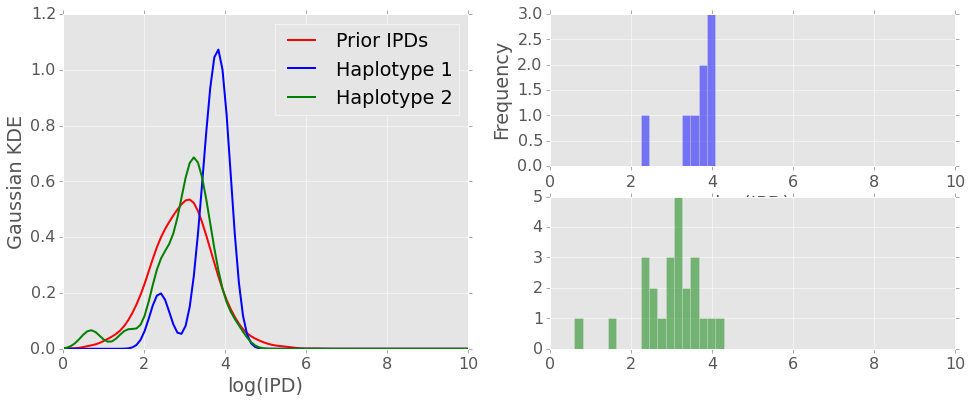

000000F 27304 motif: CTAGAGAAAAG n_prior: 1975 n_hap1: 8 n_hap2: 24

======mixed======
two components:
	weight  : [ 0.6775079  0.3224921]
	means   : [[ 3.43650781  2.52422623]]
	AIC1:  75.5404541293 	BIC1:  82.8691336433
one component:
	weight  : [ 1.]
	means   : [[ 3.14230421]]
	AIC:  75.7819071369 	BIC:  78.7133789425
=====distribution comparisions======
ks test haps  : (0.625, 0.0095926998854864061)
ks test hap1  : (0.60968354430379745, 0.0026952566538062518)
ks test hap2  : (0.12894514767932491, 0.79774672260205692)
[                  0%                  ]  15285 of 33000000 complete Elapsed: 0.4 minutes	 Remaining: 918.4 minutes

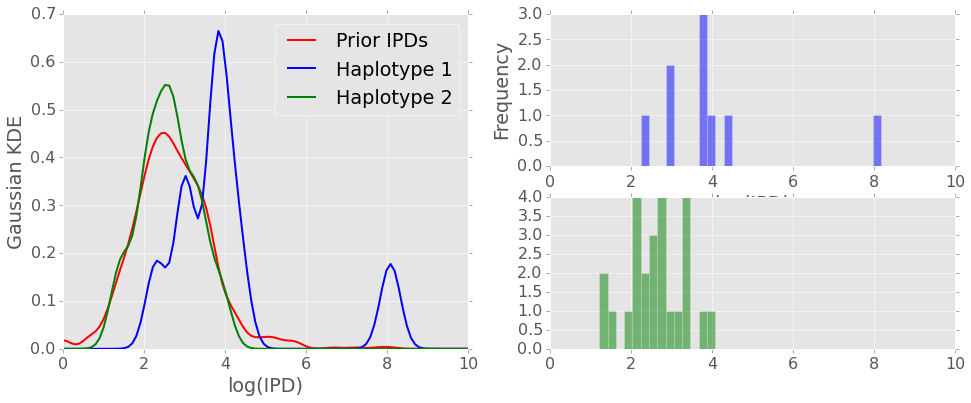

000000F 27335 motif: TGGTATACATA n_prior: 773 n_hap1: 9 n_hap2: 25

======mixed======
two components:
	weight  : [ 0.97058824  0.02941176]
	means   : [[ 2.83119225  8.0783781 ]]
	AIC1:  90.4908811592 	BIC1:  98.1226837823
one component:
	weight  : [ 1.]
	means   : [[ 2.98552124]]
	AIC:  111.038317122 	BIC:  114.091038172
=====distribution comparisions======
ks test haps  : (0.60888888888888881, 0.0077944381468992886)
ks test hap1  : (0.55799913755929276, 0.0043178997608372916)
ks test hap2  : (0.11275549805950846, 0.90028255482529984)
[                  0%                  ]  15320 of 33000000 complete Elapsed: 0.5 minutes	 Remaining: 995.2 minutes

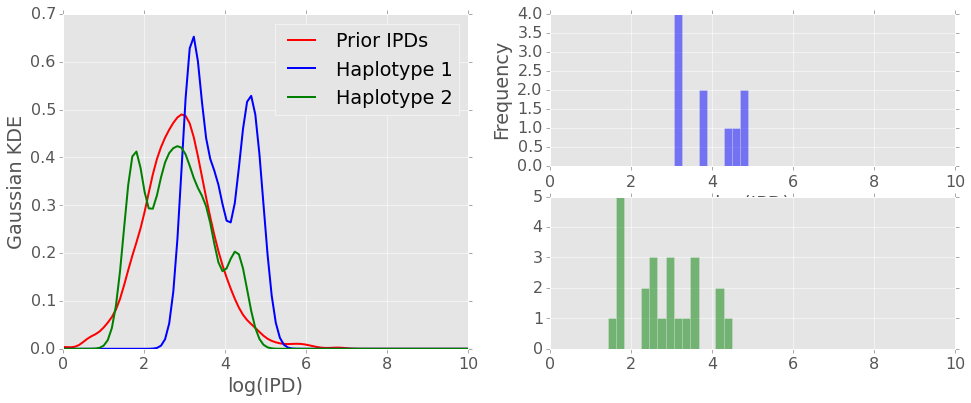

000000F 27344 motif: TACTTTCAATT n_prior: 1615 n_hap1: 10 n_hap2: 23

======mixed======
two components:
	weight  : [ 0.54599691  0.45400309]
	means   : [[ 2.56524211  3.83403353]]
	AIC1:  97.2571644319 	BIC1:  104.739702239
one component:
	weight  : [ 1.]
	means   : [[ 3.14127733]]
	AIC:  92.5241286587 	BIC:  95.5171437816
=====distribution comparisions======
ks test haps  : (0.69565217391304346, 0.0010037223264036154)
ks test hap1  : (0.6346749226006192, 0.00029763918861310884)
ks test hap2  : (0.13826894602234485, 0.74710532806994834)
[                  0%                  ]  15351 of 33000000 complete Elapsed: 0.5 minutes	 Remaining: 1063.8 minutes

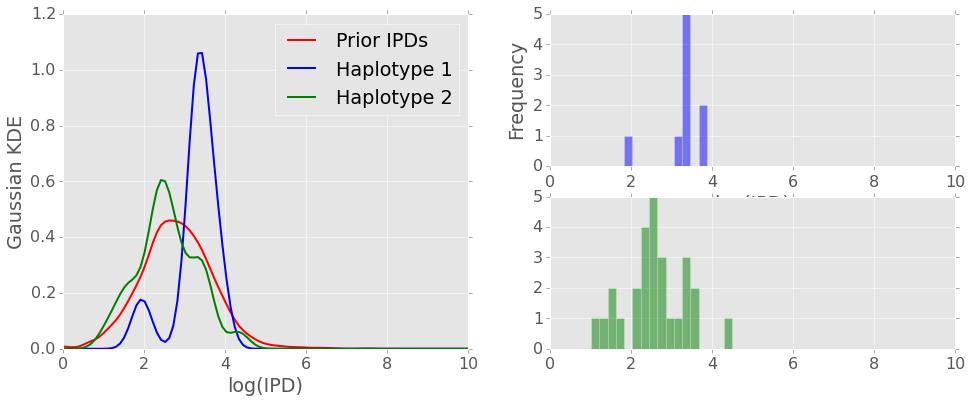

000000F 27356 motif: TTTATATATTA n_prior: 2000 n_hap1: 9 n_hap2: 27

======mixed======
two components:
	weight  : [ 0.5124659  0.4875341]
	means   : [[ 2.21431715  3.32415946]]
	AIC1:  89.4276162833 	BIC1:  97.3452109756
one component:
	weight  : [ 1.]
	means   : [[ 2.75540312]]
	AIC:  85.4902091543 	BIC:  88.6572470312
=====distribution comparisions======
ks test haps  : (0.62962962962962954, 0.0047556899649857029)
ks test hap1  : (0.53538888888888891, 0.0067695048282243571)
ks test hap2  : (0.17655555555555558, 0.34468896150533229)
[                  0%                  ]  15360 of 33000000 complete Elapsed: 0.5 minutes	 Remaining: 1141.7 minutes

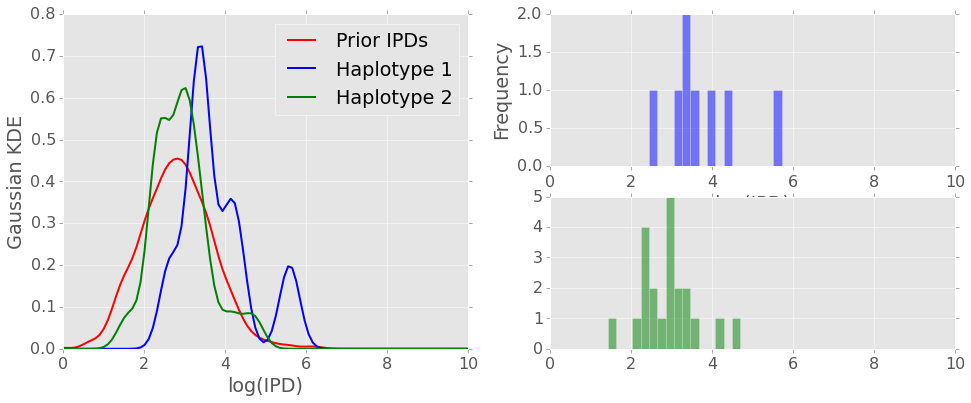

000000F 27428 motif: GACTATTAAAT n_prior: 906 n_hap1: 8 n_hap2: 21

======mixed======
two components:
	weight  : [ 0.73938364  0.26061636]
	means   : [[ 2.862185    3.97521978]]
	AIC1:  76.2946062088 	BIC1:  83.1310853587
one component:
	weight  : [ 1.]
	means   : [[ 3.15226008]]
	AIC:  74.5966268827 	BIC:  77.3312185427
=====distribution comparisions======
ks test haps  : (0.63690476190476186, 0.0093145392378065316)
ks test hap1  : (0.55049668874172186, 0.0093586041316329766)
ks test hap2  : (0.17297382529170607, 0.53022766912574726)
[                  0%                  ]  15372 of 33000000 complete Elapsed: 0.6 minutes	 Remaining: 1207.3 minutes

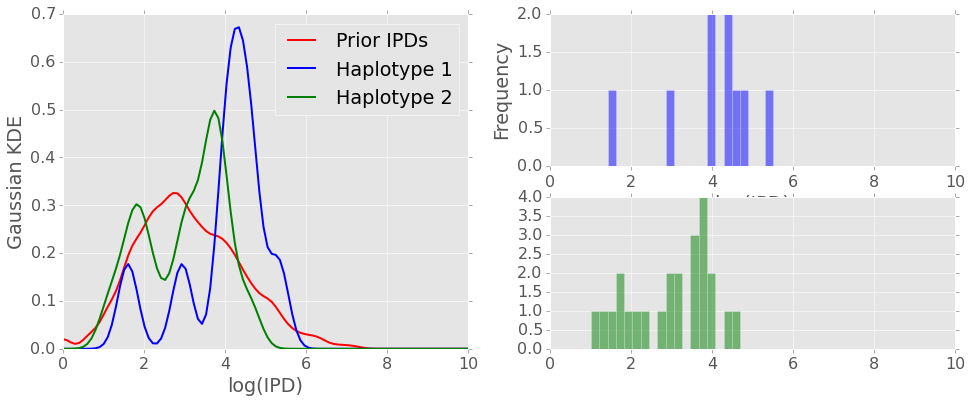

000000F 27562 motif: ATATAAGCATG n_prior: 985 n_hap1: 9 n_hap2: 24

======mixed======
two components:
	weight  : [ 0.73921588  0.26078412]
	means   : [[ 3.81469386  1.71855719]]
	AIC1:  100.364456429 	BIC1:  107.846994236
one component:
	weight  : [ 1.]
	means   : [[ 3.26805471]]
	AIC:  103.909839312 	BIC:  106.902854435
=====distribution comparisions======
ks test haps  : (0.61111111111111116, 0.0079187268788063168)
ks test hap1  : (0.52600112803158494, 0.0084473196773717785)
ks test hap2  : (0.15118443316412855, 0.62150365005424046)
[                  0%                  ]  15444 of 33000000 complete Elapsed: 0.6 minutes	 Remaining: 1272.8 minutes

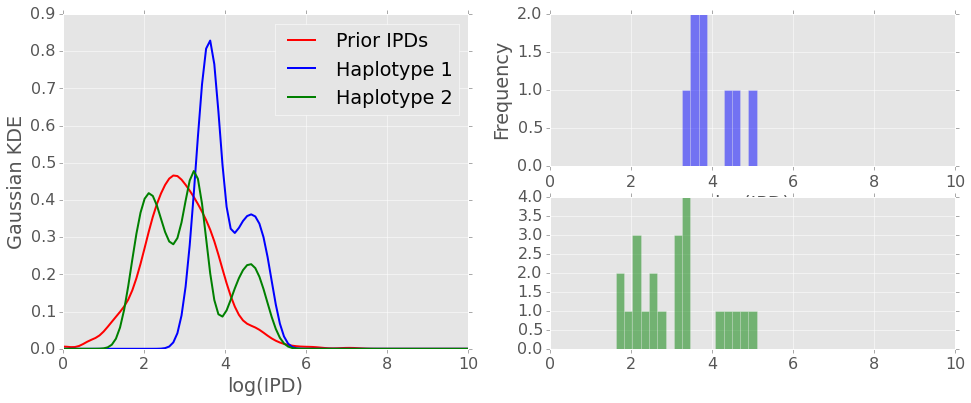

000000F 27610 motif: ATTATATATTA n_prior: 2000 n_hap1: 8 n_hap2: 22

======mixed======
two components:
	weight  : [ 0.55968701  0.44031299]
	means   : [[ 2.72008382  4.10627208]]
	AIC1:  90.9377319296 	BIC1:  97.9437188379
one component:
	weight  : [ 1.]
	means   : [[ 3.33044052]]
	AIC:  86.5274816426 	BIC:  89.329876406
=====distribution comparisions======
ks test haps  : (0.64772727272727271, 0.0072633151124811713)
ks test hap1  : (0.67649999999999999, 0.00058452922370530729)
ks test hap2  : (0.15477272727272728, 0.63691972535968622)
[                  0%                  ]  15626 of 33000000 complete Elapsed: 0.7 minutes	 Remaining: 1418.6 minutes

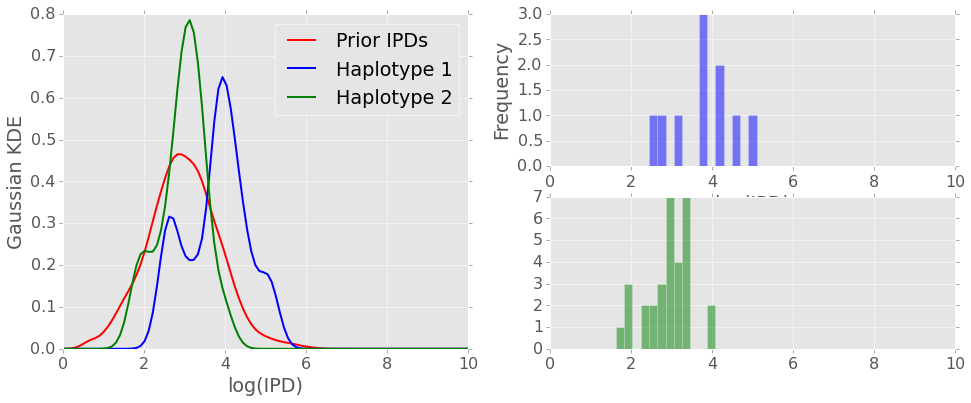

000000F 28512 motif: CATAAAATGAT n_prior: 1928 n_hap1: 10 n_hap2: 31

======mixed======
two components:
	weight  : [ 0.48243958  0.51756042]
	means   : [[ 3.49776075  2.83406385]]
	AIC1:  96.4758385161 	BIC1:  105.04369885
one component:
	weight  : [ 1.]
	means   : [[ 3.1542575]]
	AIC:  90.8256402758 	BIC:  94.2527844092
=====distribution comparisions======
ks test haps  : (0.63548387096774195, 0.0021440050212230334)
ks test hap1  : (0.52520746887966796, 0.004760198142457951)
ks test hap2  : (0.20571208673537678, 0.13241948094018208)
[                  0%                  ]  16184 of 33000000 complete Elapsed: 0.7 minutes	 Remaining: 1420.7 minutes

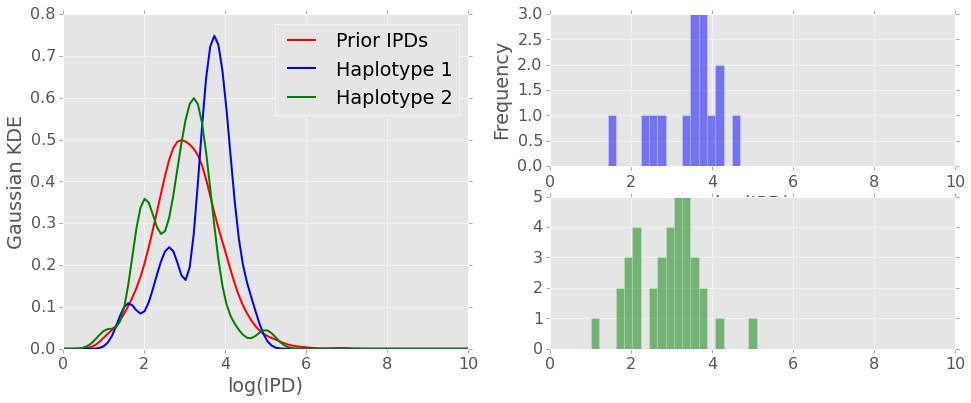

000000F 28956 motif: GAAAAAAAAAA n_prior: 2000 n_hap1: 15 n_hap2: 36

======mixed======
two components:
	weight  : [ 0.44636072  0.55363928]
	means   : [[ 2.52313701  3.48405814]]
	AIC1:  131.492691032 	BIC1:  141.151819195
one component:
	weight  : [ 1.]
	means   : [[ 3.05514069]]
	AIC:  126.690444225 	BIC:  130.554095491
=====distribution comparisions======
ks test haps  : (0.53888888888888897, 0.0023540465379596445)
ks test hap1  : (0.43233333333333329, 0.0049461797921462984)
ks test hap2  : (0.13244444444444436, 0.53448784923350201)
[                  0%                  ]  16528 of 33000000 complete Elapsed: 0.7 minutes	 Remaining: 1480.2 minutes

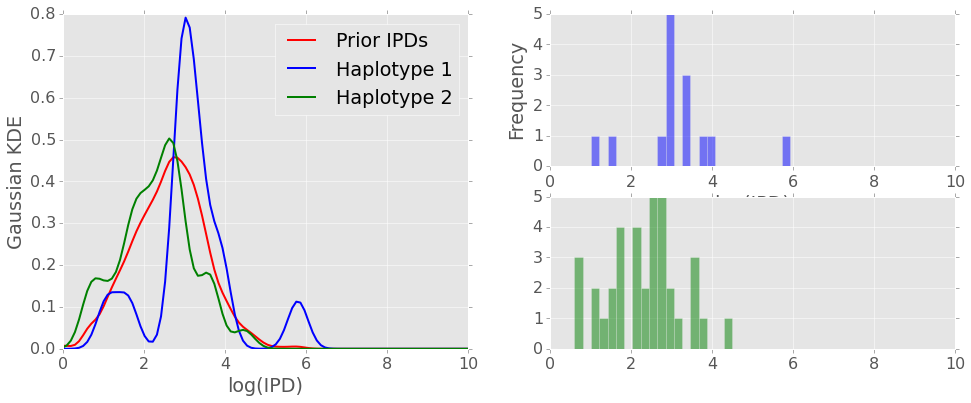

000000F 29304 motif: TCTAATGTGCA n_prior: 823 n_hap1: 14 n_hap2: 36

======mixed======
two components:
	weight  : [ 0.45723695  0.54276305]
	means   : [[ 2.08155935  2.95320919]]
	AIC1:  151.968691086 	BIC1:  161.528806113
one component:
	weight  : [ 1.]
	means   : [[ 2.55465867]]
	AIC:  145.977557959 	BIC:  149.80160397
=====distribution comparisions======
ks test haps  : (0.57936507936507931, 0.0011719102192227859)
ks test hap1  : (0.42579413296302721, 0.0090125815054618481)
ks test hap2  : (0.19663831510733099, 0.12222320328816959)
[                  0%                  ]  16972 of 33000000 complete Elapsed: 0.8 minutes	 Remaining: 1546.4 minutes

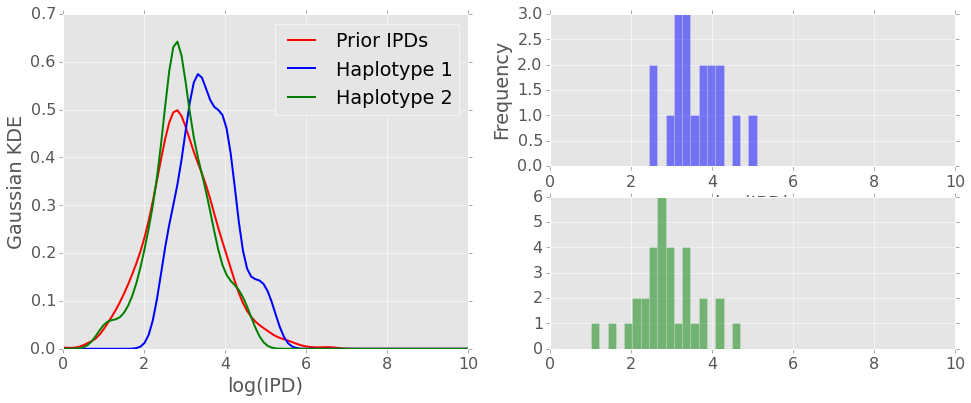

000000F 29516 motif: AACTGATAAAC n_prior: 1658 n_hap1: 18 n_hap2: 32

======mixed======
two components:
	weight  : [ 0.46931449  0.53068551]
	means   : [[ 3.59632479  2.78927092]]
	AIC1:  126.732180209 	BIC1:  136.292295236
one component:
	weight  : [ 1.]
	means   : [[ 3.168033]]
	AIC:  120.523729362 	BIC:  124.347775373
=====distribution comparisions======
ks test haps  : (0.48958333333333337, 0.0048129150578984604)
ks test hap1  : (0.40390028146361079, 0.003982574695068678)
ks test hap2  : (0.085683051869722582, 0.96880325216203322)
[                  0%                  ]  17532 of 33000000 complete Elapsed: 0.9 minutes	 Remaining: 1660.4 minutes

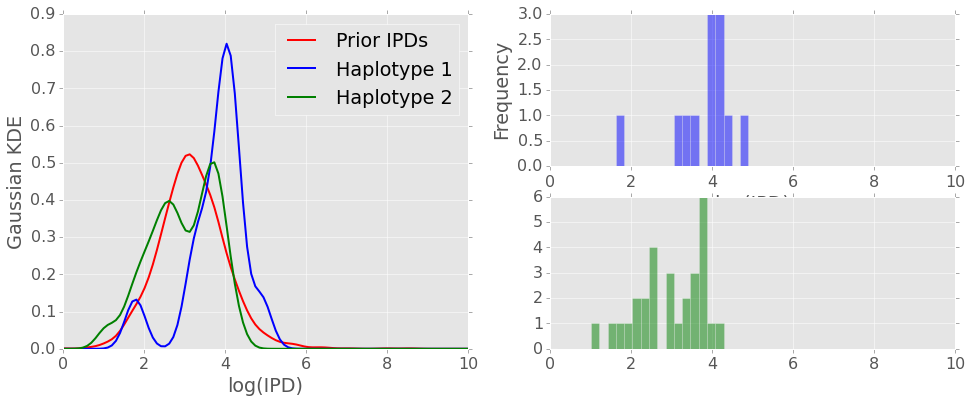

000000F 30243 motif: GGATTCCAAAA n_prior: 1740 n_hap1: 12 n_hap2: 29

======mixed======
two components:
	weight  : [ 0.44396662  0.55603338]
	means   : [[ 2.43367147  3.8251235 ]]
	AIC1:  107.631825399 	BIC1:  116.199685732
one component:
	weight  : [ 1.]
	means   : [[ 3.20736525]]
	AIC:  108.851993519 	BIC:  112.279137653
=====distribution comparisions======
ks test haps  : (0.59770114942528729, 0.0023675835829941152)
ks test hap1  : (0.49252873563218397, 0.0036650622629401334)
ks test hap2  : (0.16034482758620688, 0.42248414806193363)
[                  0%                  ]  18068 of 33000000 complete Elapsed: 0.9 minutes	 Remaining: 1656.9 minutes

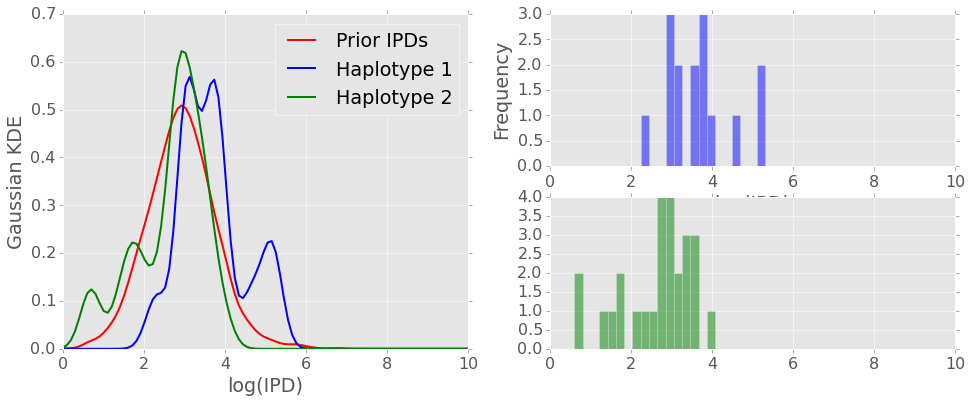

000000F 30663 motif: AAAGTTATAAG n_prior: 1650 n_hap1: 15 n_hap2: 26

======mixed======
two components:
	weight  : [ 0.68827539  0.31172461]
	means   : [[ 3.34729757  2.30705366]]
	AIC1:  121.66710506 	BIC1:  130.234965393
one component:
	weight  : [ 1.]
	means   : [[ 3.02302795]]
	AIC:  117.064770076 	BIC:  120.491914209
=====distribution comparisions======
ks test haps  : (0.54871794871794877, 0.0035966825188167078)
ks test hap1  : (0.45878787878787886, 0.0023437816443861482)
ks test hap2  : (0.140932400932401, 0.65583124883437416)
[                  0%                  ]  18259 of 33000000 complete Elapsed: 1.0 minutes	 Remaining: 1721.9 minutes

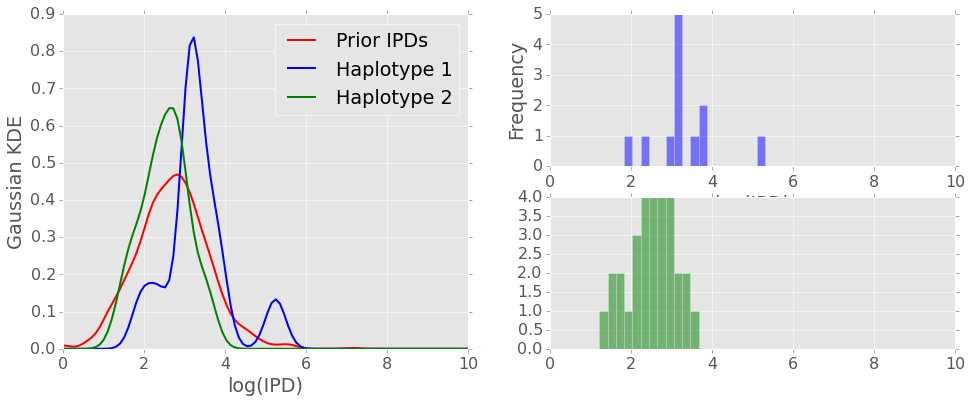

000000F 30681 motif: GAATGAGTATT n_prior: 888 n_hap1: 12 n_hap2: 30

======mixed======
two components:
	weight  : [ 0.56777106  0.43222894]
	means   : [[ 2.55899519  2.98767974]]
	AIC1:  100.064694321 	BIC1:  108.753042412
one component:
	weight  : [ 1.]
	means   : [[ 2.74428506]]
	AIC:  95.8829149247 	BIC:  99.3582541612
=====distribution comparisions======
ks test haps  : (0.66666666666666674, 0.00042301528358939031)
ks test hap1  : (0.47972972972972971, 0.0052549476354108119)
ks test hap2  : (0.20382882882882891, 0.15786726017094924)
[                  0%                  ]  18679 of 33000000 complete Elapsed: 1.0 minutes	 Remaining: 1775.9 minutes

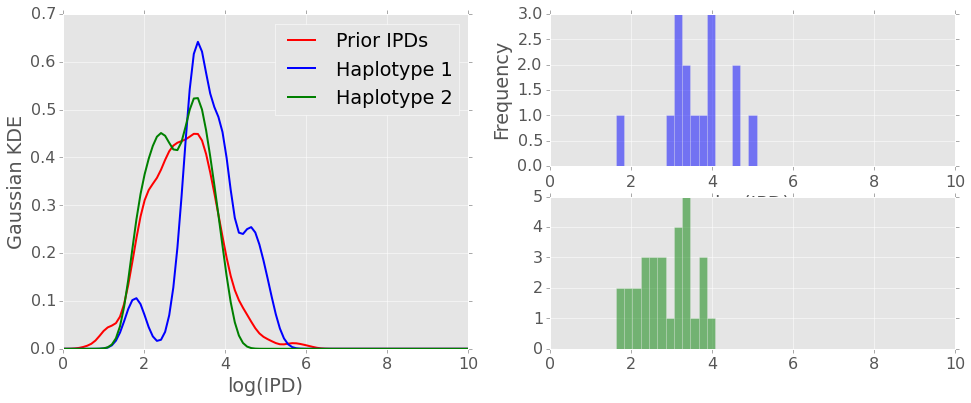

000000F 30972 motif: ACCTGACATCC n_prior: 387 n_hap1: 15 n_hap2: 30

======mixed======
two components:
	weight  : [ 0.56931471  0.43068529]
	means   : [[ 3.50189225  2.61103681]]
	AIC1:  114.002315103 	BIC1:  123.035627552
one component:
	weight  : [ 1.]
	means   : [[ 3.11821392]]
	AIC:  108.284893199 	BIC:  111.898218178
=====distribution comparisions======
ks test haps  : (0.5, 0.0081616786591430686)
ks test hap1  : (0.45064599483204137, 0.003550138354171283)
ks test hap2  : (0.11757105943152457, 0.81195332579622581)
[                  0%                  ]  18988 of 33000000 complete Elapsed: 1.1 minutes	 Remaining: 1887.6 minutes

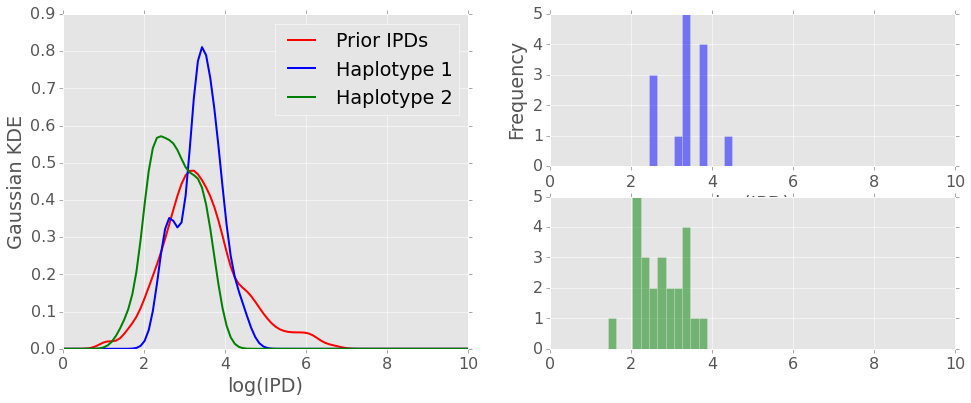

000000F 31761 motif: GTACAGAGGAT n_prior: 325 n_hap1: 14 n_hap2: 24

======mixed======
two components:
	weight  : [ 0.51751136  0.48248864]
	means   : [[ 3.46741493  2.47167293]]
	AIC1:  77.275822021 	BIC1:  85.4637528196
one component:
	weight  : [ 1.]
	means   : [[ 2.98698072]]
	AIC:  74.6872133636 	BIC:  77.9623856831
=====distribution comparisions======
ks test haps  : (0.5357142857142857, 0.0072114360938031639)
ks test hap1  : (0.24109890109890111, 0.36643334625028995)
ks test hap2  : (0.33820512820512816, 0.0087890848000514686)
[                  0%                  ]  19592 of 33000000 complete Elapsed: 1.1 minutes	 Remaining: 1871.5 minutes

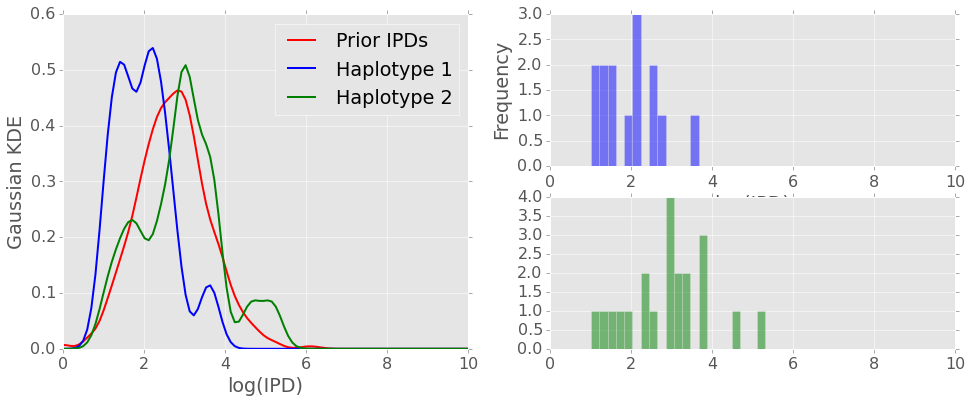

000000F 32144 motif: CACAAATGACT n_prior: 1147 n_hap1: 14 n_hap2: 21

======mixed======
two components:
	weight  : [ 0.53299997  0.46700003]
	means   : [[ 2.01818235  3.1422064 ]]
	AIC1:  106.691604528 	BIC1:  114.468344835
one component:
	weight  : [ 1.]
	means   : [[ 2.54310161]]
	AIC:  102.403365537 	BIC:  105.51406166
=====distribution comparisions======
ks test haps  : (0.54761904761904767, 0.007379450584668385)
ks test hap1  : (0.4386598580146967, 0.0063045187233448374)
ks test hap2  : (0.1839996678706356, 0.44710304550752156)
[                  0%                  ]  19777 of 33000000 complete Elapsed: 1.2 minutes	 Remaining: 1918.7 minutes

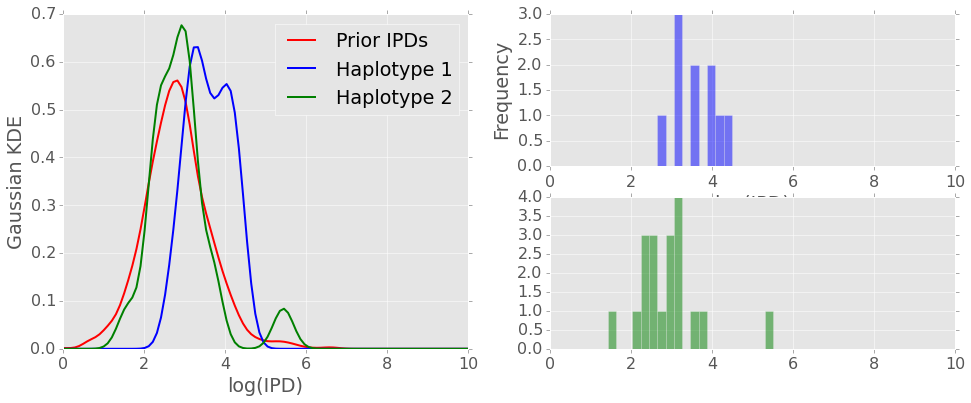

000000F 32560 motif: AACAAGATAAG n_prior: 1291 n_hap1: 10 n_hap2: 19

======mixed======
two components:
	weight  : [ 0.62994913  0.37005087]
	means   : [[ 2.86497164  3.63916516]]
	AIC1:  74.6389322307 	BIC1:  81.4754113807
one component:
	weight  : [ 1.]
	means   : [[ 3.15146263]]
	AIC:  70.9220945385 	BIC:  73.6566861984
=====distribution comparisions======
ks test haps  : (0.63684210526315788, 0.0048953223198047588)
ks test hap1  : (0.58474051123160342, 0.0011401689808188734)
ks test hap2  : (0.12169269028496882, 0.92844320440508921)
[                  0%                  ]  20159 of 33000000 complete Elapsed: 1.2 minutes	 Remaining: 1967.7 minutes

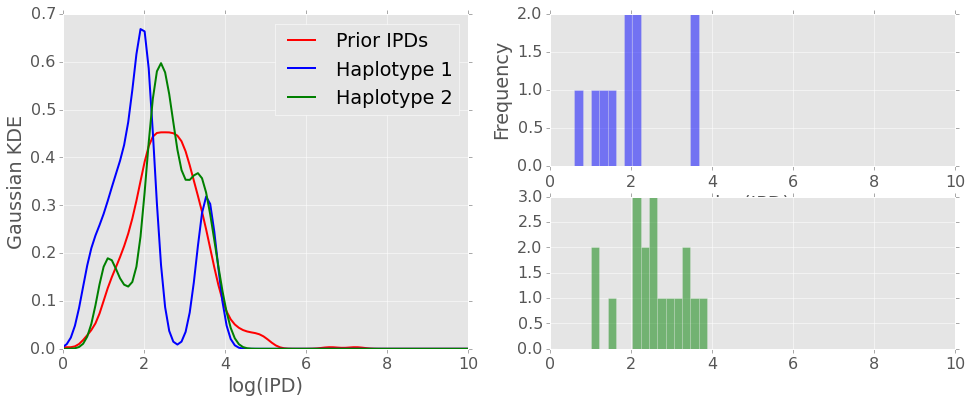

000000F 32686 motif: TATGTGGTTCA n_prior: 598 n_hap1: 10 n_hap2: 18

======mixed======
two components:
	weight  : [ 0.46047225  0.53952775]
	means   : [[ 2.98861501  1.81115157]]
	AIC1:  79.0582487773 	BIC1:  85.7192713282
one component:
	weight  : [ 1.]
	means   : [[ 2.3533408]]
	AIC:  74.1698859488 	BIC:  76.8342949692
=====distribution comparisions======
ks test haps  : (0.63333333333333341, 0.005799053138997084)
ks test hap1  : (0.50234113712374584, 0.0084480623626743082)
ks test hap2  : (0.13099219620958755, 0.90503048763832528)
[                  0%                  ]  20575 of 33000000 complete Elapsed: 1.3 minutes	 Remaining: 2012.9 minutes

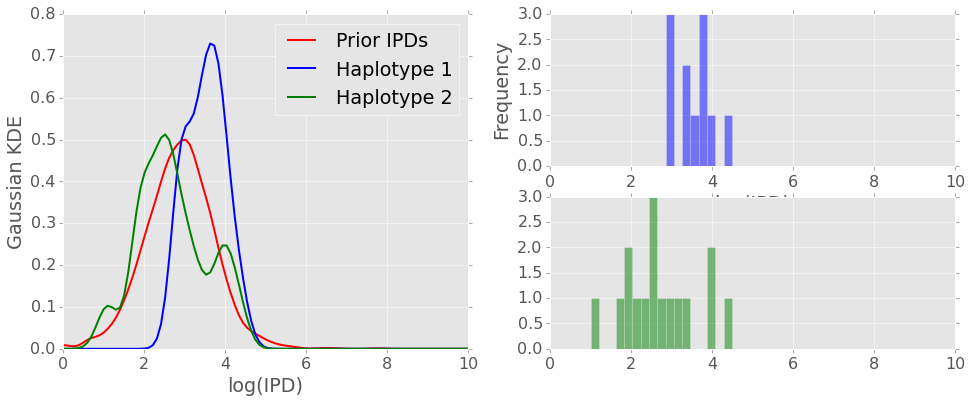

000000F 32713 motif: TAATTACAGAA n_prior: 1572 n_hap1: 11 n_hap2: 16

======mixed======
two components:
	weight  : [ 0.64304217  0.35695783]
	means   : [[ 2.60551294  3.82634735]]
	AIC1:  72.641998539 	BIC1:  79.121182869
one component:
	weight  : [ 1.]
	means   : [[ 3.04129934]]
	AIC:  69.4886526826 	BIC:  72.0803264146
=====distribution comparisions======
ks test haps  : (0.625, 0.0062773178519909311)
ks test hap1  : (0.48346055979643765, 0.0074622171376083901)
ks test hap2  : (0.2032442748091603, 0.48236897932954836)
[                  0%                  ]  20701 of 33000000 complete Elapsed: 1.3 minutes	 Remaining: 2061.2 minutes

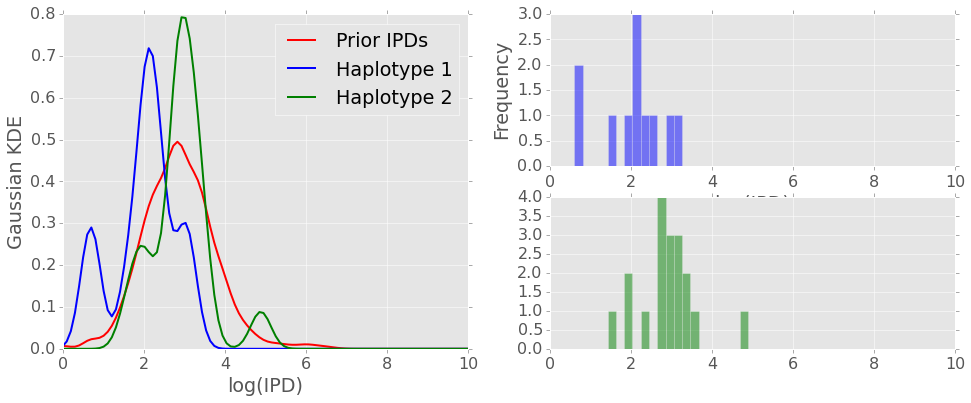

000000F 32938 motif: CACAGACAATA n_prior: 1203 n_hap1: 11 n_hap2: 18

======mixed======
two components:
	weight  : [ 0.58264676  0.41735324]
	means   : [[ 2.70739243  2.36954753]]
	AIC1:  79.0561985853 	BIC1:  85.8926777353
one component:
	weight  : [ 1.]
	means   : [[ 2.56639177]]
	AIC:  75.9578728922 	BIC:  78.6924645522
=====distribution comparisions======
ks test haps  : (0.59595959595959602, 0.0084201373246678823)
ks test hap1  : (0.47404216730900028, 0.0093594601317680184)
ks test hap2  : (0.18176780271543364, 0.55716257356107446)
[                  0%                  ]  20728 of 33000000 complete Elapsed: 1.3 minutes	 Remaining: 2118.7 minutes

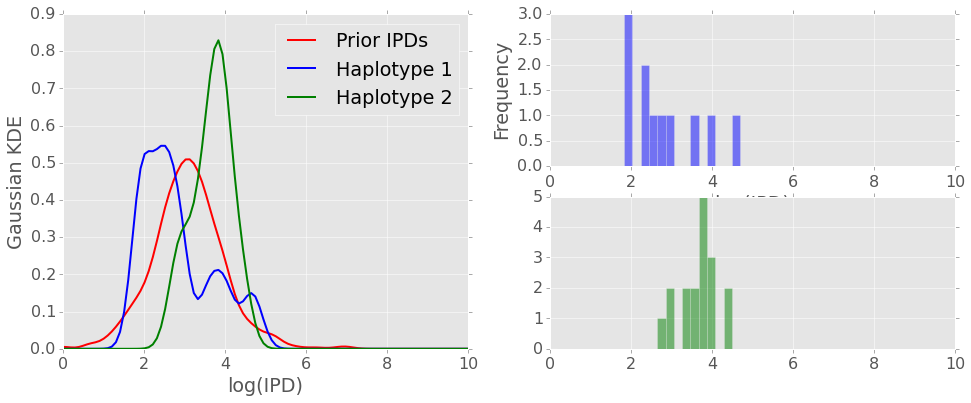

000000F 33372 motif: TCCCTTTCCAC n_prior: 1149 n_hap1: 11 n_hap2: 17

======mixed======
two components:
	weight  : [ 0.56869885  0.43130115]
	means   : [[ 3.90278028  2.60311565]]
	AIC1:  68.8666647708 	BIC1:  75.5276873216
one component:
	weight  : [ 1.]
	means   : [[ 3.34223343]]
	AIC:  68.4522691598 	BIC:  71.1166781801
=====distribution comparisions======
ks test haps  : (0.60962566844919786, 0.0073348162462109189)
ks test hap1  : (0.31386976817786222, 0.19041586654193987)
ks test hap2  : (0.43398351507704908, 0.0022924790649806004)
[                  0%                  ]  20953 of 33000000 complete Elapsed: 1.4 minutes	 Remaining: 2162.3 minutes

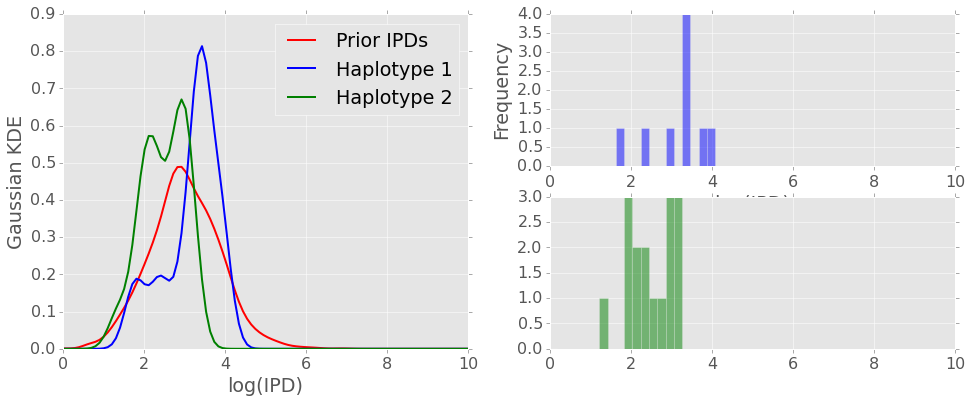

000000F 33642 motif: AATTGTTTTTT n_prior: 2000 n_hap1: 9 n_hap2: 16

======mixed======
two components:
	weight  : [ 0.44546797  0.55453203]
	means   : [[ 2.1482905  3.2132077]]
	AIC1:  57.1006434145 	BIC1:  63.1950225388
one component:
	weight  : [ 1.]
	means   : [[ 2.73882119]]
	AIC:  53.5809717239 	BIC:  56.0187233737
=====distribution comparisions======
ks test haps  : (0.66666666666666674, 0.0057482865466603264)
ks test hap1  : (0.32816666666666666, 0.23558092415310516)
ks test hap2  : (0.39800000000000002, 0.0089591646438907588)
[                  0%                  ]  32188 of 33000000 complete Elapsed: 1.8 minutes	 Remaining: 1818.0 minutes

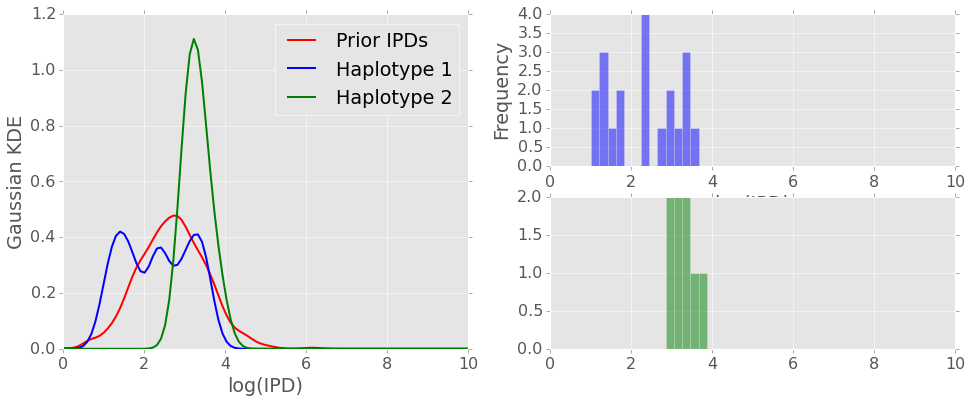

000000F 45676 motif: TCTGTAATCTG n_prior: 963 n_hap1: 20 n_hap2: 8

======mixed======
two components:
	weight  : [ 0.45429506  0.54570494]
	means   : [[ 1.81226758  3.27193735]]
	AIC1:  66.9096634887 	BIC1:  73.5706860396
one component:
	weight  : [ 1.]
	means   : [[ 2.60881659]]
	AIC:  73.4097228484 	BIC:  76.0741318687
=====distribution comparisions======
ks test haps  : (0.65000000000000002, 0.007991327169458667)
ks test hap1  : (0.23696780893042577, 0.19117782555698737)
ks test hap2  : (0.60955347871235721, 0.002774175259359538)
[                  0%                  ]  33299 of 33000000 complete Elapsed: 1.8 minutes	 Remaining: 1782.0 minutes

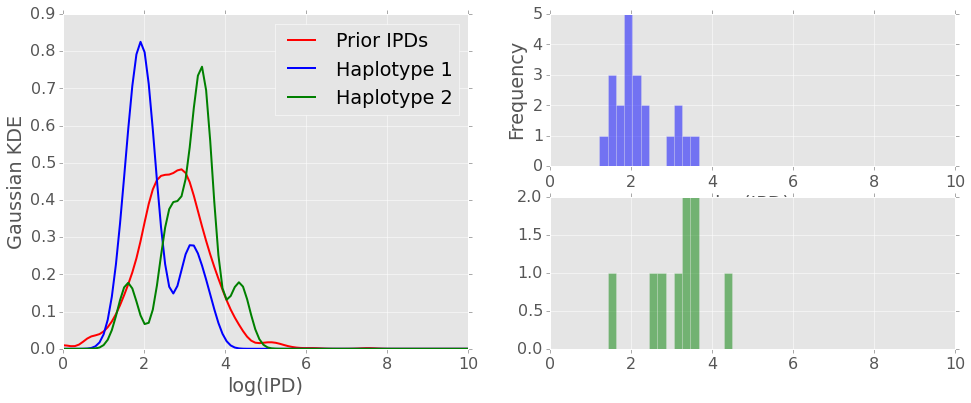

000000F 45784 motif: CATCATCACAC n_prior: 1051 n_hap1: 21 n_hap2: 9

======mixed======
two components:
	weight  : [ 0.54929302  0.45070698]
	means   : [[ 1.88656332  3.24922845]]
	AIC1:  67.3541169338 	BIC1:  74.3601038421
one component:
	weight  : [ 1.]
	means   : [[ 2.500726]]
	AIC:  73.9064151193 	BIC:  76.7088098826
=====distribution comparisions======
ks test haps  : (0.6507936507936507, 0.0046881518191825237)
ks test hap1  : (0.40129581804177422, 0.0017185682356707897)
ks test hap2  : (0.3395707791521303, 0.20441633499745032)
[                  0%                  ]  34386 of 33000000 complete Elapsed: 1.9 minutes	 Remaining: 1829.1 minutes

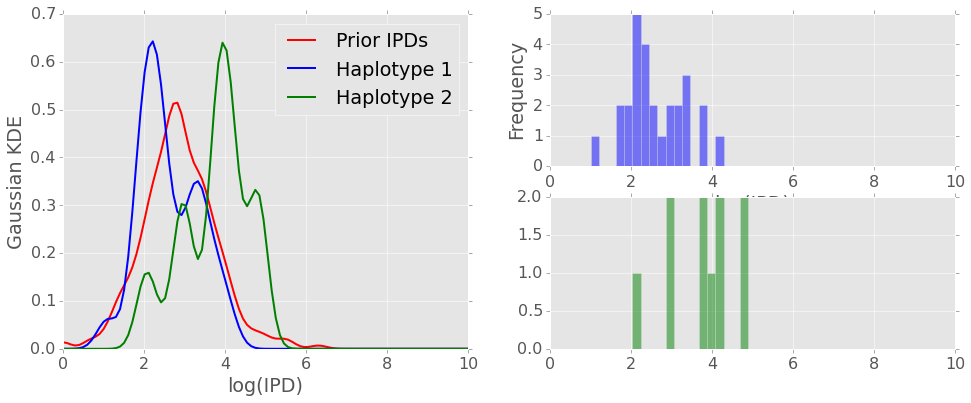

000000F 47355 motif: CAACATAGCTG n_prior: 582 n_hap1: 27 n_hap2: 10

======mixed======
two components:
	weight  : [ 0.5085112  0.4914888]
	means   : [[ 2.20534092  3.65859702]]
	AIC1:  101.781321339 	BIC1:  109.835910902
one component:
	weight  : [ 1.]
	means   : [[ 2.91960002]]
	AIC:  101.101050277 	BIC:  104.322886103
=====distribution comparisions======
ks test haps  : (0.625925925925926, 0.0032620452908351943)
ks test hap1  : (0.25754104620084001, 0.053754628471633342)
ks test hap2  : (0.54879725085910658, 0.0029411444483956987)
[                  0%                  ]  35089 of 33000000 complete Elapsed: 1.9 minutes	 Remaining: 1815.9 minutes

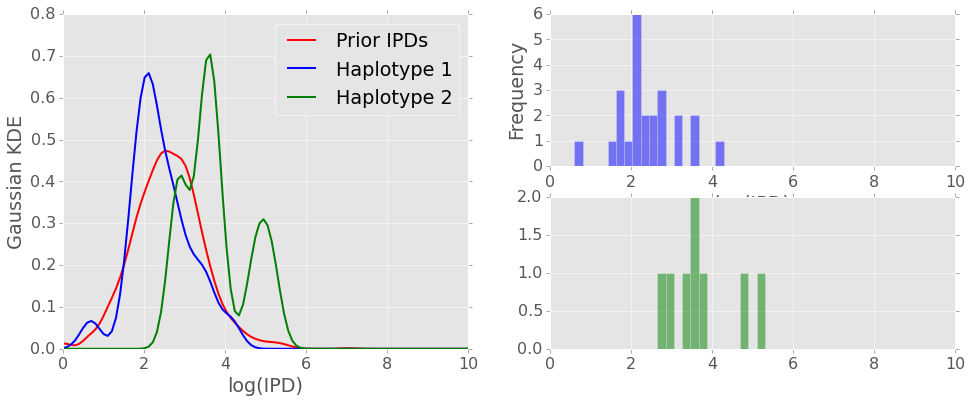

000000F 47523 motif: GAGGCAGGATG n_prior: 1370 n_hap1: 24 n_hap2: 8

======mixed======
two components:
	weight  : [ 0.59697284  0.40302716]
	means   : [[ 2.31719593  3.40671356]]
	AIC1:  95.0192523315 	BIC1:  102.347931846
one component:
	weight  : [ 1.]
	means   : [[ 2.75630112]]
	AIC:  90.7723748835 	BIC:  93.7038466891
=====distribution comparisions======
ks test haps  : (0.75, 0.00091525414760188016)
ks test hap1  : (0.17049878345498781, 0.46172566567235607)
ks test hap2  : (0.6105839416058394, 0.0026723643203991894)
[                  0%                  ]  35370 of 33000000 complete Elapsed: 2.0 minutes	 Remaining: 1838.0 minutes

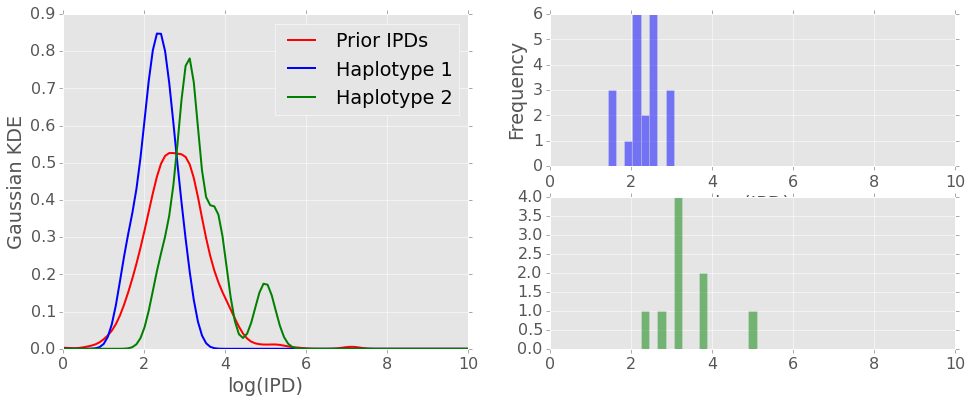

000000F 47673 motif: CCAGAGGCTCA n_prior: 722 n_hap1: 21 n_hap2: 9

======mixed======
two components:
	weight  : [ 0.25380679  0.74619321]
	means   : [[ 3.22623927  2.42911427]]
	AIC1:  67.8954206561 	BIC1:  74.9014075644
one component:
	weight  : [ 1.]
	means   : [[ 2.63143001]]
	AIC:  67.9335721319 	BIC:  70.7359668953
=====distribution comparisions======
ks test haps  : (0.77777777777777779, 0.00035036216701350942)
ks test hap1  : (0.41115947764147204, 0.0012884028029415005)
ks test hap2  : (0.42597722376115732, 0.056059676499675935)
[                  0%                  ]  35538 of 33000000 complete Elapsed: 2.0 minutes	 Remaining: 1866.1 minutes

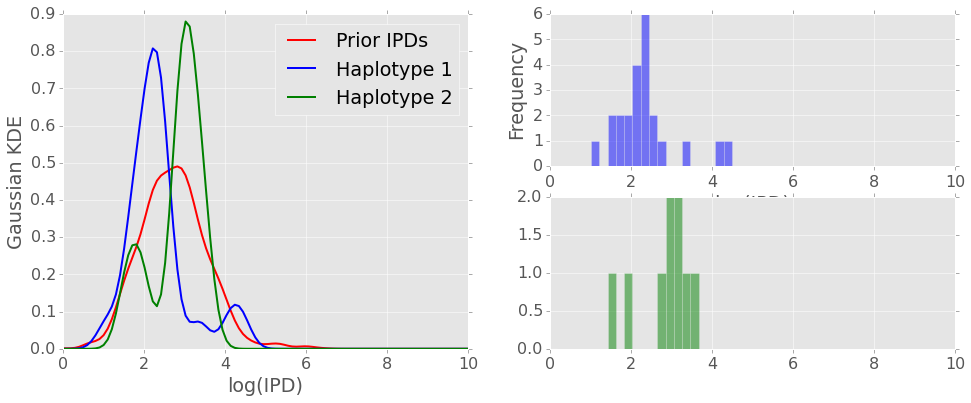

000000F 47702 motif: CCCTGGGCCTG n_prior: 1524 n_hap1: 23 n_hap2: 9

======mixed======
two components:
	weight  : [ 0.39075998  0.60924002]
	means   : [[ 3.01322949  2.14083275]]
	AIC1:  76.9704405368 	BIC1:  84.2991200508
one component:
	weight  : [ 1.]
	means   : [[ 2.48173049]]
	AIC:  74.5567394569 	BIC:  77.4882112625
=====distribution comparisions======
ks test haps  : (0.64734299516908211, 0.0043106887587711909)
ks test hap1  : (0.37726805888394388, 0.0021326205731316376)
ks test hap2  : (0.2909011373578303, 0.37136302244618458)
[                  0%                  ]  35688 of 33000000 complete Elapsed: 2.1 minutes	 Remaining: 1897.4 minutes

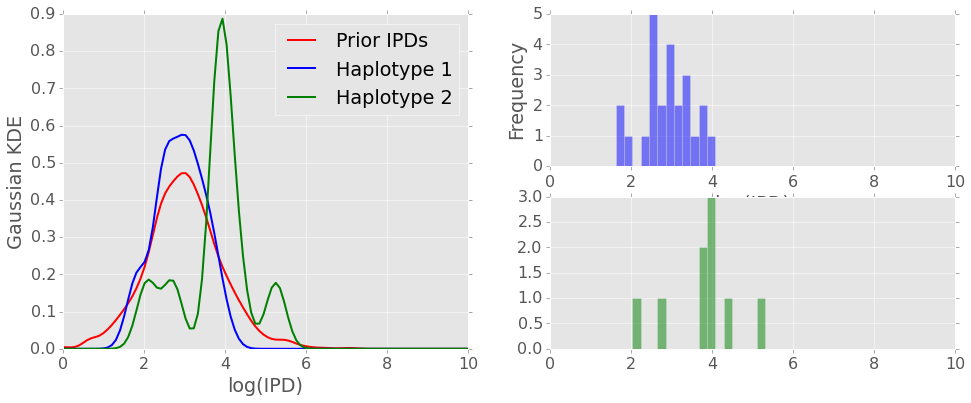

000000F 47762 motif: GACTTTCCTCC n_prior: 915 n_hap1: 24 n_hap2: 9

======mixed======
two components:
	weight  : [ 0.54080091  0.45919909]
	means   : [[ 2.72197245  3.58982129]]
	AIC1:  86.3256688434 	BIC1:  93.8082066507
one component:
	weight  : [ 1.]
	means   : [[ 3.12048785]]
	AIC:  80.8378148421 	BIC:  83.830829965
=====distribution comparisions======
ks test haps  : (0.73611111111111116, 0.0006536619516906855)
ks test hap1  : (0.15614754098360661, 0.58128764557379453)
ks test hap2  : (0.60291438979963574, 0.0015262440617047597)
[                  0%                  ]  35717 of 33000000 complete Elapsed: 2.1 minutes	 Remaining: 1926.4 minutes

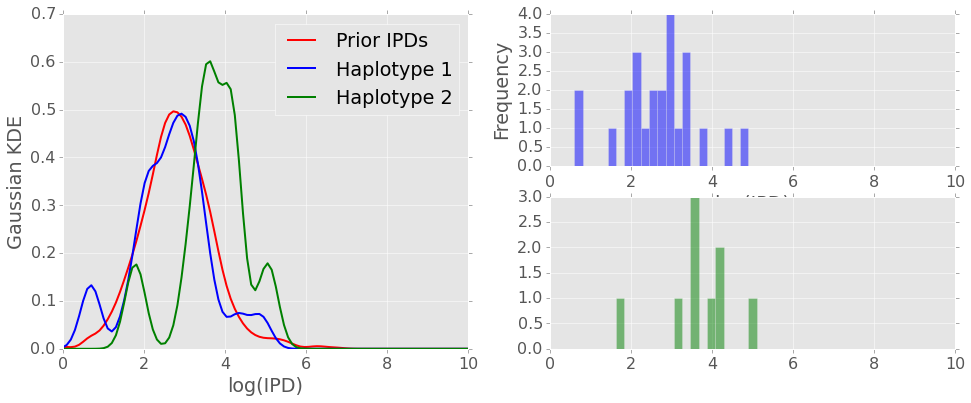

000000F 48157 motif: CAACAACAGCA n_prior: 2000 n_hap1: 24 n_hap2: 9

======mixed======
two components:
	weight  : [ 0.53868584  0.46131416]
	means   : [[ 3.45973151  2.37260354]]
	AIC1:  105.131655019 	BIC1:  112.614192827
one component:
	weight  : [ 1.]
	means   : [[ 2.95822399]]
	AIC:  99.2398508977 	BIC:  102.232866021
=====distribution comparisions======
ks test haps  : (0.65277777777777779, 0.0036298676286146631)
ks test hap1  : (0.095333333333333325, 0.97637509534059175)
ks test hap2  : (0.58877777777777784, 0.0020572170499878035)
[                  0%                  ]  35777 of 33000000 complete Elapsed: 2.1 minutes	 Remaining: 1954.2 minutes

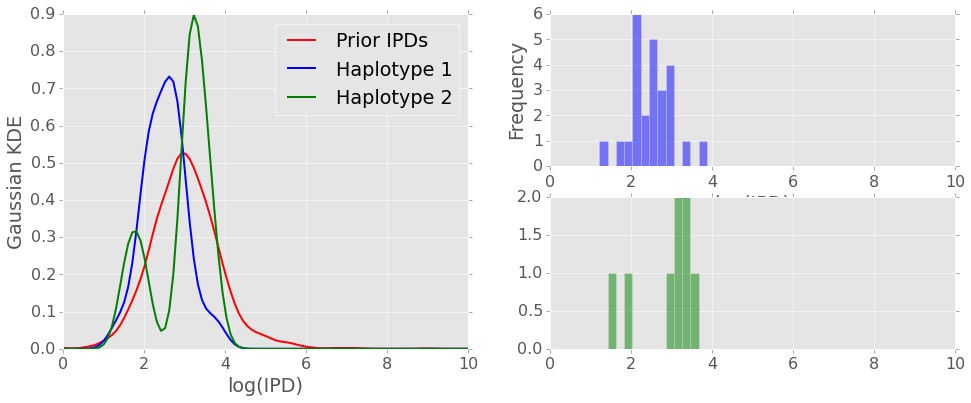

000000F 48304 motif: CTCTTCTCCAG n_prior: 2000 n_hap1: 25 n_hap2: 8

======mixed======
two components:
	weight  : [ 0.53395633  0.46604367]
	means   : [[ 2.93164211  2.25251326]]
	AIC1:  67.2412593457 	BIC1:  74.7237971531
one component:
	weight  : [ 1.]
	means   : [[ 2.61513841]]
	AIC:  61.6885203597 	BIC:  64.6815354827
=====distribution comparisions======
ks test haps  : (0.67000000000000004, 0.0040851987952045836)
ks test hap1  : (0.40700000000000003, 0.00034855133852221591)
ks test hap2  : (0.26300000000000001, 0.57004708569041695)
[                  0%                  ]  36172 of 33000000 complete Elapsed: 2.2 minutes	 Remaining: 1977.8 minutes

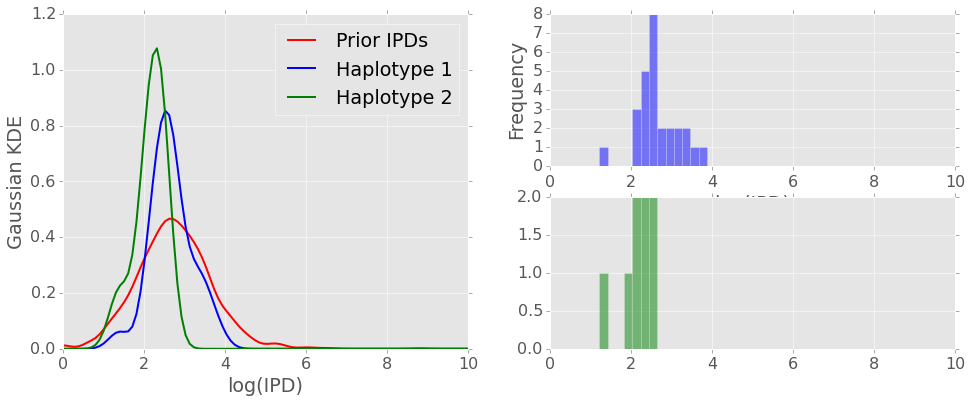

000000F 48567 motif: CATACACAAGT n_prior: 1296 n_hap1: 27 n_hap2: 8

======mixed======
two components:
	weight  : [ 0.32910237  0.67089763]
	means   : [[ 2.94093022  2.365273  ]]
	AIC1:  62.3306022688 	BIC1:  70.1073425763
one component:
	weight  : [ 1.]
	means   : [[ 2.55472315]]
	AIC:  56.9790516858 	BIC:  60.0897478088
=====distribution comparisions======
ks test haps  : (0.62962962962962965, 0.0076847042706836835)
ks test hap1  : (0.19598765432098764, 0.23373034233991119)
ks test hap2  : (0.59336419753086422, 0.0038686779431969364)
[                  0%                  ]  36319 of 33000000 complete Elapsed: 2.2 minutes	 Remaining: 2004.3 minutes

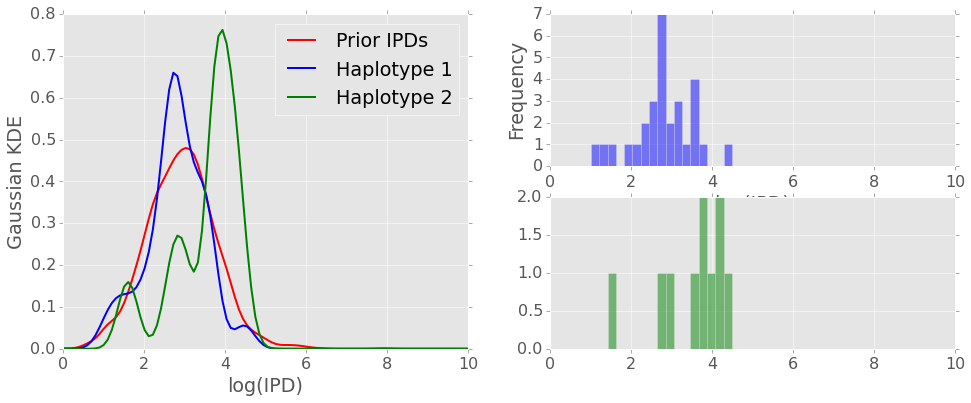

000000F 48777 motif: TGAAAAACACA n_prior: 2000 n_hap1: 29 n_hap2: 10

======mixed======
two components:
	weight  : [ 0.51704305  0.48295695]
	means   : [[ 2.56079138  3.42540504]]
	AIC1:  103.127240127 	BIC1:  111.445048358
one component:
	weight  : [ 1.]
	means   : [[ 2.97836256]]
	AIC:  97.7565400302 	BIC:  101.083663322
=====distribution comparisions======
ks test haps  : (0.63103448275862073, 0.0026168997715190294)
ks test hap1  : (0.13467241379310346, 0.64576818733925656)
ks test hap2  : (0.52200000000000002, 0.0051181835680943911)
[                  0%                  ]  36582 of 33000000 complete Elapsed: 2.3 minutes	 Remaining: 2028.1 minutes

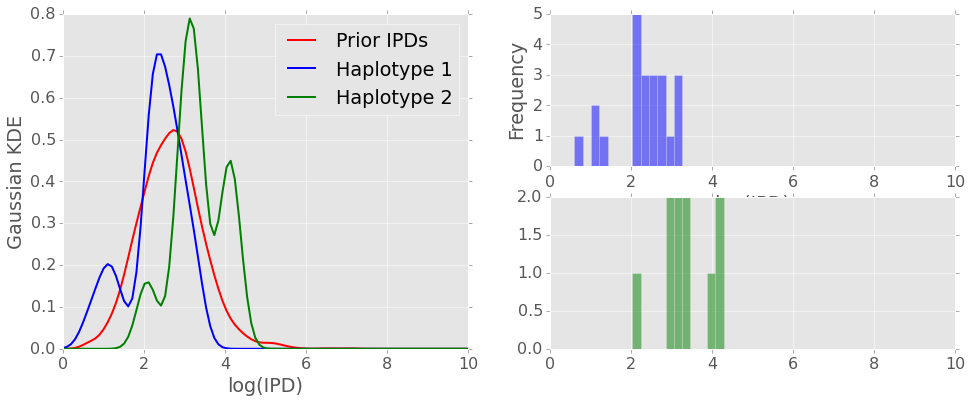

000000F 48830 motif: CAGGCCAACAT n_prior: 2000 n_hap1: 22 n_hap2: 10

======mixed======
two components:
	weight  : [ 0.44757324  0.55242676]
	means   : [[ 2.20029501  2.96613785]]
	AIC1:  86.9259572819 	BIC1:  94.2546367959
one component:
	weight  : [ 1.]
	means   : [[ 2.62336709]]
	AIC:  81.6026526756 	BIC:  84.5341244812
=====distribution comparisions======
ks test haps  : (0.76363636363636367, 0.00023731318661323808)
ks test hap1  : (0.22613636363636369, 0.18780127386280721)
ks test hap2  : (0.53749999999999998, 0.0035719438987558525)
[                  0%                  ]  36792 of 33000000 complete Elapsed: 2.3 minutes	 Remaining: 2057.5 minutes

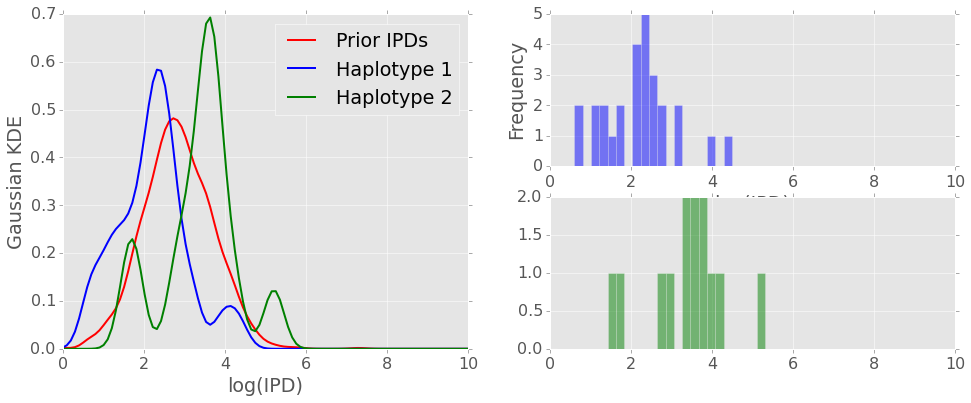

000000F 48841 motif: GCAAATTCAGG n_prior: 1141 n_hap1: 27 n_hap2: 13

======mixed======
two components:
	weight  : [ 0.57741329  0.42258671]
	means   : [[ 2.07607363  3.28845672]]
	AIC1:  124.936285781 	BIC1:  133.380683052
one component:
	weight  : [ 1.]
	means   : [[ 2.58841061]]
	AIC:  119.66677396 	BIC:  123.044532869
=====distribution comparisions======
ks test haps  : (0.66096866096866091, 0.00040603009229093904)
ks test hap1  : (0.35754860908235142, 0.0016169777183485925)
ks test hap2  : (0.3943234679430998, 0.02606561778425525)
[                  0%                  ]  36845 of 33000000 complete Elapsed: 2.3 minutes	 Remaining: 2084.1 minutes

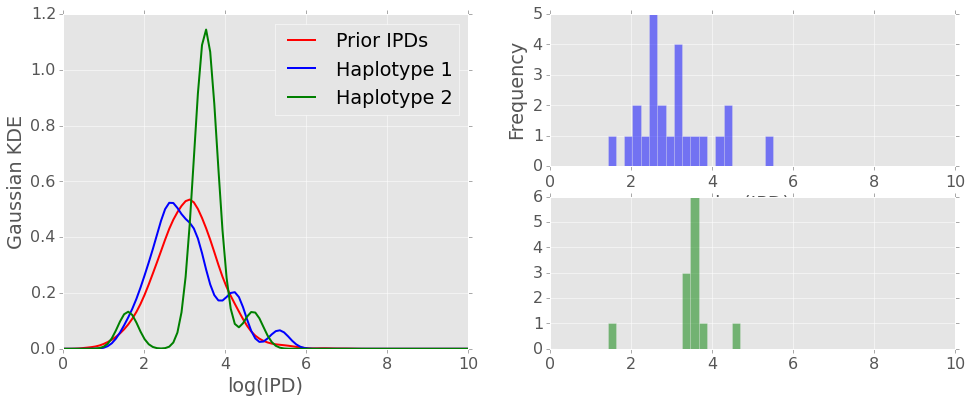

000000F 48932 motif: TGAAGGAAAAA n_prior: 2000 n_hap1: 24 n_hap2: 12

======mixed======
two components:
	weight  : [ 0.54930132  0.45069868]
	means   : [[ 3.57569627  2.71836769]]
	AIC1:  97.6090936791 	BIC1:  105.526688371
one component:
	weight  : [ 1.]
	means   : [[ 3.18929941]]
	AIC:  91.4958812246 	BIC:  94.6629191015
=====distribution comparisions======
ks test haps  : (0.625, 0.0018756845638724759)
ks test hap1  : (0.13216666666666665, 0.77243970437280951)
ks test hap2  : (0.52666666666666662, 0.0014753044906962703)
[                  0%                  ]  36856 of 33000000 complete Elapsed: 2.4 minutes	 Remaining: 2115.1 minutes

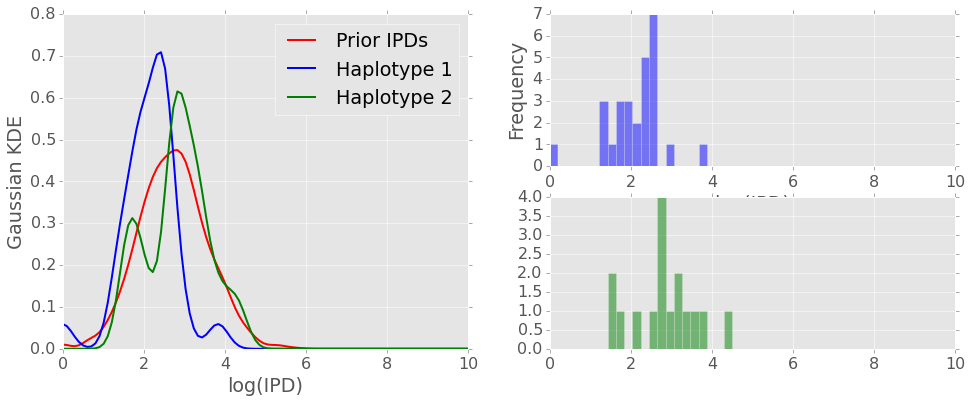

000000F 48984 motif: AGAGAAGCCCA n_prior: 1185 n_hap1: 27 n_hap2: 16

======mixed======
two components:
	weight  : [ 0.49073637  0.50926363]
	means   : [[ 2.06061742  2.70848332]]
	AIC1:  110.489835819 	BIC1:  119.295836398
one component:
	weight  : [ 1.]
	means   : [[ 2.39055196]]
	AIC:  104.211607906 	BIC:  107.734008137
=====distribution comparisions======
ks test haps  : (0.61342592592592593, 0.00048870036368020239)
ks test hap1  : (0.44491326769807782, 3.2278633080030725e-05)
ks test hap2  : (0.19556962025316454, 0.53452044141809496)
[                  0%                  ]  36947 of 33000000 complete Elapsed: 2.4 minutes	 Remaining: 2140.5 minutes

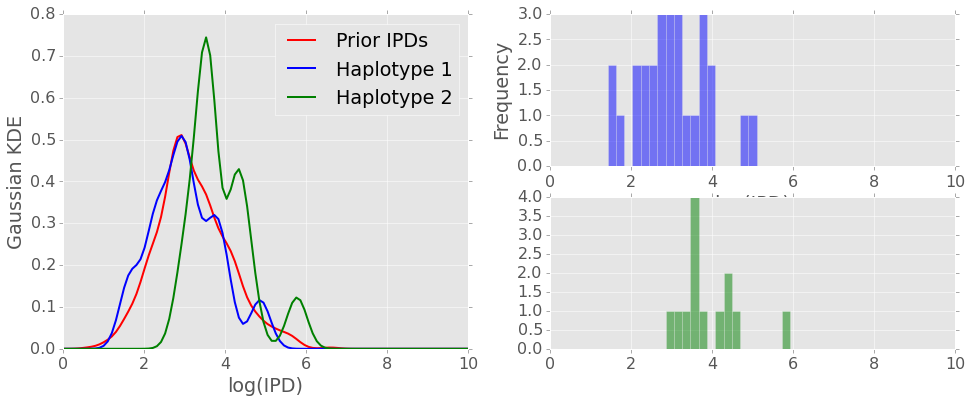

000000F 49043 motif: ATTGGGGGCCA n_prior: 651 n_hap1: 27 n_hap2: 13

======mixed======
two components:
	weight  : [ 0.48915463  0.51084537]
	means   : [[ 3.78031165  2.85763921]]
	AIC1:  115.265407325 	BIC1:  123.709804596
one component:
	weight  : [ 1.]
	means   : [[ 3.30896871]]
	AIC:  109.674152387 	BIC:  113.051911295
=====distribution comparisions======
ks test haps  : (0.55270655270655267, 0.0052371949011476857)
ks test hap1  : (0.11503669568185704, 0.86160362010834601)
ks test hap2  : (0.46980976013234077, 0.0044331570361044745)
[                  0%                  ]  36999 of 33000000 complete Elapsed: 2.4 minutes	 Remaining: 2168.2 minutes

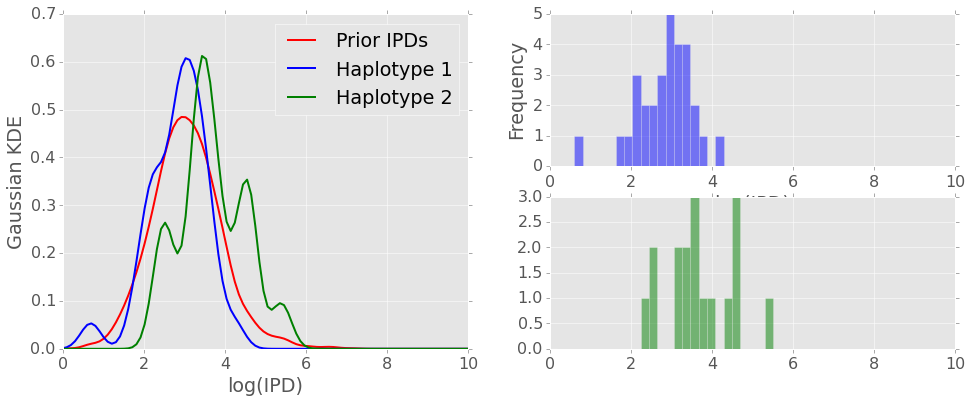

000000F 49264 motif: ATTATAAAGAC n_prior: 1874 n_hap1: 30 n_hap2: 17

======mixed======
two components:
	weight  : [ 0.4831484  0.5168516]
	means   : [[ 2.77405784  3.49212989]]
	AIC1:  126.981928948 	BIC1:  136.232666957
one component:
	weight  : [ 1.]
	means   : [[ 3.14519453]]
	AIC:  120.717017161 	BIC:  124.417312365
=====distribution comparisions======
ks test haps  : (0.49019607843137247, 0.0066132306811375208)
ks test hap1  : (0.16922803272856635, 0.33577904015509791)
ks test hap2  : (0.40463933705819566, 0.0053781529090165033)
[                  0%                  ]  37058 of 33000000 complete Elapsed: 2.5 minutes	 Remaining: 2199.0 minutes

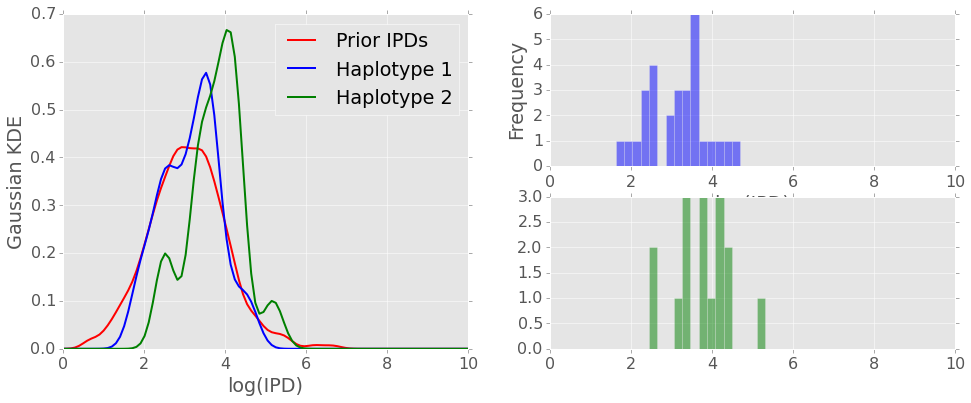

000000F 49320 motif: ACAGATAGCAT n_prior: 580 n_hap1: 29 n_hap2: 16

======mixed======
two components:
	weight  : [ 0.56412463  0.43587537]
	means   : [[ 3.76242867  2.87328455]]
	AIC1:  111.240728316 	BIC1:  120.274040765
one component:
	weight  : [ 1.]
	means   : [[ 3.37487265]]
	AIC:  105.953621129 	BIC:  109.566946109
=====distribution comparisions======
ks test haps  : (0.48706896551724133, 0.0092741723651978431)
ks test hap1  : (0.094827586206896464, 0.95595041913603318)
ks test hap2  : (0.4422413793103448, 0.0028445236483676094)
[                  0%                  ]  37335 of 33000000 complete Elapsed: 2.5 minutes	 Remaining: 2250.3 minutes

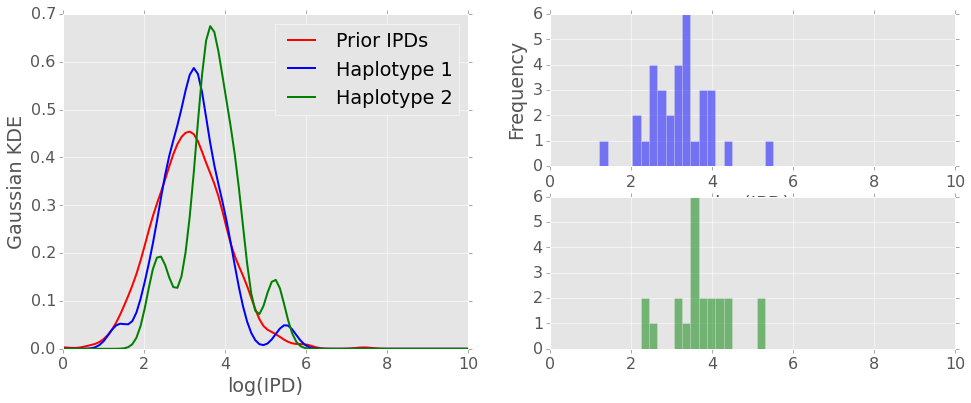

000000F 50050 motif: ATAAGCAACCT n_prior: 686 n_hap1: 32 n_hap2: 22

======mixed======
two components:
	weight  : [ 0.52229888  0.47770112]
	means   : [[ 3.74067762  3.03231936]]
	AIC1:  138.510257897 	BIC1:  148.45517813
one component:
	weight  : [ 1.]
	means   : [[ 3.40229409]]
	AIC:  132.548848557 	BIC:  136.52681665
=====distribution comparisions======
ks test haps  : (0.49147727272727271, 0.0021529866985654177)
ks test hap1  : (0.097212099125364437, 0.92168750680992839)
ks test hap2  : (0.42724622316459049, 0.00050984046119515293)
[                  0%                  ]  38065 of 33000000 complete Elapsed: 2.6 minutes	 Remaining: 2268.5 minutes

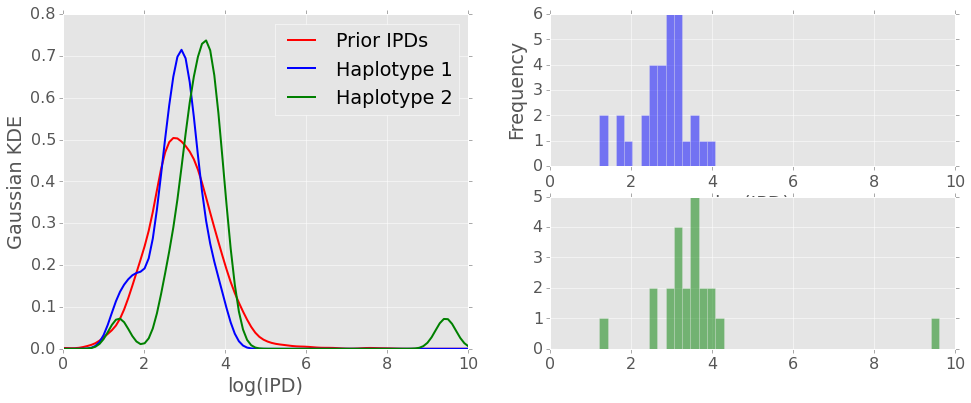

000000F 50542 motif: GCATGGTACTG n_prior: 2000 n_hap1: 32 n_hap2: 22

======mixed======
two components:
	weight  : [ 0.98148148  0.01851852]
	means   : [[ 2.98454353  9.43970454]]
	AIC1:  120.479479674 	BIC1:  130.424399907
one component:
	weight  : [ 1.]
	means   : [[ 3.10408355]]
	AIC:  166.123799598 	BIC:  170.101767691
=====distribution comparisions======
ks test haps  : (0.45738636363636365, 0.0053765697828656988)
ks test hap1  : (0.1845, 0.21007575306350448)
ks test hap2  : (0.36113636363636364, 0.0048071066671250022)
[                  0%                  ]  38553 of 33000000 complete Elapsed: 2.6 minutes	 Remaining: 2261.2 minutes

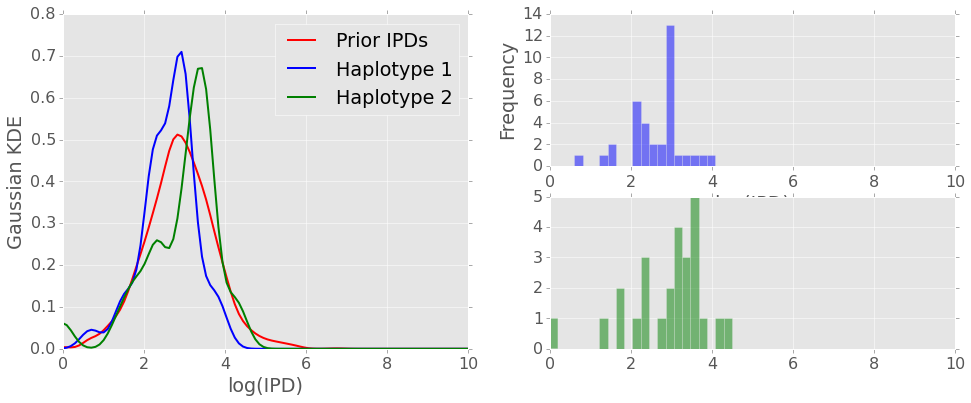

000000F 50820 motif: AAACCTAGGCA n_prior: 2000 n_hap1: 36 n_hap2: 26

======mixed======
two components:
	weight  : [ 0.6030451  0.3969549]
	means   : [[ 3.04653927  2.29173537]]
	AIC1:  150.658562808 	BIC1:  161.294234734
one component:
	weight  : [ 1.]
	means   : [[ 2.74691616]]
	AIC:  150.178256759 	BIC:  154.432525529
=====distribution comparisions======
ks test haps  : (0.43803418803418809, 0.0038838734684388393)
ks test hap1  : (0.27211111111111119, 0.0083077754414533495)
ks test hap2  : (0.19746153846153847, 0.24082988072037884)
[                  0%                  ]  38557 of 33000000 complete Elapsed: 2.7 minutes	 Remaining: 2287.9 minutes

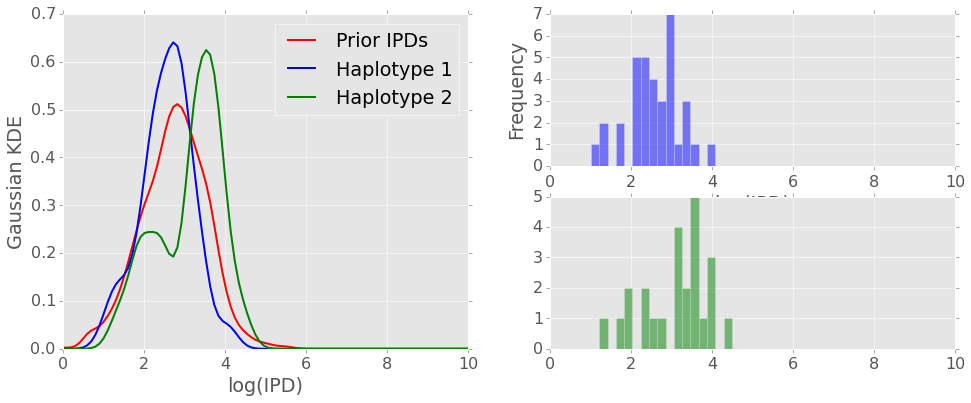

000000F 50960 motif: TTGTCAGATTG n_prior: 869 n_hap1: 35 n_hap2: 24

======mixed======
two components:
	weight  : [ 0.47685038  0.52314962]
	means   : [[ 2.33911208  3.20604539]]
	AIC1:  141.837582364 	BIC1:  152.225269584
one component:
	weight  : [ 1.]
	means   : [[ 2.79264791]]
	AIC:  136.693894286 	BIC:  140.848969174
=====distribution comparisions======
ks test haps  : (0.49523809523809531, 0.0010556685646987305)
ks test hap1  : (0.20256452408351144, 0.11058558937098073)
ks test hap2  : (0.36286919831223635, 0.0029495841029640226)
[                  0%                  ]  38835 of 33000000 complete Elapsed: 2.7 minutes	 Remaining: 2309.9 minutes

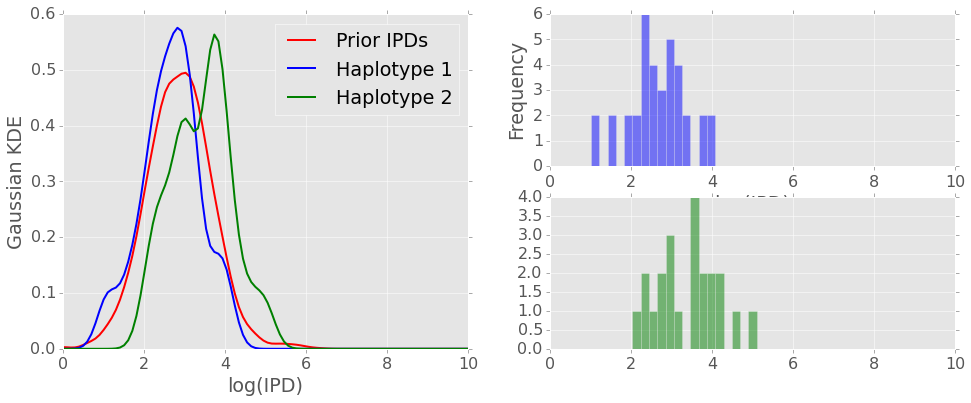

000000F 51121 motif: AAAAGAAGACA n_prior: 2000 n_hap1: 36 n_hap2: 22

======mixed======
two components:
	weight  : [ 0.49108328  0.50891672]
	means   : [[ 3.39017671  2.53360341]]
	AIC1:  149.131930152 	BIC1:  159.434145205
one component:
	weight  : [ 1.]
	means   : [[ 2.95425223]]
	AIC:  143.062115302 	BIC:  147.183001324
=====distribution comparisions======
ks test haps  : (0.43434343434343431, 0.0075579212444933427)
ks test hap1  : (0.15283333333333338, 0.35263212346939843)
ks test hap2  : (0.34150000000000003, 0.0090984237029158917)
[                  0%                  ]  39136 of 33000000 complete Elapsed: 2.8 minutes	 Remaining: 2362.0 minutes

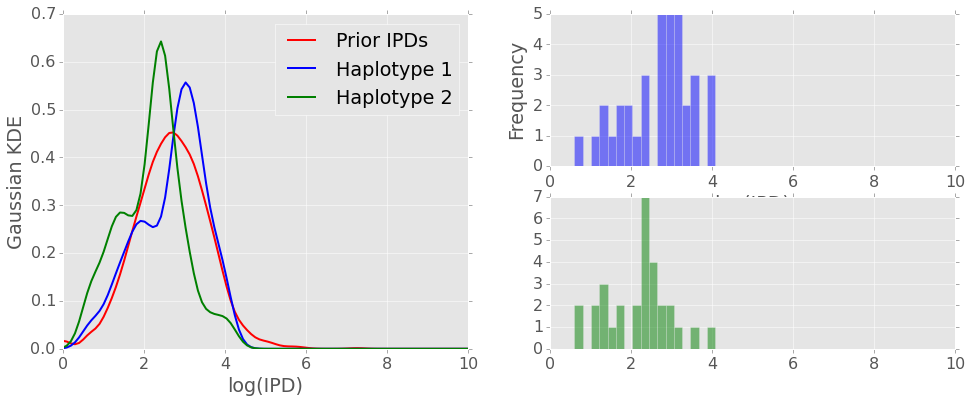

000000F 52061 motif: TAGAATAAAGT n_prior: 1427 n_hap1: 36 n_hap2: 30

======mixed======
two components:
	weight  : [ 0.58864015  0.41135985]
	means   : [[ 2.89669872  1.83907901]]
	AIC1:  172.076582168 	BIC1:  183.024855878
one component:
	weight  : [ 1.]
	means   : [[ 2.46163643]]
	AIC:  168.179526925 	BIC:  172.558836409
=====distribution comparisions======
ks test haps  : (0.41666666666666669, 0.0044730595350124585)
ks test hap1  : (0.12872771159386437, 0.57593589429196967)
ks test hap2  : (0.30845596823172161, 0.0055654487998170786)
[                  0%                  ]  39581 of 33000000 complete Elapsed: 2.8 minutes	 Remaining: 2356.2 minutes

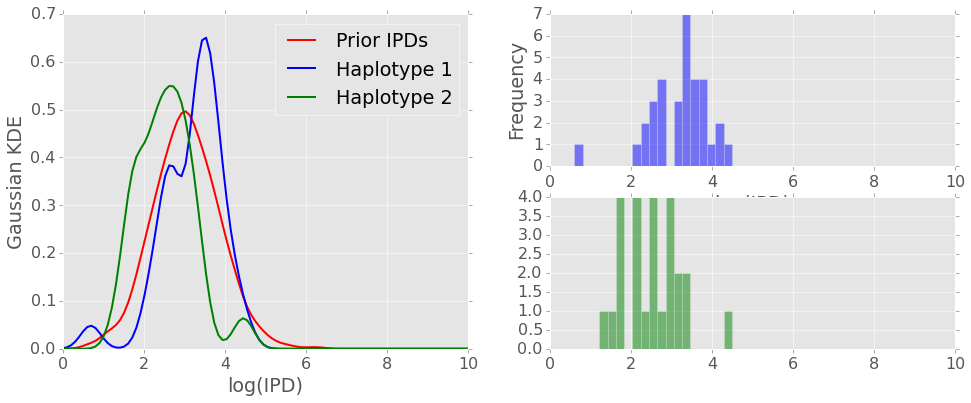

000000F 52128 motif: TTTCTGGAATT n_prior: 2000 n_hap1: 33 n_hap2: 25

======mixed======
two components:
	weight  : [ 0.50088616  0.49911384]
	means   : [[ 3.34507186  2.48756001]]
	AIC1:  144.665677224 	BIC1:  154.967892277
one component:
	weight  : [ 1.]
	means   : [[ 2.91707582]]
	AIC:  139.483886526 	BIC:  143.604772547
=====distribution comparisions======
ks test haps  : (0.48606060606060608, 0.0014017141556141998)
ks test hap1  : (0.21106060606060606, 0.096089524827276077)
ks test hap2  : (0.32200000000000001, 0.0088781541202895293)
[                  0%                  ]  40076 of 33000000 complete Elapsed: 2.9 minutes	 Remaining: 2373.5 minutes

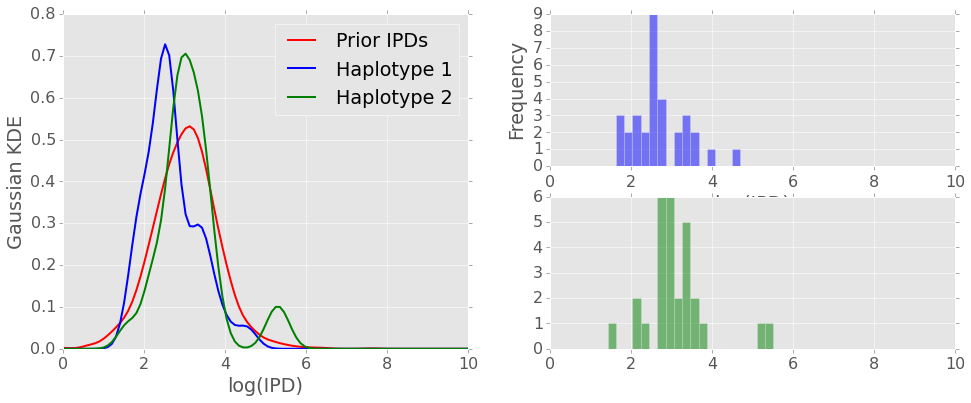

000000F 52607 motif: ATTAAGCATTT n_prior: 2000 n_hap1: 32 n_hap2: 28

======mixed======
two components:
	weight  : [ 0.81894698  0.18105302]
	means   : [[ 2.74802163  3.60367226]]
	AIC1:  134.043372402 	BIC1:  144.515095213
one component:
	weight  : [ 1.]
	means   : [[ 2.90293976]]
	AIC:  137.830058268 	BIC:  142.018747393
=====distribution comparisions======
ks test haps  : (0.45089285714285715, 0.0028672511498795596)
ks test hap1  : (0.34275, 0.00084198595652484854)
ks test hap2  : (0.17464285714285716, 0.33698865411907519)
[                  0%                  ]  40143 of 33000000 complete Elapsed: 2.9 minutes	 Remaining: 2398.3 minutes

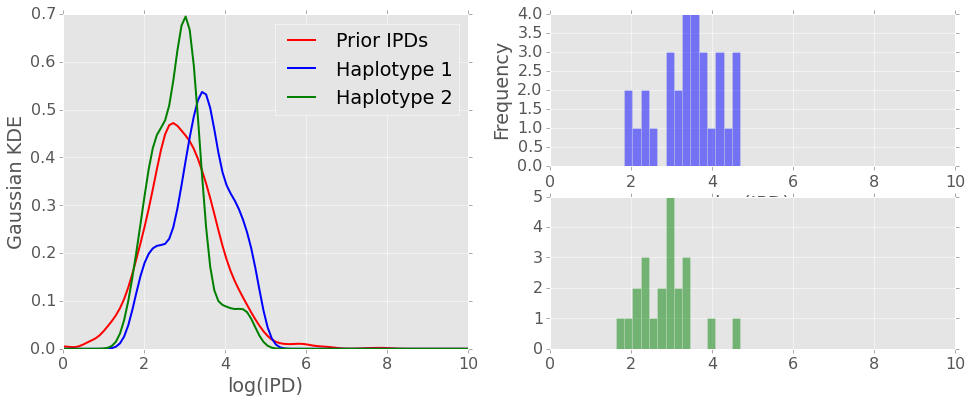

000000F 52699 motif: ATTTTTATGCA n_prior: 2000 n_hap1: 30 n_hap2: 22

======mixed======
two components:
	weight  : [ 0.47557409  0.52442591]
	means   : [[ 3.64389353  2.75774499]]
	AIC1:  126.841326035 	BIC1:  136.597544628
one component:
	weight  : [ 1.]
	means   : [[ 3.17917428]]
	AIC:  121.982021829 	BIC:  125.884509266
=====distribution comparisions======
ks test haps  : (0.46363636363636362, 0.0053243913674310599)
ks test hap1  : (0.29483333333333334, 0.0089698655523866334)
ks test hap2  : (0.19609090909090909, 0.33629929840936451)
[                  0%                  ]  40622 of 33000000 complete Elapsed: 3.0 minutes	 Remaining: 2411.9 minutes

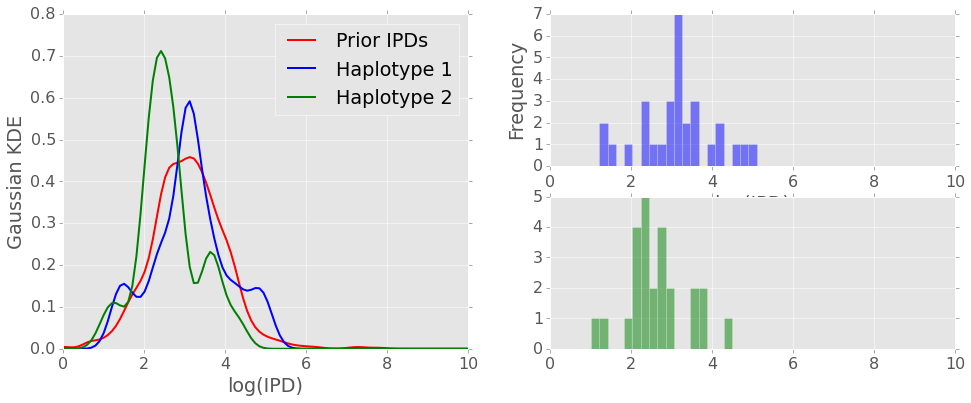

000000F 52979 motif: CCAGGTTTCAA n_prior: 875 n_hap1: 30 n_hap2: 25

======mixed======
two components:
	weight  : [ 0.44696937  0.55303063]
	means   : [[ 3.43069231  2.4822039 ]]
	AIC1:  150.206108098 	BIC1:  160.242774024
one component:
	weight  : [ 1.]
	means   : [[ 2.90614917]]
	AIC:  145.501485736 	BIC:  149.516152107
=====distribution comparisions======
ks test haps  : (0.5, 0.0012440510494735205)
ks test hap1  : (0.12742857142857145, 0.70426031894436969)
ks test hap2  : (0.37257142857142861, 0.0015809691646486304)
[                  0%                  ]  40714 of 33000000 complete Elapsed: 3.0 minutes	 Remaining: 2438.5 minutes

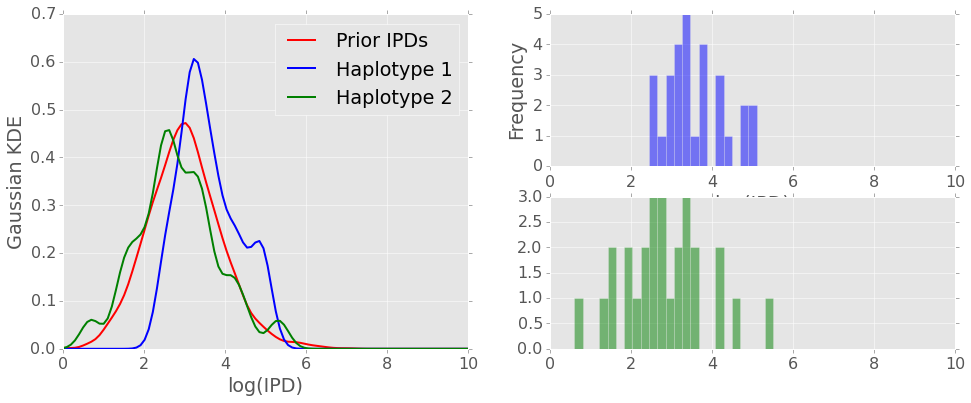

000000F 53169 motif: ATATTTATGTA n_prior: 2000 n_hap1: 29 n_hap2: 27

======mixed======
two components:
	weight  : [ 0.42636728  0.57363272]
	means   : [[ 3.80076711  2.8054262 ]]
	AIC1:  162.276540858 	BIC1:  172.403299312
one component:
	weight  : [ 1.]
	means   : [[ 3.229807]]
	AIC:  156.033207235 	BIC:  160.083910616
=====distribution comparisions======
ks test haps  : (0.42017879948914427, 0.0095960835510048442)
ks test hap1  : (0.34358620689655173, 0.0016359280728533087)
ks test hap2  : (0.1435555555555556, 0.60828422040341035)
[                  0%                  ]  40994 of 33000000 complete Elapsed: 3.1 minutes	 Remaining: 2458.4 minutes

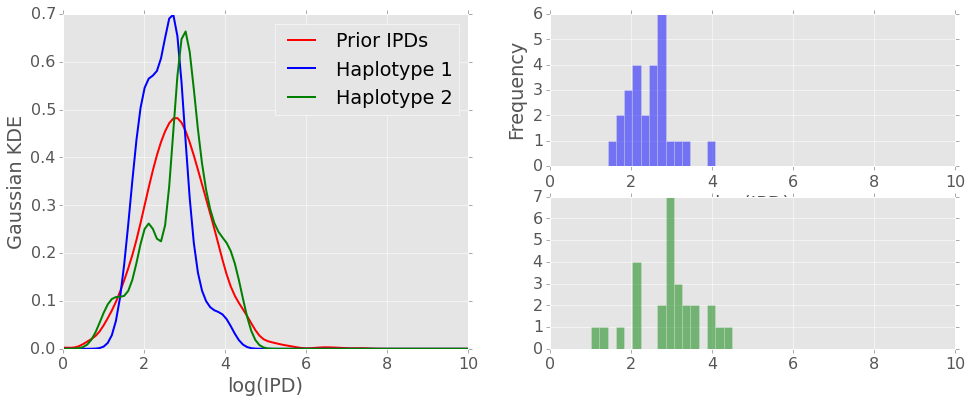

000000F 53419 motif: AATTAAAGAGT n_prior: 1645 n_hap1: 26 n_hap2: 27

======mixed======
two components:
	weight  : [ 0.56028155  0.43971845]
	means   : [[ 3.05792125  2.28215569]]
	AIC1:  123.264004228 	BIC1:  133.115463795
one component:
	weight  : [ 1.]
	means   : [[ 2.71680282]]
	AIC:  117.477256466 	BIC:  121.417840293
=====distribution comparisions======
ks test haps  : (0.51282051282051277, 0.0010484246505457571)
ks test hap1  : (0.32656067336918393, 0.0062440592946359404)
ks test hap2  : (0.20036023865811103, 0.2102657313402837)
[                  0%                  ]  41184 of 33000000 complete Elapsed: 3.1 minutes	 Remaining: 2479.7 minutes

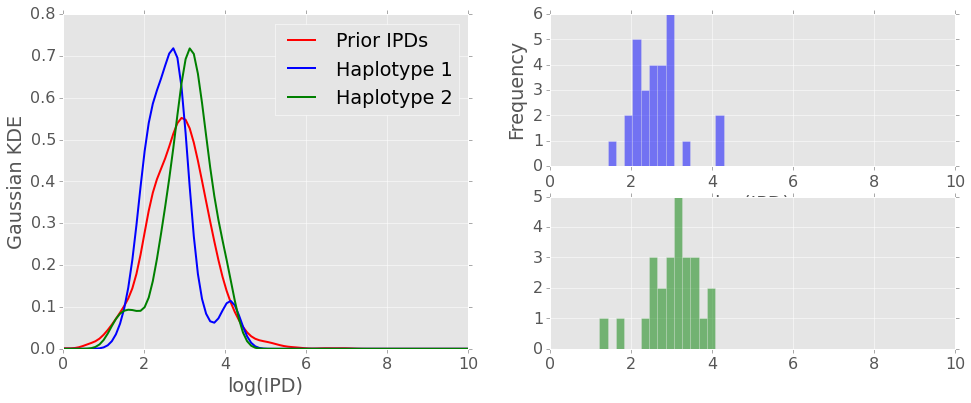

000000F 53858 motif: CAAGGCAAATG n_prior: 1573 n_hap1: 28 n_hap2: 25

======mixed======
two components:
	weight  : [ 0.53267005  0.46732995]
	means   : [[ 3.1509086   2.47455894]]
	AIC1:  111.54700625 	BIC1:  121.398465818
one component:
	weight  : [ 1.]
	means   : [[ 2.83483015]]
	AIC:  105.67101648 	BIC:  109.611600307
=====distribution comparisions======
ks test haps  : (0.46142857142857141, 0.0044905821542675951)
ks test hap1  : (0.31180183452910726, 0.0071019753419346472)
ks test hap2  : (0.21263827082008901, 0.18966841153289174)
[                  0%                  ]  41434 of 33000000 complete Elapsed: 3.1 minutes	 Remaining: 2504.4 minutes

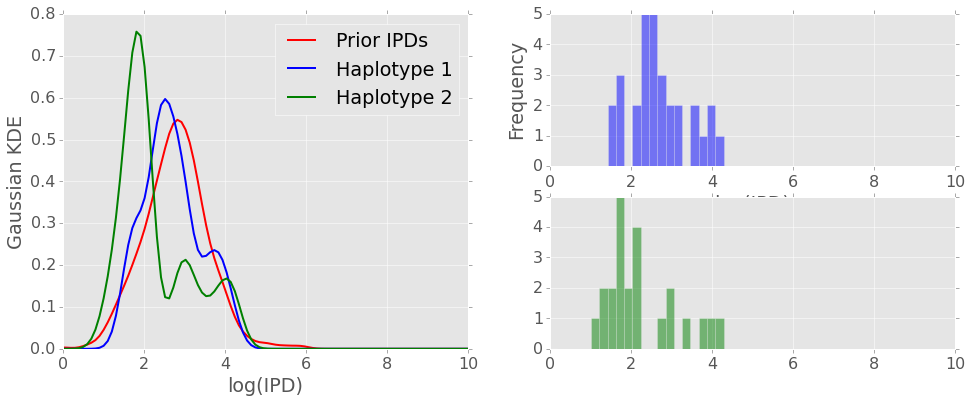

000000F 53958 motif: AGGTTTGAGTT n_prior: 645 n_hap1: 30 n_hap2: 23

======mixed======
two components:
	weight  : [ 0.43512657  0.56487343]
	means   : [[ 3.21522368  1.98966723]]
	AIC1:  129.275739297 	BIC1:  139.127198864
one component:
	weight  : [ 1.]
	means   : [[ 2.5229394]]
	AIC:  130.876432393 	BIC:  134.81701622
=====distribution comparisions======
ks test haps  : (0.49565217391304345, 0.0019337843369243188)
ks test hap1  : (0.13565891472868213, 0.63491344658308702)
ks test hap2  : (0.50185372430064035, 1.3891186280002175e-05)
[                  0%                  ]  41873 of 33000000 complete Elapsed: 3.2 minutes	 Remaining: 2517.6 minutes

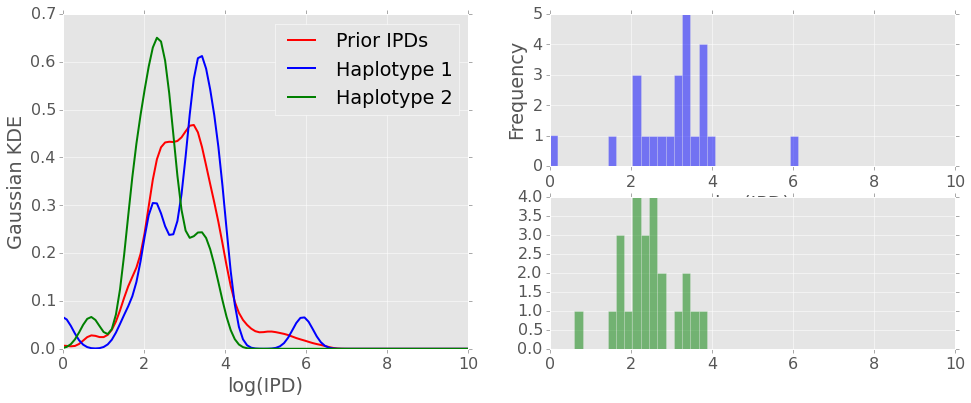

000000F 54304 motif: ACCCTTCCAAT n_prior: 306 n_hap1: 24 n_hap2: 24

======mixed======
two components:
	weight  : [ 0.47719496  0.52280504]
	means   : [[ 3.08194202  2.45180148]]
	AIC1:  141.188535833 	BIC1:  150.544540887
one component:
	weight  : [ 1.]
	means   : [[ 2.75250137]]
	AIC:  135.054503122 	BIC:  138.796905144
=====distribution comparisions======
ks test haps  : (0.45833333333333331, 0.0082303844459982196)
ks test hap1  : (0.18464052287581695, 0.39619343514572897)
ks test hap2  : (0.34150326797385622, 0.0080838165143257579)
[                  0%                  ]  42319 of 33000000 complete Elapsed: 3.3 minutes	 Remaining: 2556.5 minutes

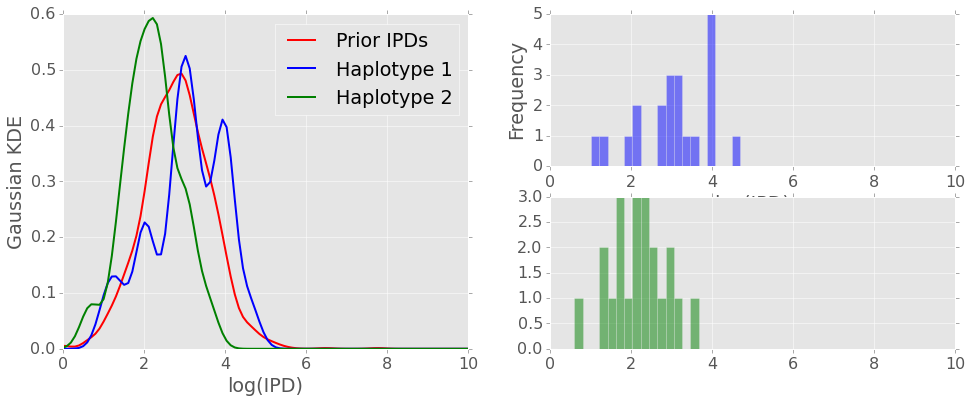

000000F 55047 motif: CAAATTAGAGA n_prior: 1475 n_hap1: 21 n_hap2: 21

======mixed======
two components:
	weight  : [ 0.4944056  0.5055944]
	means   : [[ 3.16129015  2.10362086]]
	AIC1:  119.568704009 	BIC1:  128.2570521
one component:
	weight  : [ 1.]
	means   : [[ 2.62653848]]
	AIC:  114.34247986 	BIC:  117.817819097
=====distribution comparisions======
ks test haps  : (0.52380952380952384, 0.0035912770642812755)
ks test hap1  : (0.19690072639225176, 0.36000611593913956)
ks test hap2  : (0.40122679580306697, 0.0016576405580645147)
[                  0%                  ]  42866 of 33000000 complete Elapsed: 3.3 minutes	 Remaining: 2543.1 minutes

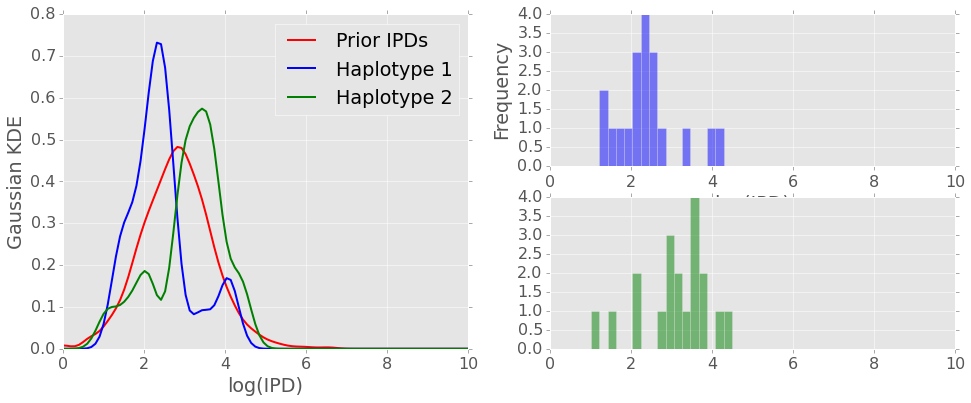

000000F 55510 motif: GTTACATAGGT n_prior: 2000 n_hap1: 19 n_hap2: 19

======mixed======
two components:
	weight  : [ 0.47555204  0.52444796]
	means   : [[ 3.47136458  2.13156556]]
	AIC1:  104.193536486 	BIC1:  112.381467285
one component:
	weight  : [ 1.]
	means   : [[ 2.76870972]]
	AIC:  100.952821366 	BIC:  104.227993685
=====distribution comparisions======
ks test haps  : (0.63157894736842102, 0.00046624720931908879)
ks test hap1  : (0.38410526315789467, 0.0053062202911401445)
ks test hap2  : (0.28047368421052632, 0.084598709566795091)
[                  0%                  ]  43062 of 33000000 complete Elapsed: 3.3 minutes	 Remaining: 2563.0 minutes

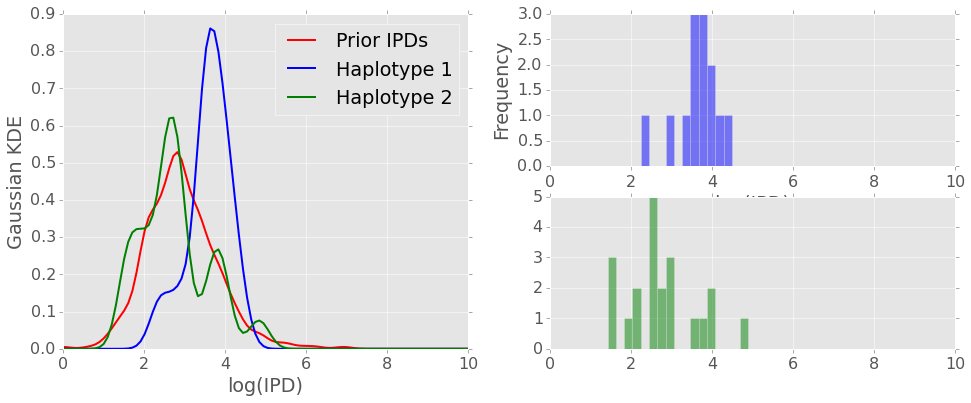

000000F 55747 motif: ACTAATATGCC n_prior: 397 n_hap1: 13 n_hap2: 21

======mixed======
two components:
	weight  : [ 0.52928592  0.47071408]
	means   : [[ 2.43716783  3.80981812]]
	AIC1:  90.0624512702 	BIC1:  97.6942538932
one component:
	weight  : [ 1.]
	means   : [[ 3.08329365]]
	AIC:  87.7444573422 	BIC:  90.7971783914
=====distribution comparisions======
ks test haps  : (0.60805860805860801, 0.0026622248378455611)
ks test hap1  : (0.56403797713621395, 0.00033130400902627196)
ks test hap2  : (0.16996521530526565, 0.57096942813388463)
[                  0%                  ]  43525 of 33000000 complete Elapsed: 3.4 minutes	 Remaining: 2580.0 minutes

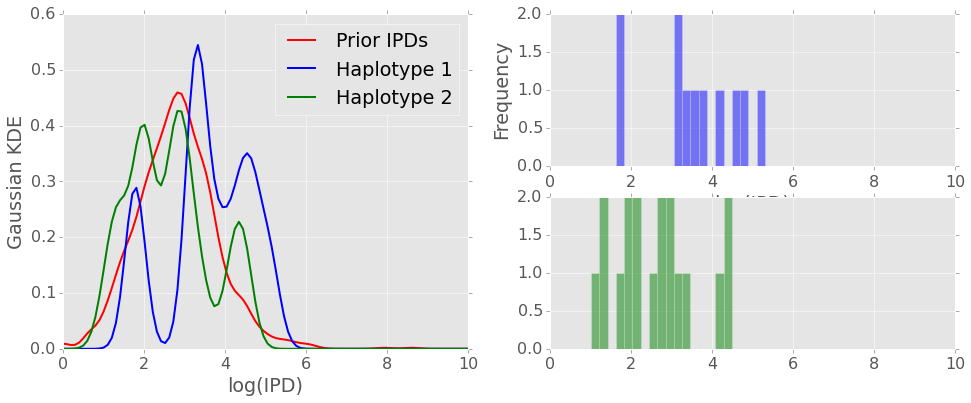

000000F 56182 motif: CTGAGAGGACA n_prior: 1091 n_hap1: 11 n_hap2: 18

======mixed======
two components:
	weight  : [ 0.51296048  0.48703952]
	means   : [[ 3.81892421  2.11969252]]
	AIC1:  95.5073652692 	BIC1:  102.343844419
one component:
	weight  : [ 1.]
	means   : [[ 2.99133122]]
	AIC:  92.0736855796 	BIC:  94.8082772395
=====distribution comparisions======
ks test haps  : (0.59595959595959602, 0.0084201373246678823)
ks test hap1  : (0.50012498958420126, 0.0051297756846552861)
ks test hap2  : (0.17313372033811997, 0.62067182246403962)
[                  0%                  ]  43762 of 33000000 complete Elapsed: 3.4 minutes	 Remaining: 2597.3 minutes

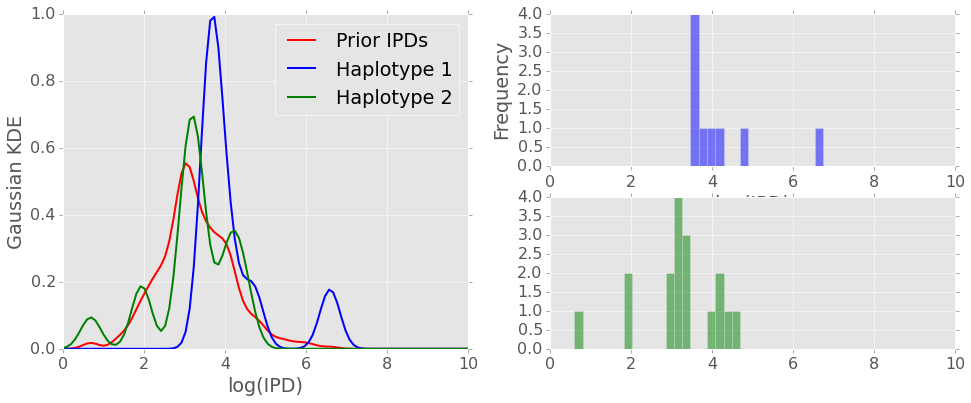

000000F 56680 motif: GTATGCTTGCC n_prior: 340 n_hap1: 9 n_hap2: 17

======mixed======
two components:
	weight  : [ 0.73164722  0.26835278]
	means   : [[ 3.65538163  3.23401519]]
	AIC1:  77.3008633769 	BIC1:  83.5913460671
one component:
	weight  : [ 1.]
	means   : [[ 3.54230678]]
	AIC:  80.0257405565 	BIC:  82.5419336325
=====distribution comparisions======
ks test haps  : (0.70588235294117652, 0.0024842800231236689)
ks test hap1  : (0.6470588235294118, 0.00058212742553642965)
ks test hap2  : (0.14999999999999999, 0.82859293163150061)
[                  0%                  ]  44695 of 33000000 complete Elapsed: 3.6 minutes	 Remaining: 2621.1 minutes

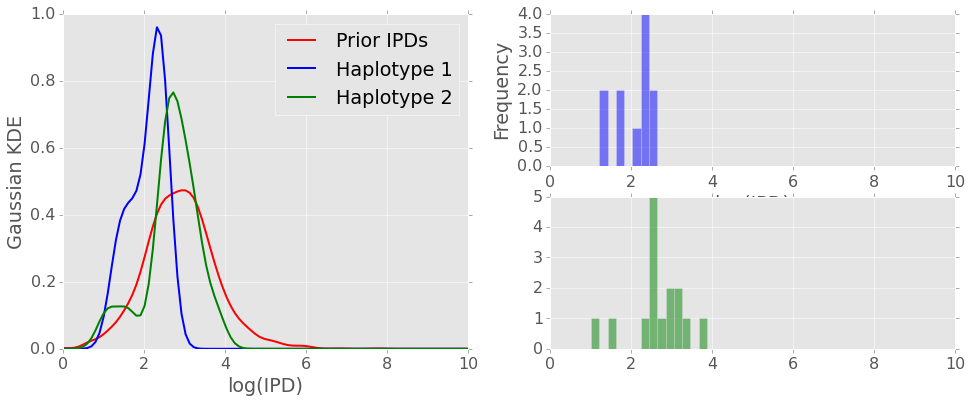

000000F 57364 motif: TAAAAATGCAA n_prior: 2000 n_hap1: 11 n_hap2: 15

======mixed======
two components:
	weight  : [ 0.66013169  0.33986831]
	means   : [[ 2.69473816  1.90797009]]
	AIC1:  58.7263833715 	BIC1:  65.0168660616
one component:
	weight  : [ 1.]
	means   : [[ 2.42734062]]
	AIC:  53.3640332411 	BIC:  55.8802263171
=====distribution comparisions======
ks test haps  : (0.73333333333333339, 0.00086896754946855649)
ks test hap1  : (0.66249999999999998, 5.4324995722127015e-05)
ks test hap2  : (0.20933333333333337, 0.48247584708698882)
[                  0%                  ]  60392 of 33000000 complete Elapsed: 4.0 minutes	 Remaining: 2193.0 minutes

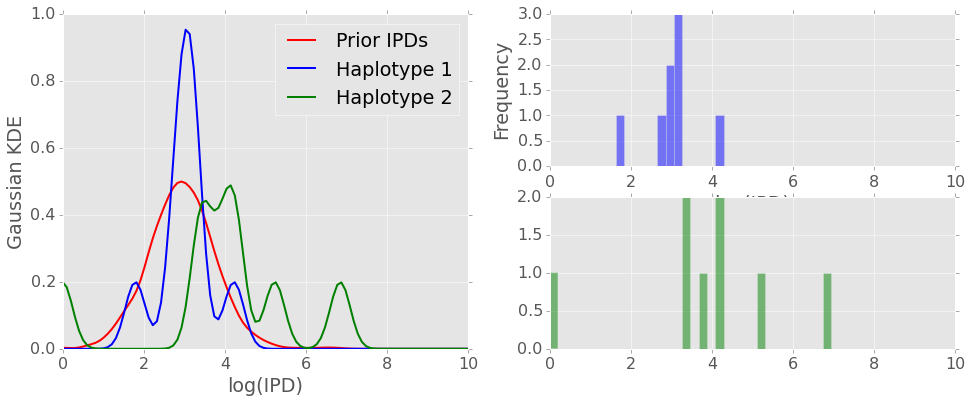

000000F 73129 motif: GGAAACAACAG n_prior: 2000 n_hap1: 8 n_hap2: 8

======mixed======
two components:
	weight  : [ 0.55663324  0.44336676]
	means   : [[ 3.0292187  4.021754 ]]
	AIC1:  66.7778319096 	BIC1:  70.6407755208
one component:
	weight  : [ 1.]
	means   : [[ 3.46927586]]
	AIC:  60.7181572518 	BIC:  62.2633346963
=====distribution comparisions======
ks test haps  : (0.75, 0.0097664126462329096)
ks test hap1  : (0.27500000000000002, 0.51199897823241991)
ks test hap2  : (0.57499999999999996, 0.0055946811641286853)
[                  0%                  ]  60976 of 33000000 complete Elapsed: 4.0 minutes	 Remaining: 2185.5 minutes

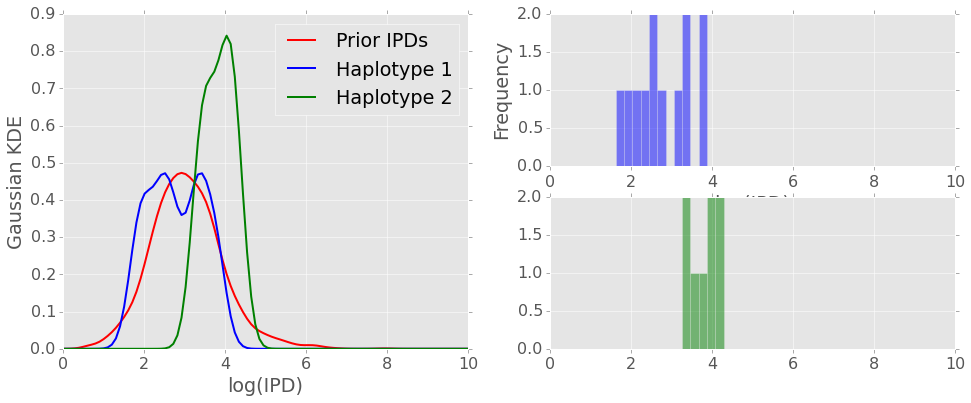

000000F 73261 motif: TTTGACCCAGC n_prior: 2000 n_hap1: 12 n_hap2: 8

======mixed======
two components:
	weight  : [ 0.65648028  0.34351972]
	means   : [[ 3.69355522  2.31190973]]
	AIC1:  49.5996110237 	BIC1:  54.5782723915
one component:
	weight  : [ 1.]
	means   : [[ 3.21893275]]
	AIC:  49.3449961875 	BIC:  51.3364607346
=====distribution comparisions======
ks test haps  : (0.70833333333333337, 0.0074391837592762706)
ks test hap1  : (0.16449999999999998, 0.87325676929403617)
ks test hap2  : (0.65949999999999998, 0.00087538653159120045)
[                  0%                  ]  61119 of 33000000 complete Elapsed: 4.1 minutes	 Remaining: 2199.9 minutes

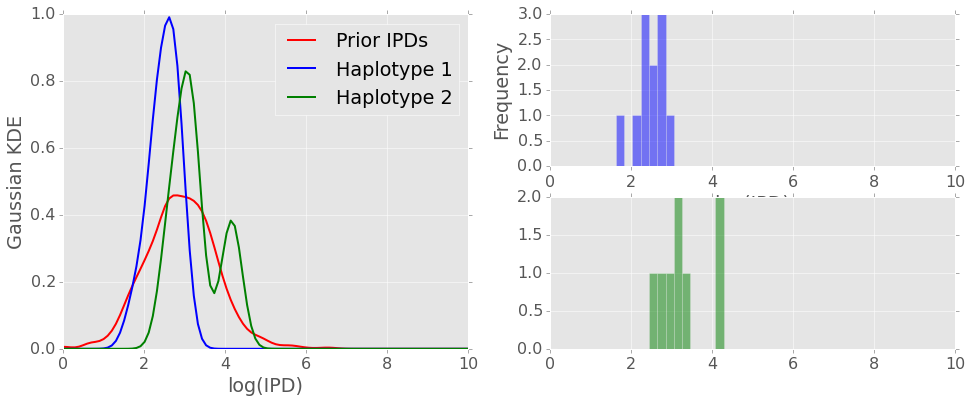

000000F 73480 motif: TTTGTAGGGAC n_prior: 2000 n_hap1: 11 n_hap2: 8

======mixed======
two components:
	weight  : [ 0.89486584  0.10513416]
	means   : [[ 2.66929649  4.16427942]]
	AIC1:  32.6717043783 	BIC1:  37.3938992742
one component:
	weight  : [ 1.]
	means   : [[ 2.82647026]]
	AIC:  37.2173050298 	BIC:  39.1061829882
=====distribution comparisions======
ks test haps  : (0.75, 0.0046129467801598479)
ks test hap1  : (0.50449999999999995, 0.0044999166020556298)
ks test hap2  : (0.312, 0.35226597957768513)
[                  0%                  ]  61251 of 33000000 complete Elapsed: 4.1 minutes	 Remaining: 2216.6 minutes

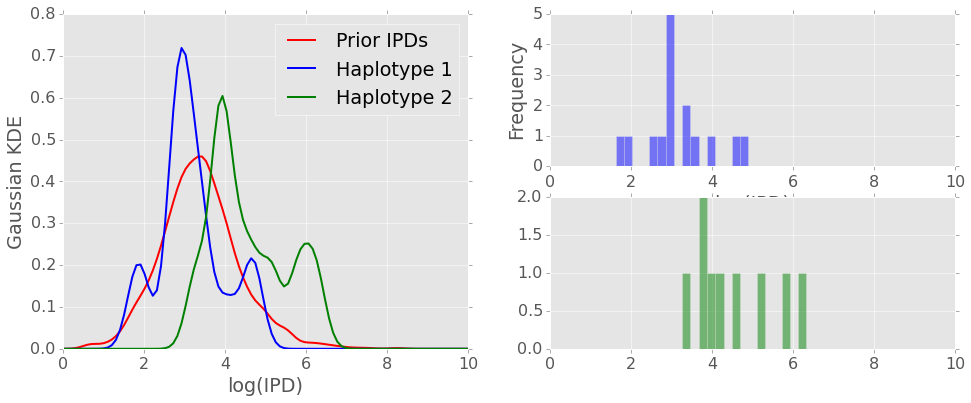

000000F 73967 motif: CTACCAAATAA n_prior: 1184 n_hap1: 15 n_hap2: 9

======mixed======
two components:
	weight  : [ 0.5458722  0.4541278]
	means   : [[ 3.13335935  4.3607211 ]]
	AIC1:  80.2953803704 	BIC1:  86.1856495222
one component:
	weight  : [ 1.]
	means   : [[ 3.69073844]]
	AIC:  76.0526486005 	BIC:  78.4087562612
=====distribution comparisions======
ks test haps  : (0.68888888888888888, 0.004422352632218858)
ks test hap1  : (0.22499999999999998, 0.39358187079960533)
ks test hap2  : (0.61355105105105112, 0.0011639655627170512)
[                  0%                  ]  61468 of 33000000 complete Elapsed: 4.2 minutes	 Remaining: 2230.4 minutes

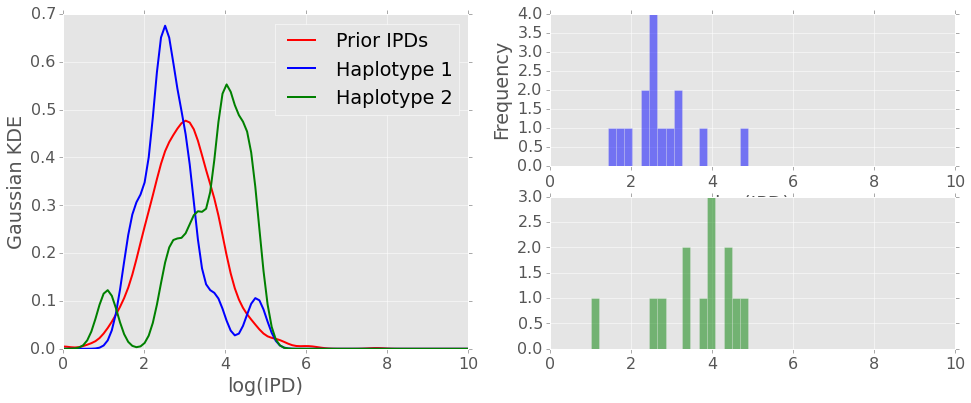

000000F 74260 motif: AGATTTGGGCT n_prior: 1237 n_hap1: 15 n_hap2: 13

======mixed======
two components:
	weight  : [ 0.671422  0.328578]
	means   : [[ 2.58504328  4.26846041]]
	AIC1:  84.1849023838 	BIC1:  90.8459249347
one component:
	weight  : [ 1.]
	means   : [[ 3.13817712]]
	AIC:  82.2708060895 	BIC:  84.9352151099
=====distribution comparisions======
ks test haps  : (0.63589743589743586, 0.0035162296995008848)
ks test hap1  : (0.27329560765292382, 0.18347534221138626)
ks test hap2  : (0.47795535103538339, 0.0033838658162658221)
[                  0%                  ]  61955 of 33000000 complete Elapsed: 4.2 minutes	 Remaining: 2241.1 minutes

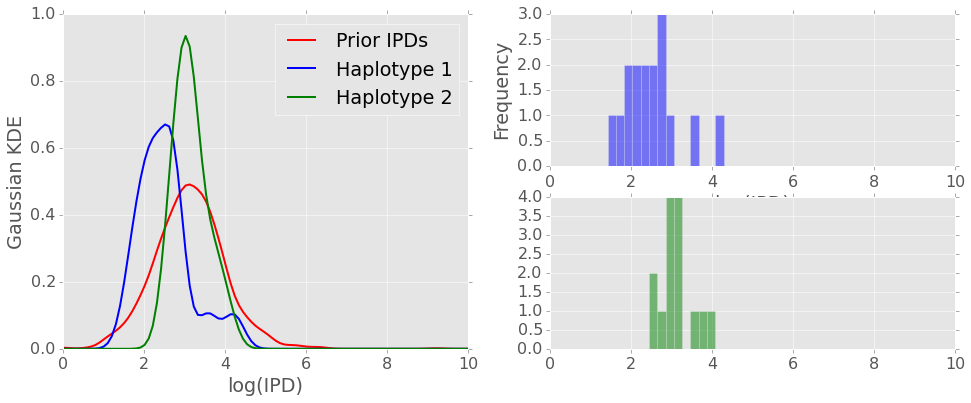

000000F 74304 motif: GAATGTAGGAA n_prior: 1254 n_hap1: 16 n_hap2: 14

======mixed======
two components:
	weight  : [ 0.50703017  0.49296983]
	means   : [[ 2.49381588  3.15462648]]
	AIC1:  66.6641707059 	BIC1:  73.6701576143
one component:
	weight  : [ 1.]
	means   : [[ 2.81957557]]
	AIC:  60.9345689481 	BIC:  63.7369637115
=====distribution comparisions======
ks test haps  : (0.66964285714285721, 0.0011007388813880437)
ks test hap1  : (0.4826555023923445, 0.00072840718475076182)
ks test hap2  : (0.25438596491228072, 0.28687203774195286)
[                  0%                  ]  62865 of 33000000 complete Elapsed: 4.3 minutes	 Remaining: 2264.5 minutes

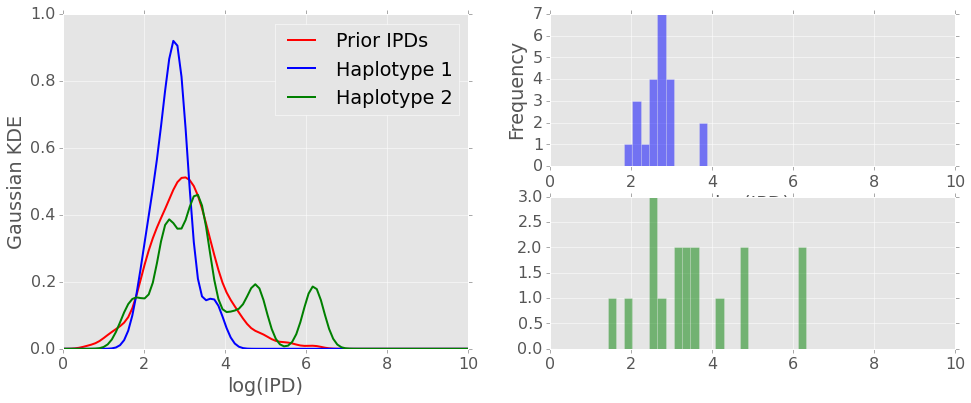

000000F 75532 motif: TCTAGGGCTGG n_prior: 466 n_hap1: 22 n_hap2: 17

======mixed======
two components:
	weight  : [ 0.82666513  0.17333487]
	means   : [[ 2.73652146  4.66244026]]
	AIC1:  99.1564158711 	BIC1:  107.474224102
one component:
	weight  : [ 1.]
	means   : [[ 3.07035035]]
	AIC:  113.79222469 	BIC:  117.119347983
=====distribution comparisions======
ks test haps  : (0.55614973262032086, 0.0028801044513424392)
ks test hap1  : (0.38548575887631675, 0.0026086232347560592)
ks test hap2  : (0.20828073718757889, 0.42936972308635285)
[                  0%                  ]  63351 of 33000000 complete Elapsed: 4.3 minutes	 Remaining: 2260.1 minutes

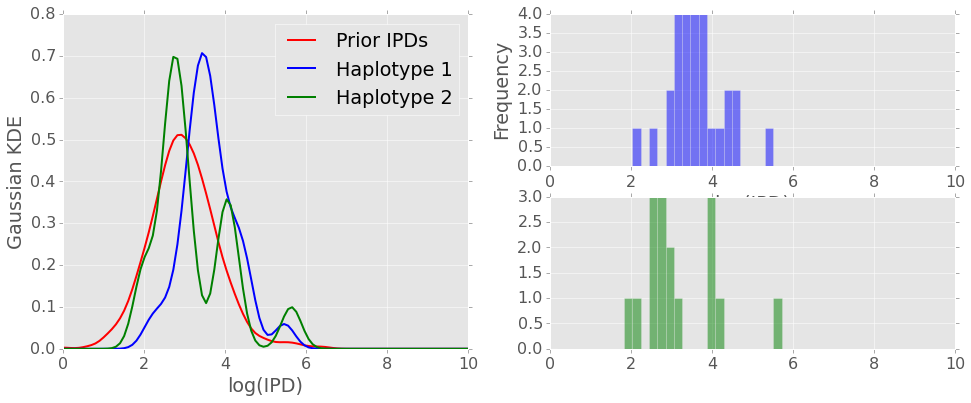

000000F 75626 motif: AAGTACTATTT n_prior: 1450 n_hap1: 27 n_hap2: 16

======mixed======
two components:
	weight  : [ 0.57922013  0.42077987]
	means   : [[ 3.11875572  3.9281935 ]]
	AIC1:  110.46342869 	BIC1:  119.269429268
one component:
	weight  : [ 1.]
	means   : [[ 3.45935084]]
	AIC:  106.055453007 	BIC:  109.577853238
=====distribution comparisions======
ks test haps  : (0.50231481481481488, 0.0075688707547131853)
ks test hap1  : (0.43688378033205616, 4.5921642699298149e-05)
ks test hap2  : (0.1973275862068965, 0.52133837392840532)
[                  0%                  ]  63520 of 33000000 complete Elapsed: 4.4 minutes	 Remaining: 2276.2 minutes

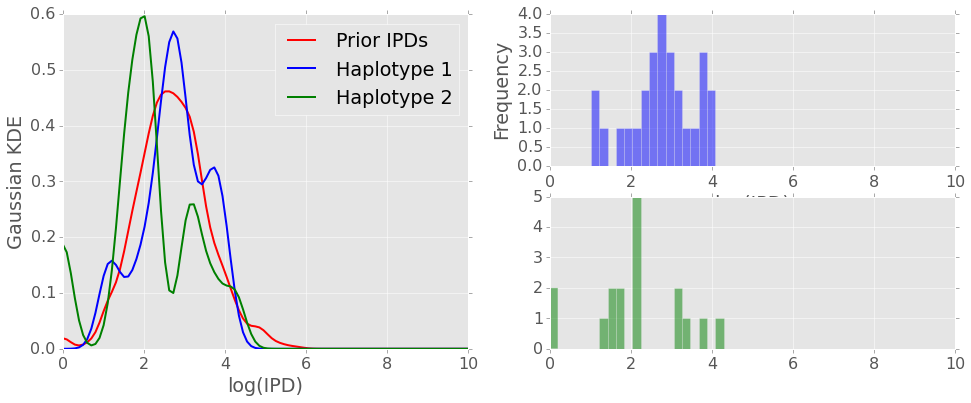

000000F 75906 motif: CATTTACAGGT n_prior: 630 n_hap1: 27 n_hap2: 17

======mixed======
two components:
	weight  : [ 0.46375718  0.53624282]
	means   : [[ 1.95965885  2.99018612]]
	AIC1:  131.487891172 	BIC1:  140.408839342
one component:
	weight  : [ 1.]
	means   : [[ 2.5122717]]
	AIC:  126.886504719 	BIC:  130.454883987
=====distribution comparisions======
ks test haps  : (0.48366013071895431, 0.0094275691755261373)
ks test hap1  : (0.098412698412698452, 0.95376667531720849)
ks test hap2  : (0.40588235294117653, 0.0057291312114403012)
[                  0%                  ]  63894 of 33000000 complete Elapsed: 4.5 minutes	 Remaining: 2304.5 minutes

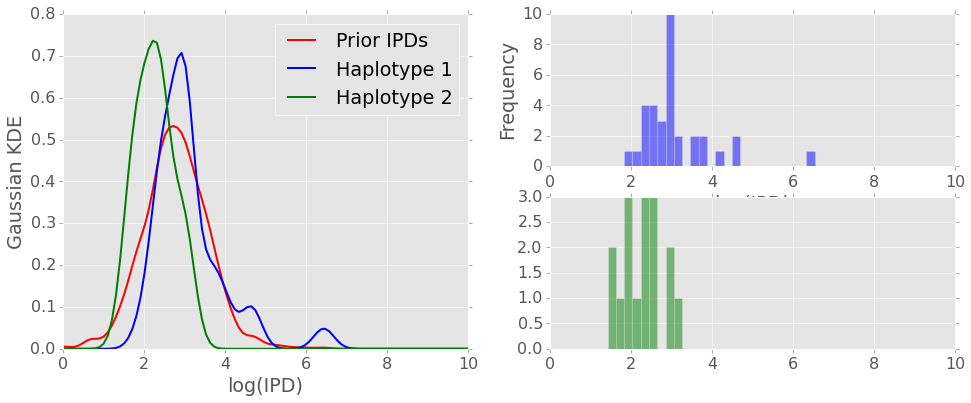

000000F 76842 motif: AATTTCACCCC n_prior: 759 n_hap1: 33 n_hap2: 16

======mixed======
two components:
	weight  : [ 0.2055989  0.7944011]
	means   : [[ 3.80459049  2.59994109]]
	AIC1:  115.825364142 	BIC1:  125.284465633
one component:
	weight  : [ 1.]
	means   : [[ 2.84761569]]
	AIC:  127.111959929 	BIC:  130.895600525
=====distribution comparisions======
ks test haps  : (0.53977272727272729, 0.0020563088374255844)
ks test hap1  : (0.17786561264822134, 0.24408974764849306)
ks test hap2  : (0.40933794466403162, 0.0070310763645020612)
[                  0%                  ]  64445 of 33000000 complete Elapsed: 4.5 minutes	 Remaining: 2297.5 minutes

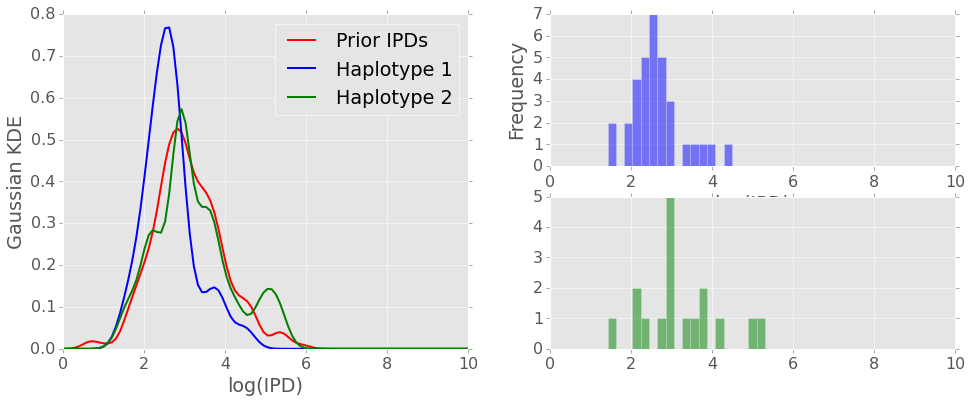

000000F 77162 motif: AACGGGTGAAA n_prior: 236 n_hap1: 33 n_hap2: 17

======mixed======
two components:
	weight  : [ 0.69287077  0.30712923]
	means   : [[ 2.50118478  3.60130501]]
	AIC1:  117.828518356 	BIC1:  127.388633383
one component:
	weight  : [ 1.]
	means   : [[ 2.83906386]]
	AIC:  122.646697639 	BIC:  126.47074365
=====distribution comparisions======
ks test haps  : (0.46524064171122997, 0.0098791759688241828)
ks test hap1  : (0.37326656394453012, 0.00040930406846415821)
ks test hap2  : (0.12113659022931206, 0.96377261049083296)
[                  0%                  ]  64830 of 33000000 complete Elapsed: 4.5 minutes	 Remaining: 2309.5 minutes

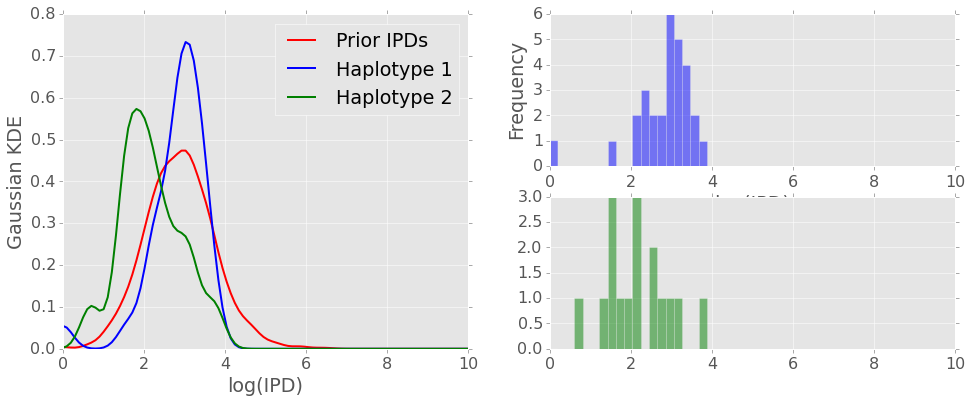

000000F 77330 motif: CTGGAACTCTT n_prior: 1410 n_hap1: 29 n_hap2: 16

======mixed======
two components:
	weight  : [ 0.413256  0.586744]
	means   : [[ 2.01381119  2.9879188 ]]
	AIC1:  109.893121872 	BIC1:  118.926434321
one component:
	weight  : [ 1.]
	means   : [[ 2.58536298]]
	AIC:  110.57706706 	BIC:  114.19039204
=====distribution comparisions======
ks test haps  : (0.50862068965517238, 0.0057039937785181355)
ks test hap1  : (0.14255319148936174, 0.57708813704550255)
ks test hap2  : (0.41241134751773051, 0.0061247319416921422)
[                  0%                  ]  65150 of 33000000 complete Elapsed: 4.6 minutes	 Remaining: 2321.4 minutes

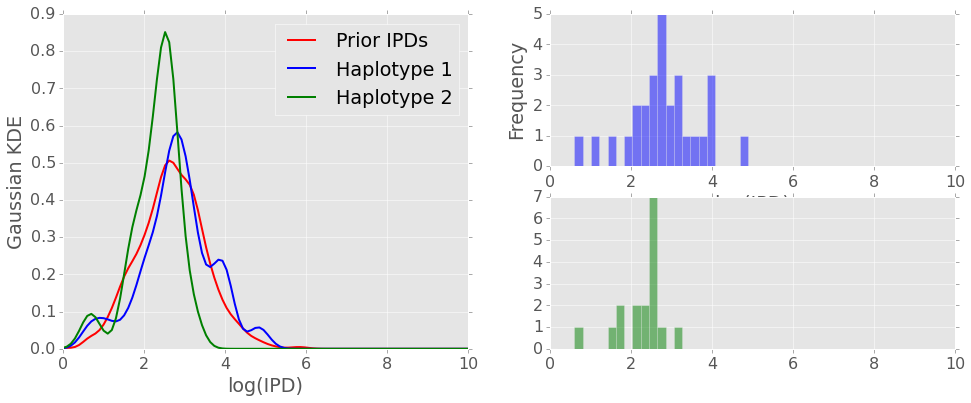

000000F 77461 motif: GTGGCTGCTCT n_prior: 797 n_hap1: 28 n_hap2: 17

======mixed======
two components:
	weight  : [ 0.43408514  0.56591486]
	means   : [[ 2.23123111  2.9126855 ]]
	AIC1:  119.63168066 	BIC1:  128.664993109
one component:
	weight  : [ 1.]
	means   : [[ 2.61687628]]
	AIC:  113.407001291 	BIC:  117.02032627
=====distribution comparisions======
ks test haps  : (0.48949579831932771, 0.007698921631456539)
ks test hap1  : (0.12457429646890128, 0.76764923511051786)
ks test hap2  : (0.39050852461436264, 0.0086017757632689592)
[                  0%                  ]  65318 of 33000000 complete Elapsed: 4.6 minutes	 Remaining: 2335.6 minutes

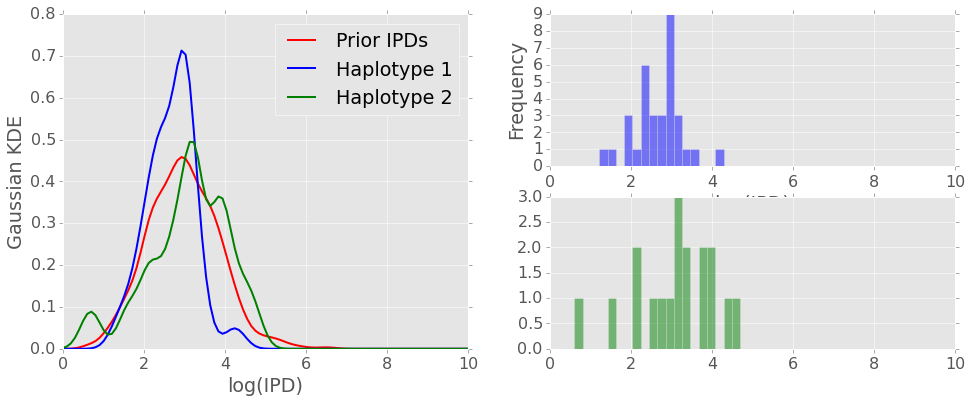

000000F 77722 motif: TTGCTTTCCTG n_prior: 2000 n_hap1: 33 n_hap2: 18

======mixed======
two components:
	weight  : [ 0.53066416  0.46933584]
	means   : [[ 3.15997362  2.44000374]]
	AIC1:  127.50689686 	BIC1:  137.166025024
one component:
	weight  : [ 1.]
	means   : [[ 2.82206595]]
	AIC:  121.199234077 	BIC:  125.062885342
=====distribution comparisions======
ks test haps  : (0.45959595959595961, 0.0093163495745644236)
ks test hap1  : (0.28228787878787875, 0.0087659596121635822)
ks test hap2  : (0.18661111111111112, 0.51924072282407385)
[                  0%                  ]  66292 of 33000000 complete Elapsed: 4.7 minutes	 Remaining: 2356.1 minutes

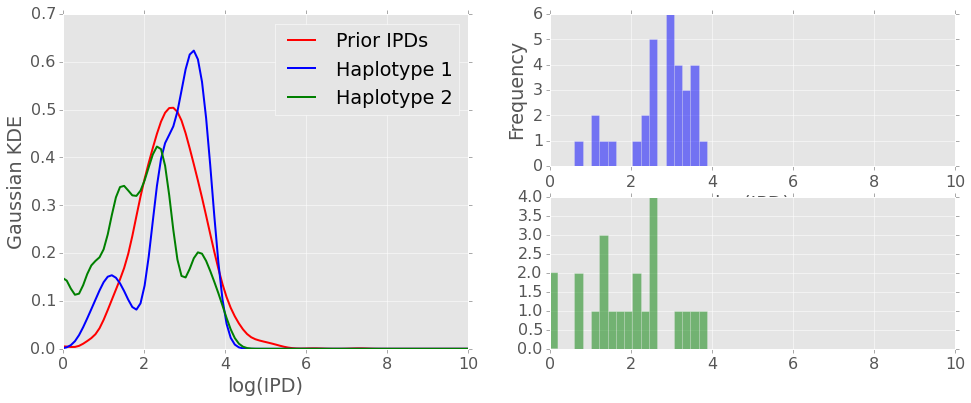

000000F 79116 motif: TAAATTGAATG n_prior: 1959 n_hap1: 31 n_hap2: 22

======mixed======
two components:
	weight  : [ 0.61140404  0.38859596]
	means   : [[ 2.98663265  1.44602022]]
	AIC1:  147.508774484 	BIC1:  157.360234052
one component:
	weight  : [ 1.]
	means   : [[ 2.38795688]]
	AIC:  152.038202687 	BIC:  155.978786514
=====distribution comparisions======
ks test haps  : (0.45014662756598239, 0.0069499653508731905)
ks test hap1  : (0.17482586573136388, 0.28061134726424936)
ks test hap2  : (0.34853125435054988, 0.0072789105457359993)
[                  0%                  ]  66931 of 33000000 complete Elapsed: 4.8 minutes	 Remaining: 2345.8 minutes

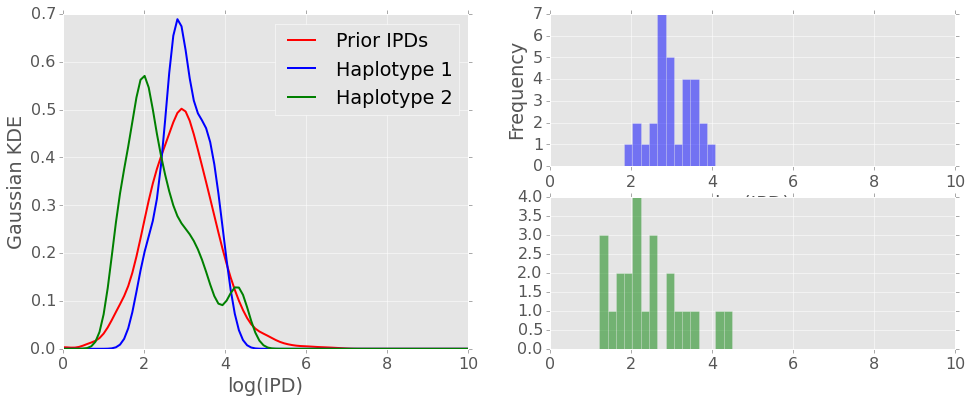

000000F 79580 motif: TAGTGTTTTTC n_prior: 1827 n_hap1: 30 n_hap2: 23

======mixed======
two components:
	weight  : [ 0.54479562  0.45520438]
	means   : [[ 3.16171925  2.28761665]]
	AIC1:  127.664741643 	BIC1:  137.516201211
one component:
	weight  : [ 1.]
	means   : [[ 2.76382392]]
	AIC:  122.526245117 	BIC:  126.466828944
=====distribution comparisions======
ks test haps  : (0.49565217391304345, 0.0019337843369243188)
ks test hap1  : (0.17821565407772305, 0.27735515424071294)
ks test hap2  : (0.35698817258037646, 0.0043003165651168389)
[                  0%                  ]  67104 of 33000000 complete Elapsed: 4.8 minutes	 Remaining: 2359.6 minutes

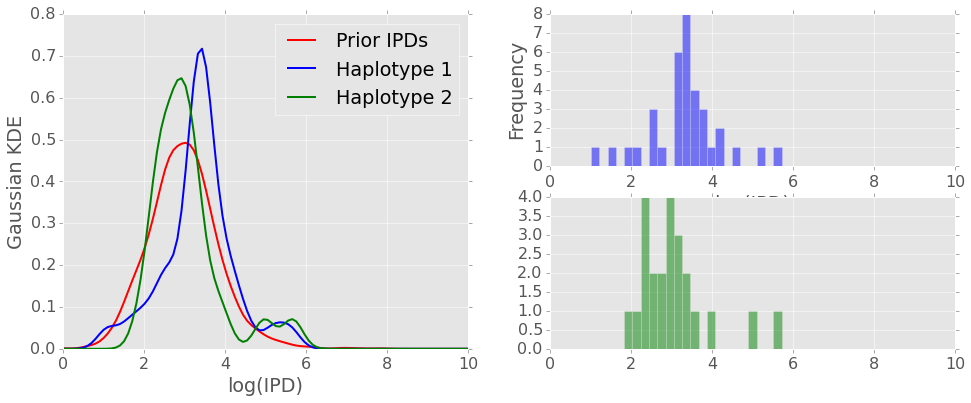

000000F 79844 motif: ATGAAAAACAA n_prior: 2000 n_hap1: 35 n_hap2: 23

======mixed======
two components:
	weight  : [ 0.72792742  0.27207258]
	means   : [[ 3.07029782  3.66312317]]
	AIC1:  152.009897643 	BIC1:  162.312112696
one component:
	weight  : [ 1.]
	means   : [[ 3.23158934]]
	AIC:  152.271024516 	BIC:  156.391910537
=====distribution comparisions======
ks test haps  : (0.42608695652173911, 0.0085734243040180534)
ks test hap1  : (0.32092857142857145, 0.0011924454872591103)
ks test hap2  : (0.13408695652173919, 0.7786109461997206)
[                  0%                  ]  69011 of 33000000 complete Elapsed: 5.0 minutes	 Remaining: 2367.6 minutes

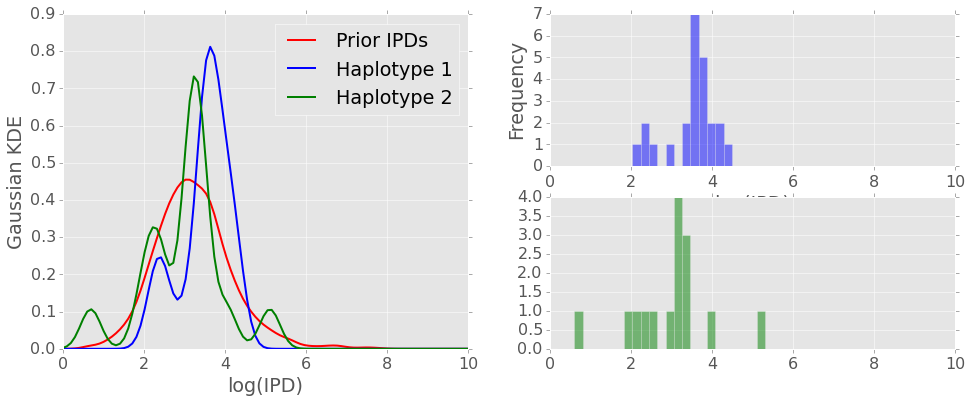

000000F 81635 motif: ATCTCCACTCA n_prior: 1450 n_hap1: 24 n_hap2: 15

======mixed======
two components:
	weight  : [ 0.5489688  0.4510312]
	means   : [[ 3.62524152  2.91844036]]
	AIC1:  95.3686371276 	BIC1:  103.686445358
one component:
	weight  : [ 1.]
	means   : [[ 3.30645214]]
	AIC:  97.0357647997 	BIC:  100.362888092
=====distribution comparisions======
ks test haps  : (0.57499999999999996, 0.0023473370155666132)
ks test hap1  : (0.37413793103448278, 0.0018176473404379308)
ks test hap2  : (0.22873563218390802, 0.37192760150728987)
[                  0%                  ]  69588 of 33000000 complete Elapsed: 5.0 minutes	 Remaining: 2359.8 minutes

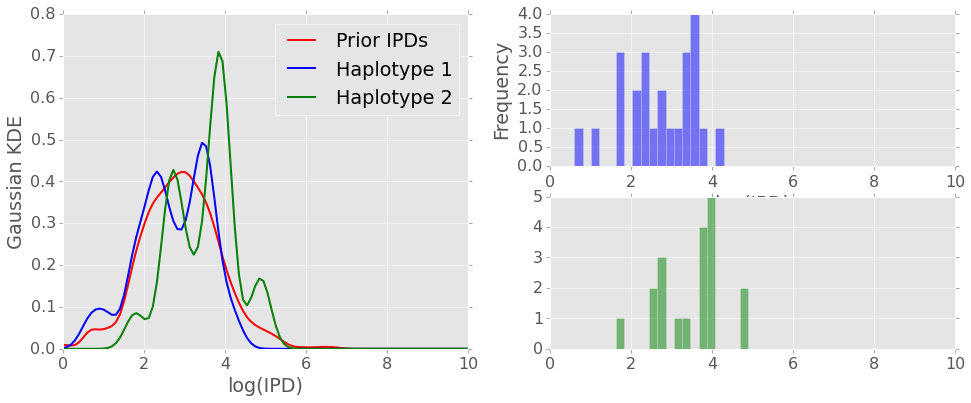

000000F 81692 motif: TCTCCTATGGC n_prior: 640 n_hap1: 24 n_hap2: 19

======mixed======
two components:
	weight  : [ 0.4601561  0.5398439]
	means   : [[ 2.4815329   3.55247929]]
	AIC1:  123.357207743 	BIC1:  132.163208321
one component:
	weight  : [ 1.]
	means   : [[ 3.05967677]]
	AIC:  118.807372339 	BIC:  122.32977257
=====distribution comparisions======
ks test haps  : (0.49561403508771928, 0.0066031334475713565)
ks test hap1  : (0.12604166666666661, 0.83068071248957309)
ks test hap2  : (0.3945723684210527, 0.0043026875286550437)
[                  0%                  ]  69623 of 33000000 complete Elapsed: 5.0 minutes	 Remaining: 2376.8 minutes

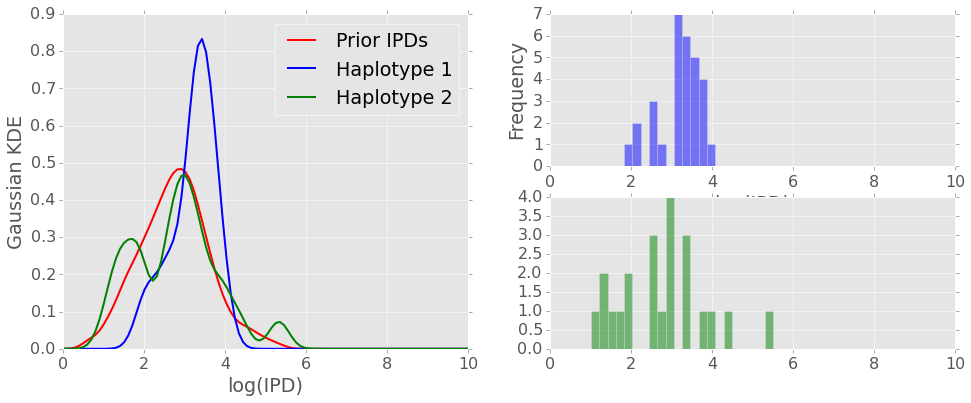

000000F 81783 motif: ACTTGTTTCTG n_prior: 986 n_hap1: 30 n_hap2: 22

======mixed======
two components:
	weight  : [ 0.48686522  0.51313478]
	means   : [[ 3.37403747  2.71032264]]
	AIC1:  126.981217852 	BIC1:  136.737436445
one component:
	weight  : [ 1.]
	means   : [[ 3.03346231]]
	AIC:  129.179918639 	BIC:  133.082406076
=====distribution comparisions======
ks test haps  : (0.44848484848484843, 0.007794803422140068)
ks test hap1  : (0.40966869506423259, 6.811218290989223e-05)
ks test hap2  : (0.11838465793841046, 0.90564005969700245)
[                  0%                  ]  69680 of 33000000 complete Elapsed: 5.1 minutes	 Remaining: 2391.2 minutes

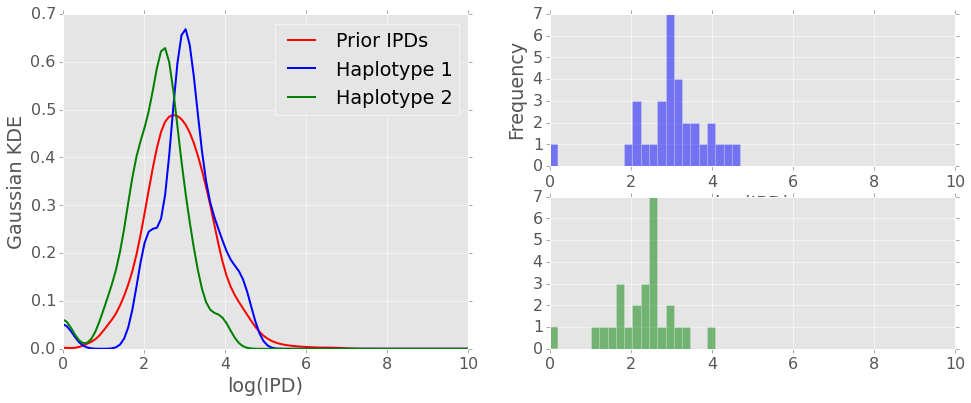

000000F 81892 motif: ATTATTTTATT n_prior: 2000 n_hap1: 31 n_hap2: 26

======mixed======
two components:
	weight  : [ 0.6441099  0.3558901]
	means   : [[ 2.85621566  2.36997859]]
	AIC1:  153.521212616 	BIC1:  163.736468955
one component:
	weight  : [ 1.]
	means   : [[ 2.6831687]]
	AIC:  151.844197515 	BIC:  155.93030005
=====distribution comparisions======
ks test haps  : (0.54342431761786603, 0.00024007790461871956)
ks test hap1  : (0.18643548387096776, 0.21458632114488049)
ks test hap2  : (0.3617307692307693, 0.0016537424292254303)
[                  0%                  ]  69771 of 33000000 complete Elapsed: 5.1 minutes	 Remaining: 2405.1 minutes

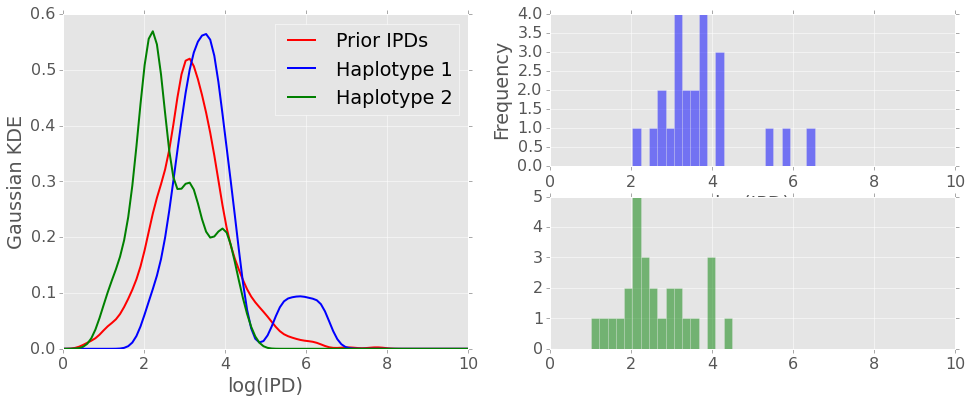

000000F 81972 motif: ACACATCCCAC n_prior: 774 n_hap1: 23 n_hap2: 27

======mixed======
two components:
	weight  : [ 0.64515198  0.35484802]
	means   : [[ 2.82778967  3.67648735]]
	AIC1:  153.095542287 	BIC1:  162.655657314
one component:
	weight  : [ 1.]
	means   : [[ 3.12894836]]
	AIC:  151.193481129 	BIC:  155.01752714
=====distribution comparisions======
ks test haps  : (0.51207729468599039, 0.0016758631088570131)
ks test hap1  : (0.26581283001909894, 0.070118059298163685)
ks test hap2  : (0.34969853574504733, 0.0023663692220354171)
[                  0%                  ]  69880 of 33000000 complete Elapsed: 5.1 minutes	 Remaining: 2420.1 minutes

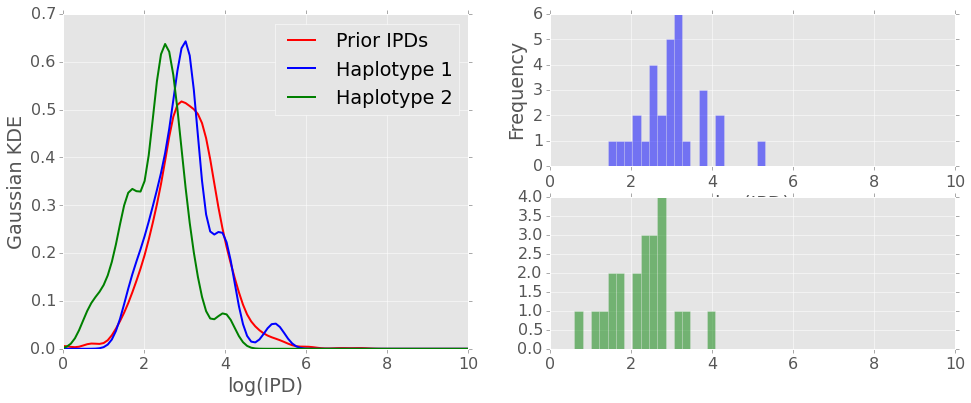

000000F 81981 motif: ACAGGGTCTTA n_prior: 1362 n_hap1: 30 n_hap2: 22

======mixed======
two components:
	weight  : [ 0.50984366  0.49015634]
	means   : [[ 2.36047223  3.07500662]]
	AIC1:  137.416480337 	BIC1:  147.17269893
one component:
	weight  : [ 1.]
	means   : [[ 2.71070579]]
	AIC:  131.450926475 	BIC:  135.353413912
=====distribution comparisions======
ks test haps  : (0.46363636363636362, 0.0053243913674310599)
ks test hap1  : (0.15873715124816457, 0.41764119266532856)
ks test hap2  : (0.46936323588305967, 7.9154938622818583e-05)
[                  0%                  ]  69960 of 33000000 complete Elapsed: 5.2 minutes	 Remaining: 2433.6 minutes

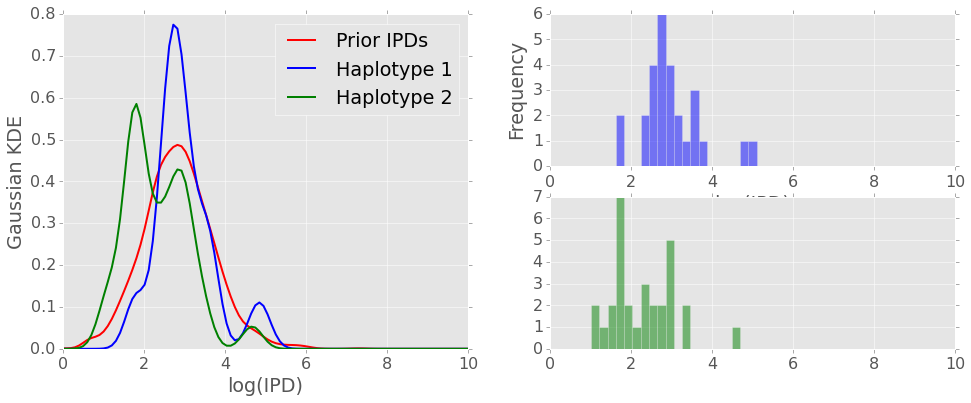

000000F 82131 motif: ATGCATTTCTC n_prior: 1942 n_hap1: 27 n_hap2: 30

======mixed======
two components:
	weight  : [ 0.49926961  0.50073039]
	means   : [[ 2.93939468  2.34714908]]
	AIC1:  145.892739011 	BIC1:  156.107995351
one component:
	weight  : [ 1.]
	means   : [[ 2.64283931]]
	AIC:  142.054249852 	BIC:  146.140352387
=====distribution comparisions======
ks test haps  : (0.45185185185185184, 0.0037803466704612737)
ks test hap1  : (0.21024526070870048, 0.16656467948161952)
ks test hap2  : (0.31527634740817029, 0.0041400350881832101)
[                  0%                  ]  69969 of 33000000 complete Elapsed: 5.2 minutes	 Remaining: 2448.4 minutes

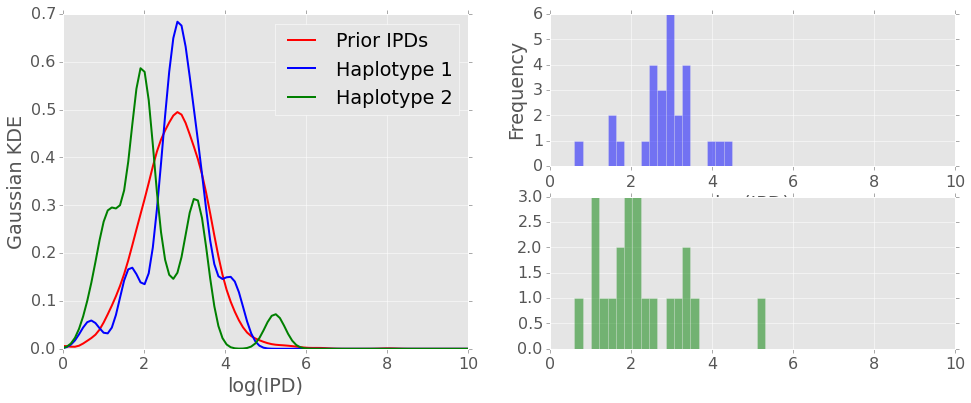

000000F 82156 motif: AATGAGGAAAT n_prior: 2000 n_hap1: 27 n_hap2: 22

======mixed======
two components:
	weight  : [ 0.4572336  0.5427664]
	means   : [[ 2.01087522  3.02692753]]
	AIC1:  142.847717632 	BIC1:  152.306819123
one component:
	weight  : [ 1.]
	means   : [[ 2.56235428]]
	AIC:  136.716883817 	BIC:  140.500524413
=====distribution comparisions======
ks test haps  : (0.49663299663299659, 0.0029712317508008867)
ks test hap1  : (0.1628148148148148, 0.44524543869498762)
ks test hap2  : (0.41486363636363632, 0.00069919413995425954)
[                  0%                  ]  70119 of 33000000 complete Elapsed: 5.2 minutes	 Remaining: 2462.1 minutes

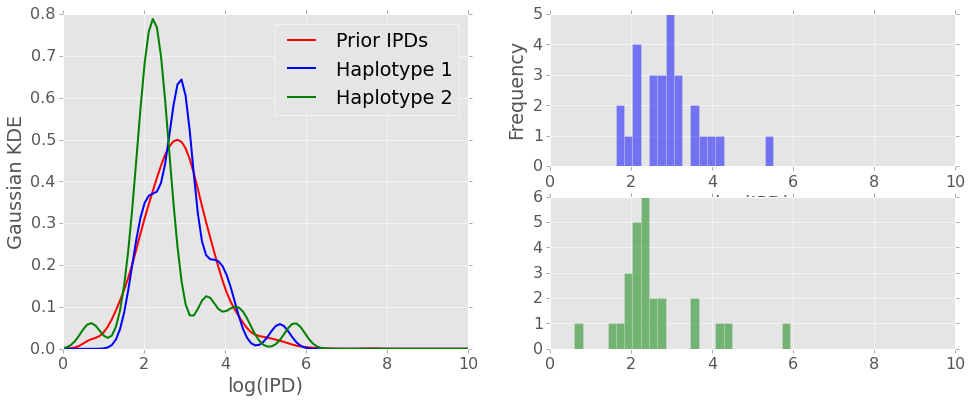

000000F 82515 motif: CTAATAATATT n_prior: 2000 n_hap1: 27 n_hap2: 26

======mixed======
two components:
	weight  : [ 0.3661401  0.6338599]
	means   : [[ 3.35083326  2.39774861]]
	AIC1:  136.708864613 	BIC1:  146.56032418
one component:
	weight  : [ 1.]
	means   : [[ 2.74671112]]
	AIC:  144.353618495 	BIC:  148.294202322
=====distribution comparisions======
ks test haps  : (0.43447293447293445, 0.0088377117752068534)
ks test hap1  : (0.10570370370370374, 0.91186420517685296)
ks test hap2  : (0.33184615384615385, 0.0050905410559856394)
[                  0%                  ]  70144 of 33000000 complete Elapsed: 5.3 minutes	 Remaining: 2476.5 minutes

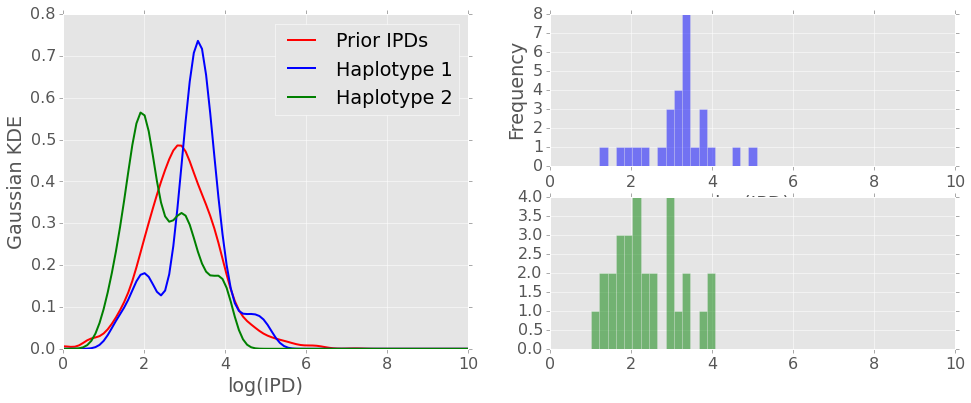

000000F 82586 motif: TTAATAGAAAA n_prior: 2000 n_hap1: 28 n_hap2: 29

======mixed======
two components:
	weight  : [ 0.62951615  0.37048385]
	means   : [[ 3.35701013  1.86071932]]
	AIC1:  146.388956775 	BIC1:  156.604213114
one component:
	weight  : [ 1.]
	means   : [[ 2.80265856]]
	AIC:  149.580918048 	BIC:  153.667020584
=====distribution comparisions======
ks test haps  : (0.47660098522167482, 0.0018360037541633879)
ks test hap1  : (0.28000000000000003, 0.020816741188562141)
ks test hap2  : (0.3112413793103449, 0.0058569032117918628)
[                  0%                  ]  70503 of 33000000 complete Elapsed: 5.3 minutes	 Remaining: 2485.7 minutes

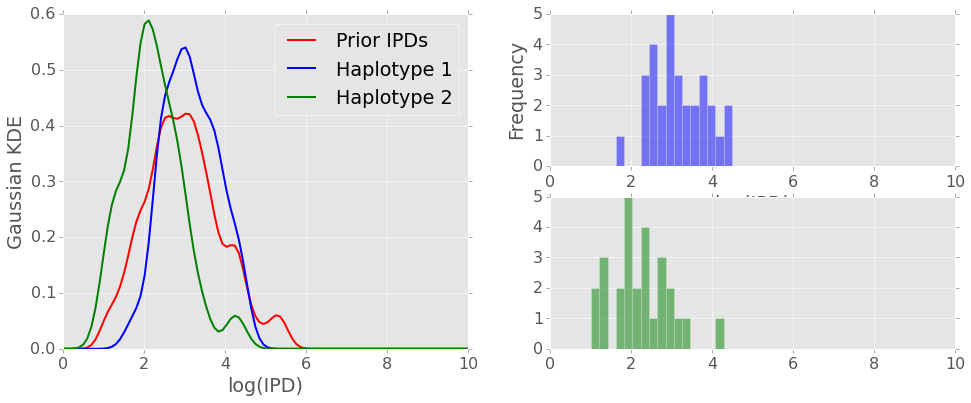

000000F 82747 motif: CGCTTAAAATT n_prior: 132 n_hap1: 30 n_hap2: 27

======mixed======
two components:
	weight  : [ 0.48272872  0.51727128]
	means   : [[ 3.21596304  2.27998634]]
	AIC1:  148.319882996 	BIC1:  158.535139336
one component:
	weight  : [ 1.]
	means   : [[ 2.73180917]]
	AIC:  143.059599384 	BIC:  147.14570192
=====distribution comparisions======
ks test haps  : (0.562962962962963, 0.00011841937145487659)
ks test hap1  : (0.19090909090909092, 0.30234902951426218)
ks test hap2  : (0.38299663299663295, 0.0018608082491954857)
[                  0%                  ]  70574 of 33000000 complete Elapsed: 5.4 minutes	 Remaining: 2502.1 minutes

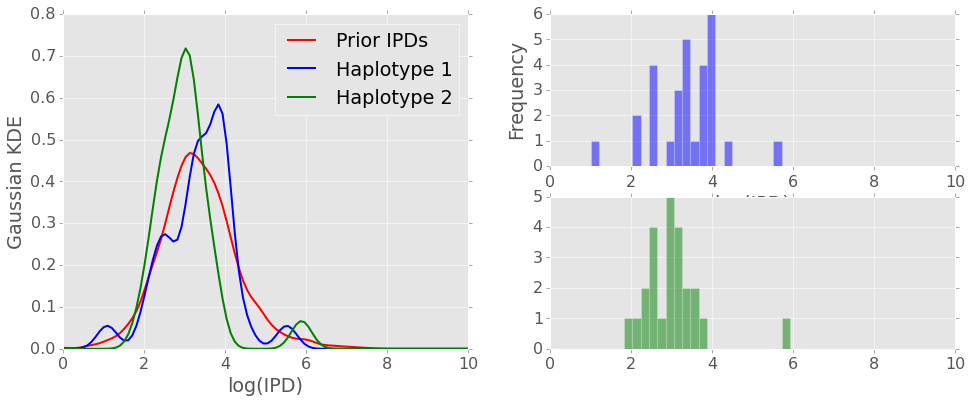

000000F 83099 motif: TTGAGGCTTTT n_prior: 1748 n_hap1: 29 n_hap2: 24

======mixed======
two components:
	weight  : [ 0.7149252  0.2850748]
	means   : [[ 3.13298829  3.41253797]]
	AIC1:  132.32031632 	BIC1:  142.171775887
one component:
	weight  : [ 1.]
	means   : [[ 3.21268086]]
	AIC:  132.45802809 	BIC:  136.398611917
=====distribution comparisions======
ks test haps  : (0.45402298850574718, 0.0056311331622778873)
ks test hap1  : (0.13260475025645074, 0.66612797387934153)
ks test hap2  : (0.33047292143401985, 0.0083490309217826211)
[                  0%                  ]  70735 of 33000000 complete Elapsed: 5.4 minutes	 Remaining: 2514.5 minutes

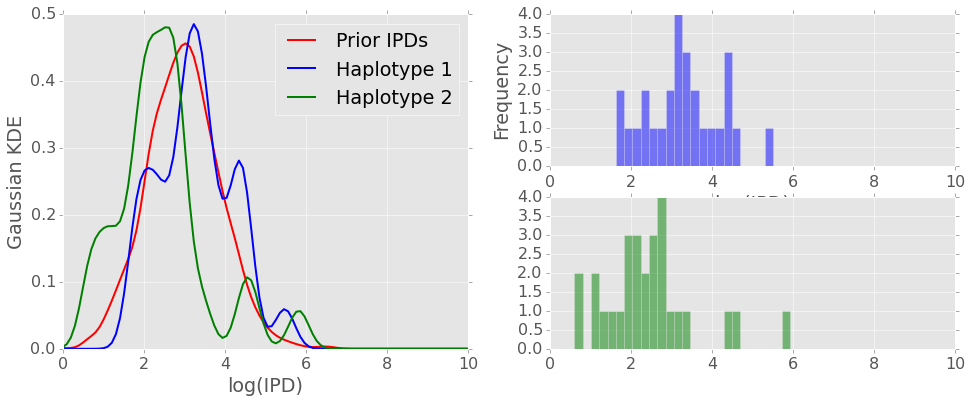

000000F 83384 motif: TGGAAAAATTG n_prior: 2000 n_hap1: 27 n_hap2: 28

======mixed======
two components:
	weight  : [ 0.56686213  0.43313787]
	means   : [[ 2.32030935  3.5430376 ]]
	AIC1:  175.164909105 	BIC1:  185.201575031
one component:
	weight  : [ 1.]
	means   : [[ 2.84991927]]
	AIC:  171.53124712 	BIC:  175.54591349
=====distribution comparisions======
ks test haps  : (0.48941798941798942, 0.0016057891255667406)
ks test hap1  : (0.16962962962962969, 0.39341857220517579)
ks test hap2  : (0.34942857142857142, 0.0016341745288464282)
[                  0%                  ]  71087 of 33000000 complete Elapsed: 5.5 minutes	 Remaining: 2526.2 minutes

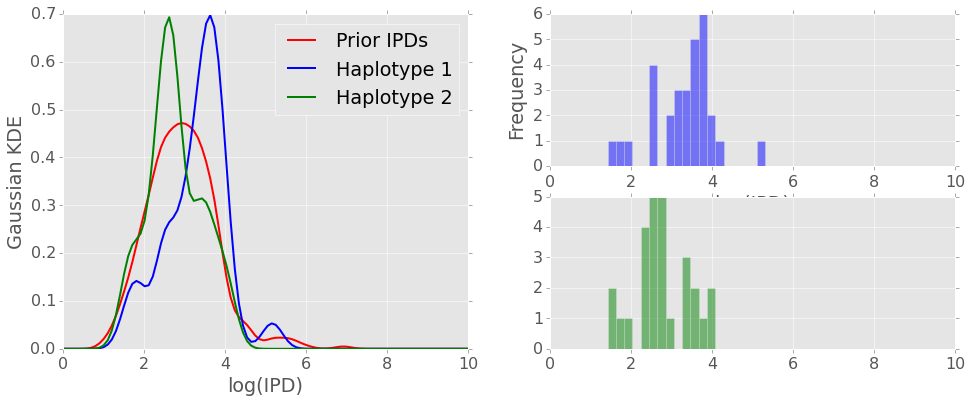

000000F 83431 motif: GGGGACACCAG n_prior: 411 n_hap1: 30 n_hap2: 27

======mixed======
two components:
	weight  : [ 0.51011502  0.48988498]
	means   : [[ 3.47075597  2.59470442]]
	AIC1:  138.223611859 	BIC1:  148.438868198
one component:
	weight  : [ 1.]
	means   : [[ 3.04159148]]
	AIC:  132.806999187 	BIC:  136.893101722
=====distribution comparisions======
ks test haps  : (0.43333333333333329, 0.0062545295407025478)
ks test hap1  : (0.31532846715328466, 0.0057017142239445609)
ks test hap2  : (0.21897810218978098, 0.15321060376403806)
[                  0%                  ]  71419 of 33000000 complete Elapsed: 5.5 minutes	 Remaining: 2550.6 minutes

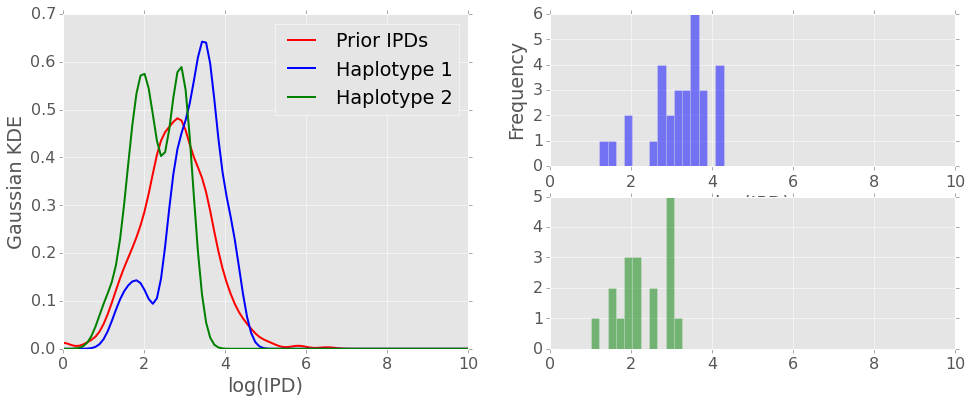

000000F 84440 motif: GACTCATGCTT n_prior: 628 n_hap1: 30 n_hap2: 18

======mixed======
two components:
	weight  : [ 0.27724903  0.72275097]
	means   : [[ 1.81728298  3.25301894]]
	AIC1:  116.692021463 	BIC1:  126.048026517
one component:
	weight  : [ 1.]
	means   : [[ 2.85496253]]
	AIC:  117.597105129 	BIC:  121.33950715
=====distribution comparisions======
ks test haps  : (0.59999999999999998, 0.00028539078830098515)
ks test hap1  : (0.30467091295116777, 0.007407132850035439)
ks test hap2  : (0.32006369426751591, 0.042975643929980961)
[                  0%                  ]  71914 of 33000000 complete Elapsed: 5.6 minutes	 Remaining: 2544.5 minutes

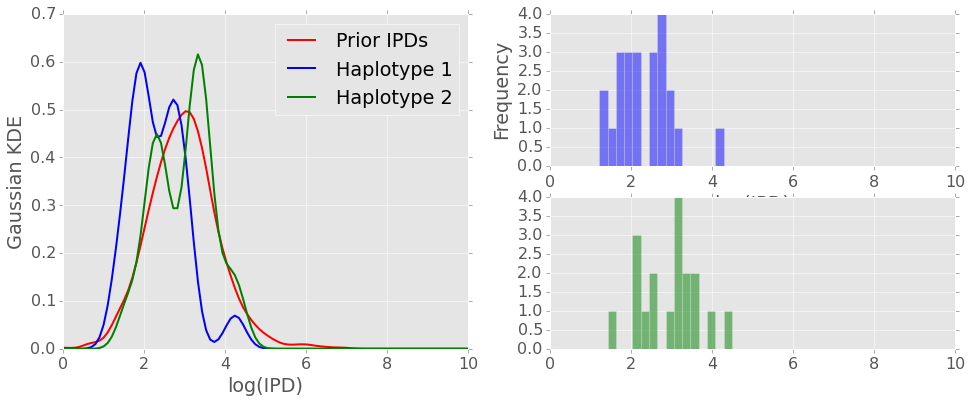

000000F 84639 motif: AGAAAACCCAG n_prior: 1775 n_hap1: 23 n_hap2: 18

======mixed======
two components:
	weight  : [ 0.49571336  0.50428664]
	means   : [[ 3.15417338  2.11049999]]
	AIC1:  100.063878914 	BIC1:  108.631739248
one component:
	weight  : [ 1.]
	means   : [[ 2.62786283]]
	AIC:  96.7573931717 	BIC:  100.184537305
=====distribution comparisions======
ks test haps  : (0.51207729468599039, 0.0059144258303410295)
ks test hap1  : (0.38469075321494184, 0.0016014796776190104)
ks test hap2  : (0.15442879499217532, 0.75324719008328722)
[                  0%                  ]  72428 of 33000000 complete Elapsed: 5.6 minutes	 Remaining: 2552.9 minutes

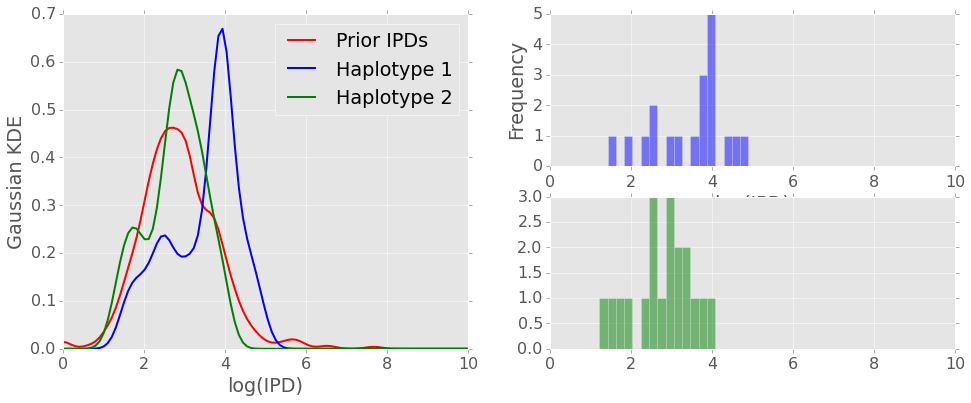

000000F 85058 motif: GAGCACATGCA n_prior: 948 n_hap1: 19 n_hap2: 19

======mixed======
two components:
	weight  : [ 0.50178032  0.49821968]
	means   : [[ 3.7439728   2.47629079]]
	AIC1:  103.955663735 	BIC1:  112.143594533
one component:
	weight  : [ 1.]
	means   : [[ 3.11238867]]
	AIC:  100.377382881 	BIC:  103.652555201
=====distribution comparisions======
ks test haps  : (0.52631578947368429, 0.0060051026440472634)
ks test hap1  : (0.40689540306462363, 0.0027462886400937887)
ks test hap2  : (0.12785920497446146, 0.90085818252208361)
[                  0%                  ]  72627 of 33000000 complete Elapsed: 5.7 minutes	 Remaining: 2564.8 minutes

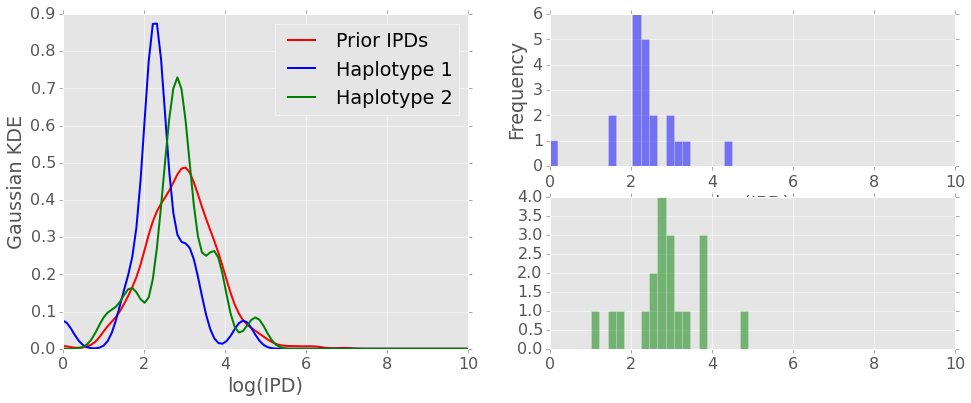

000000F 85176 motif: AGTGAATGCAG n_prior: 817 n_hap1: 21 n_hap2: 19

======mixed======
two components:
	weight  : [ 0.47555765  0.52444235]
	means   : [[ 2.91729399  2.3277477 ]]
	AIC1:  110.463541257 	BIC1:  118.907938528
one component:
	weight  : [ 1.]
	means   : [[ 2.60811094]]
	AIC:  104.292118746 	BIC:  107.669877654
=====distribution comparisions======
ks test haps  : (0.50375939849624063, 0.0076108426355948689)
ks test hap1  : (0.40449962114588794, 0.001595044861742982)
ks test hap2  : (0.15911872705018359, 0.69652067338892887)
[                  0%                  ]  73164 of 33000000 complete Elapsed: 5.7 minutes	 Remaining: 2587.3 minutes

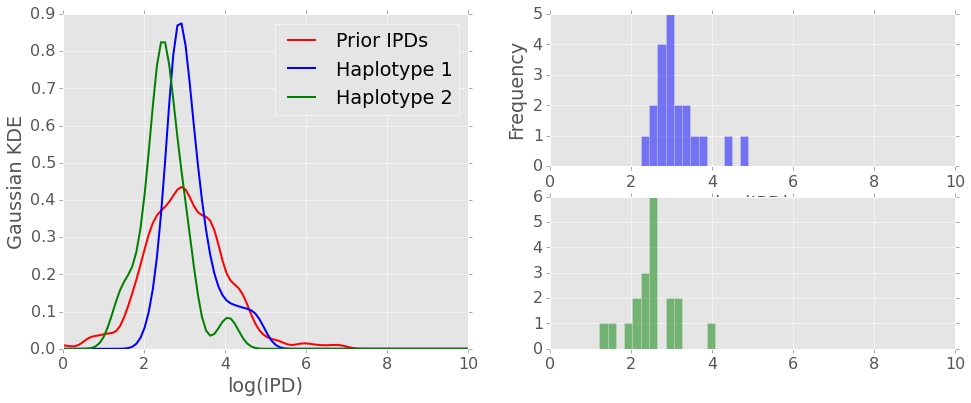

000000F 85775 motif: GCACAAGATTA n_prior: 436 n_hap1: 20 n_hap2: 19

======mixed======
two components:
	weight  : [ 0.36140621  0.63859379]
	means   : [[ 3.0376501   2.71425798]]
	AIC1:  81.5357442757 	BIC1:  89.8535525064
one component:
	weight  : [ 1.]
	means   : [[ 2.8311339]]
	AIC:  81.9798225053 	BIC:  85.3069457975
=====distribution comparisions======
ks test haps  : (0.58684210526315783, 0.001228404655450808)
ks test hap1  : (0.25275229357798168, 0.14728009079114512)
ks test hap2  : (0.3923225494929985, 0.0049867706301216022)
[                  0%                  ]  74331 of 33000000 complete Elapsed: 5.8 minutes	 Remaining: 2583.7 minutes

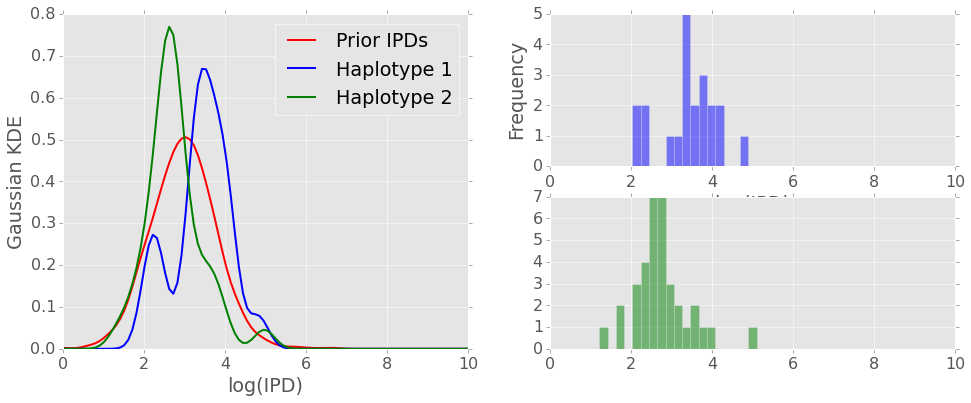

000000F 87451 motif: TTTATGTAAAG n_prior: 2000 n_hap1: 21 n_hap2: 35

======mixed======
two components:
	weight  : [ 0.55364641  0.44635359]
	means   : [[ 2.60677467  3.48514528]]
	AIC1:  133.792564855 	BIC1:  143.919323309
one component:
	weight  : [ 1.]
	means   : [[ 2.99883854]]
	AIC:  129.788476812 	BIC:  133.839180194
=====distribution comparisions======
ks test haps  : (0.56190476190476191, 0.000249212427184436)
ks test hap1  : (0.39490476190476193, 0.0020192542997429135)
ks test hap2  : (0.27435714285714285, 0.0087984258661552225)
[                  0%                  ]  74884 of 33000000 complete Elapsed: 5.9 minutes	 Remaining: 2575.6 minutes

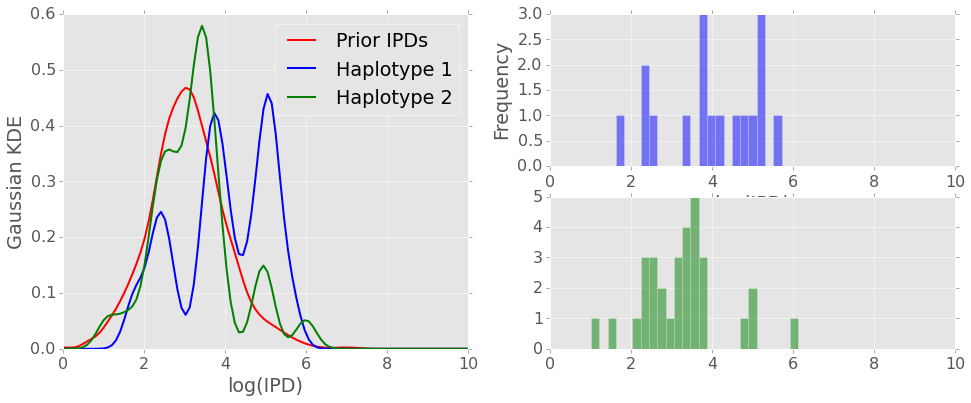

000000F 87901 motif: GTTCATTTTAC n_prior: 1671 n_hap1: 17 n_hap2: 31

======mixed======
two components:
	weight  : [ 0.64435611  0.35564389]
	means   : [[ 2.97072616  4.47088981]]
	AIC1:  153.143717895 	BIC1:  162.49972295
one component:
	weight  : [ 1.]
	means   : [[ 3.5042502]]
	AIC:  148.970195994 	BIC:  152.712598016
=====distribution comparisions======
ks test haps  : (0.48007590132827321, 0.0078562976955101043)
ks test hap1  : (0.46650473474847748, 0.0007729421065185997)
ks test hap2  : (0.13665759348275136, 0.58856088268548501)
[                  0%                  ]  75889 of 33000000 complete Elapsed: 6.0 minutes	 Remaining: 2592.1 minutes

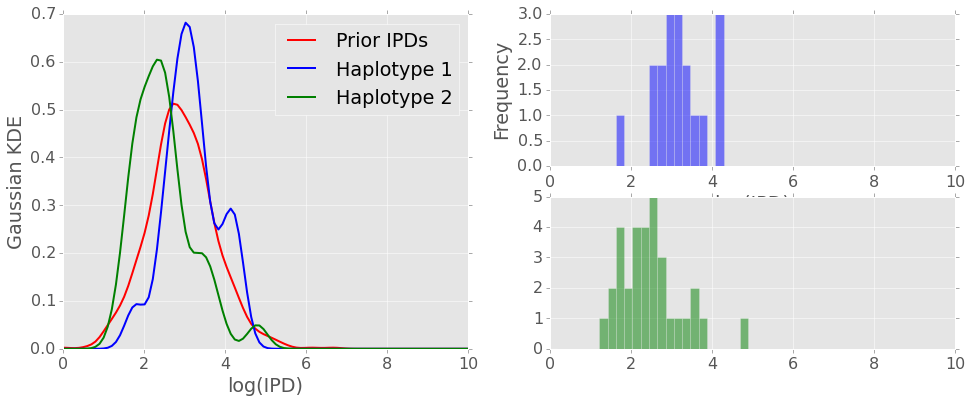

000000F 88794 motif: GAAGAACCAAA n_prior: 863 n_hap1: 18 n_hap2: 32

======mixed======
two components:
	weight  : [ 0.59360267  0.40639733]
	means   : [[ 2.36078601  3.30256707]]
	AIC1:  122.999024188 	BIC1:  132.559139215
one component:
	weight  : [ 1.]
	means   : [[ 2.74352332]]
	AIC:  119.998582525 	BIC:  123.822628536
=====distribution comparisions======
ks test haps  : (0.52777777777777779, 0.0018108873126149682)
ks test hap1  : (0.23200720999098751, 0.2613819469107681)
ks test hap2  : (0.32488412514484355, 0.0021281485575815303)
[                  0%                  ]  76782 of 33000000 complete Elapsed: 6.1 minutes	 Remaining: 2595.4 minutes

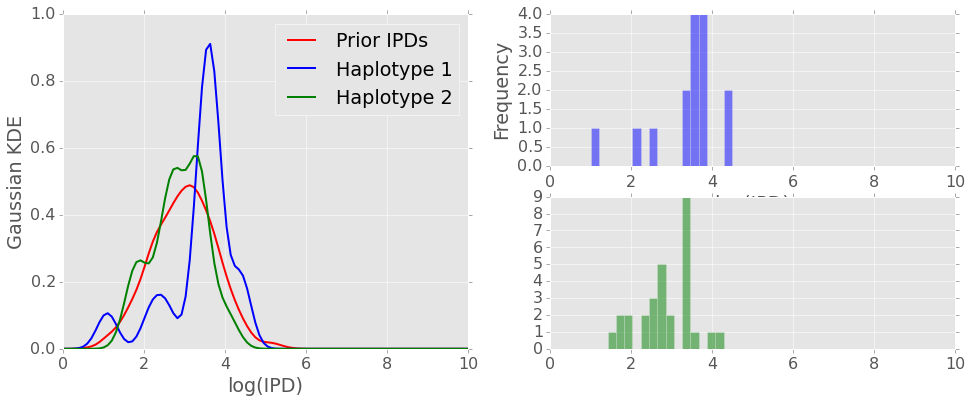

000000F 89640 motif: CATTGGTCTGT n_prior: 1224 n_hap1: 15 n_hap2: 29

======mixed======
two components:
	weight  : [ 0.44605476  0.55394524]
	means   : [[ 2.52580399  3.45212856]]
	AIC1:  105.552657834 	BIC1:  114.473606003
one component:
	weight  : [ 1.]
	means   : [[ 3.03893708]]
	AIC:  103.032796813 	BIC:  106.601176081
=====distribution comparisions======
ks test haps  : (0.56321839080459779, 0.0020039678011343669)
ks test hap1  : (0.47238562091503272, 0.0015954341916434081)
ks test hap2  : (0.19393734505296378, 0.21157866326131769)
[                  0%                  ]  77313 of 33000000 complete Elapsed: 6.1 minutes	 Remaining: 2588.2 minutes

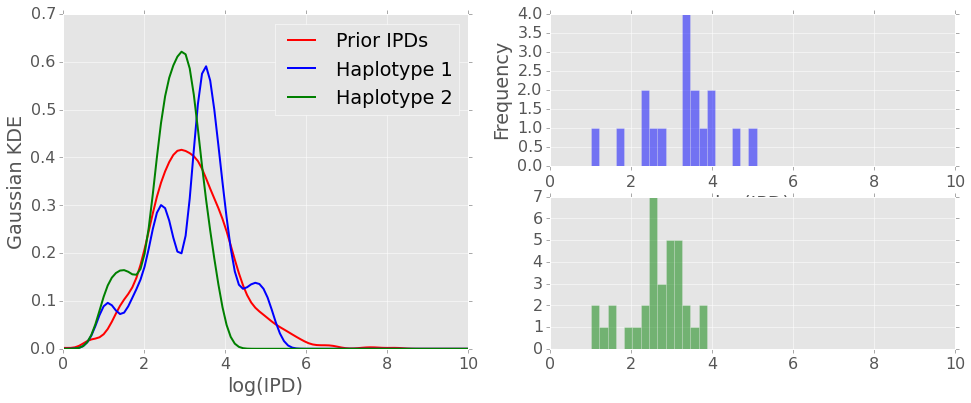

000000F 90106 motif: CAAATTCCTAC n_prior: 1073 n_hap1: 17 n_hap2: 34

======mixed======
two components:
	weight  : [ 0.46355076  0.53644924]
	means   : [[ 2.39541653  3.23140014]]
	AIC1:  135.227853265 	BIC1:  144.886981428
one component:
	weight  : [ 1.]
	means   : [[ 2.8438793]]
	AIC:  129.52723173 	BIC:  133.390882995
=====distribution comparisions======
ks test haps  : (0.49999999999999994, 0.004090228264905316)
ks test hap1  : (0.2127624581985636, 0.39048834830731161)
ks test hap2  : (0.28723754180143635, 0.0066592358936312388)
[                  0%                  ]  77628 of 33000000 complete Elapsed: 6.1 minutes	 Remaining: 2600.7 minutes

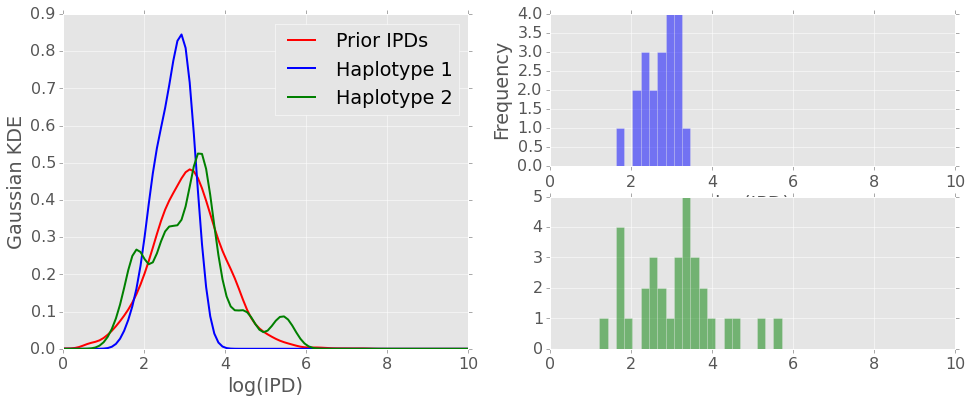

000000F 90240 motif: TCCCAAAATAA n_prior: 2000 n_hap1: 20 n_hap2: 32

======mixed======
two components:
	weight  : [ 0.68851789  0.31148211]
	means   : [[ 2.75182622  3.41277224]]
	AIC1:  131.87053415 	BIC1:  141.626752743
one component:
	weight  : [ 1.]
	means   : [[ 2.95769908]]
	AIC:  132.050814152 	BIC:  135.953301589
=====distribution comparisions======
ks test haps  : (0.44999999999999996, 0.0088190043375440952)
ks test hap1  : (0.39899999999999991, 0.0024088429441820776)
ks test hap2  : (0.085999999999999993, 0.96726454184706123)
[                  0%                  ]  78094 of 33000000 complete Elapsed: 6.2 minutes	 Remaining: 2607.5 minutes

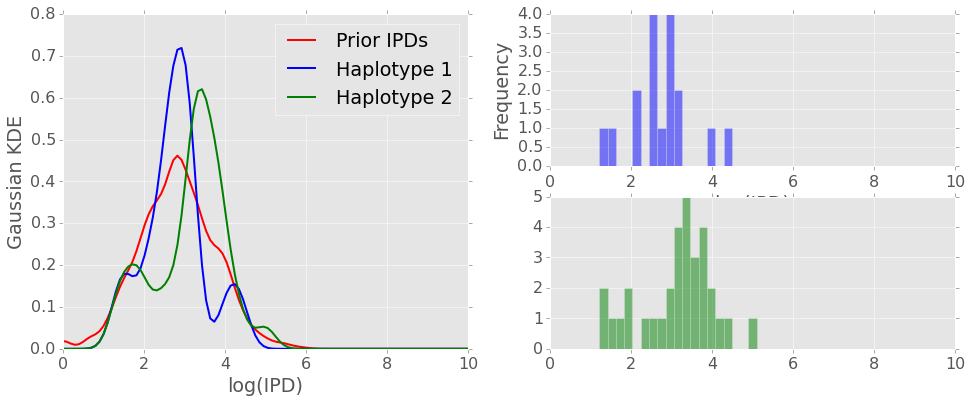

000000F 90422 motif: TATGTATCTCC n_prior: 745 n_hap1: 17 n_hap2: 32

======mixed======
two components:
	weight  : [ 0.42203555  0.57796445]
	means   : [[ 2.43551068  3.43915726]]
	AIC1:  130.364395639 	BIC1:  139.823497129
one component:
	weight  : [ 1.]
	means   : [[ 3.01558272]]
	AIC:  125.740873184 	BIC:  129.52451378
=====distribution comparisions======
ks test haps  : (0.47977941176470584, 0.007460111530011037)
ks test hap1  : (0.20047374654559813, 0.47024229919239846)
ks test hap2  : (0.30859899328859064, 0.004297997218081215)
[                  0%                  ]  78954 of 33000000 complete Elapsed: 6.3 minutes	 Remaining: 2624.8 minutes

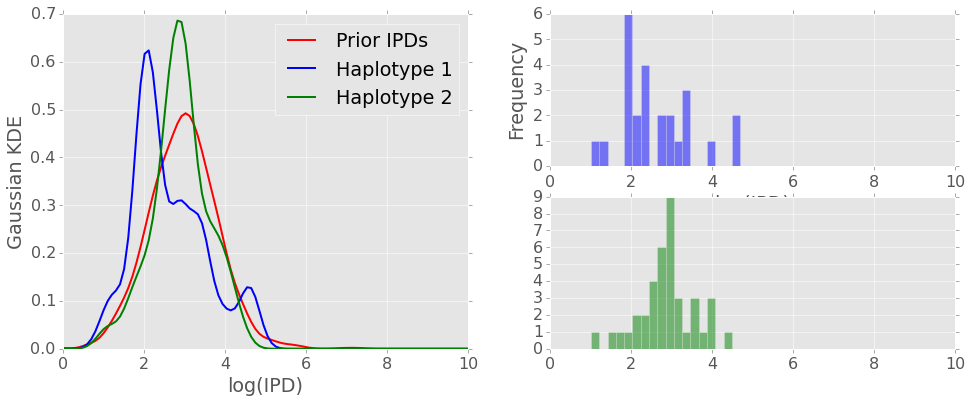

000000F 91626 motif: AAGTTGTAAAT n_prior: 1375 n_hap1: 25 n_hap2: 39

======mixed======
two components:
	weight  : [ 0.53335756  0.46664244]
	means   : [[ 3.18266646  2.353289  ]]
	AIC1:  159.383500414 	BIC1:  170.17791583
one component:
	weight  : [ 1.]
	means   : [[ 2.79564374]]
	AIC:  153.746526909 	BIC:  158.064293075
=====distribution comparisions======
ks test haps  : (0.4061538461538462, 0.0088983603209778443)
ks test hap1  : (0.33090909090909093, 0.0067569798427659054)
ks test hap2  : (0.14685314685314688, 0.35966340572778926)
[                  0%                  ]  79442 of 33000000 complete Elapsed: 6.3 minutes	 Remaining: 2619.1 minutes

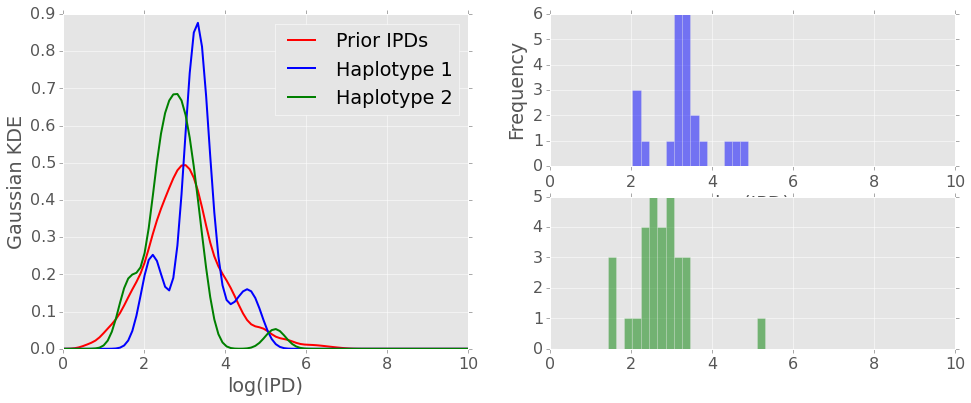

000000F 91674 motif: TTCCTGGAATA n_prior: 1265 n_hap1: 23 n_hap2: 30

======mixed======
two components:
	weight  : [ 0.39739278  0.60260722]
	means   : [[ 3.17504112  2.84805074]]
	AIC1:  123.050873892 	BIC1:  132.90233346
one component:
	weight  : [ 1.]
	means   : [[ 2.97799435]]
	AIC:  120.976989154 	BIC:  124.917572981
=====distribution comparisions======
ks test haps  : (0.54927536231884067, 0.0003970424171153516)
ks test hap1  : (0.33913043478260874, 0.008062673501792135)
ks test hap2  : (0.23465085638998684, 0.066971583498468115)
[                  0%                  ]  79614 of 33000000 complete Elapsed: 6.4 minutes	 Remaining: 2630.7 minutes

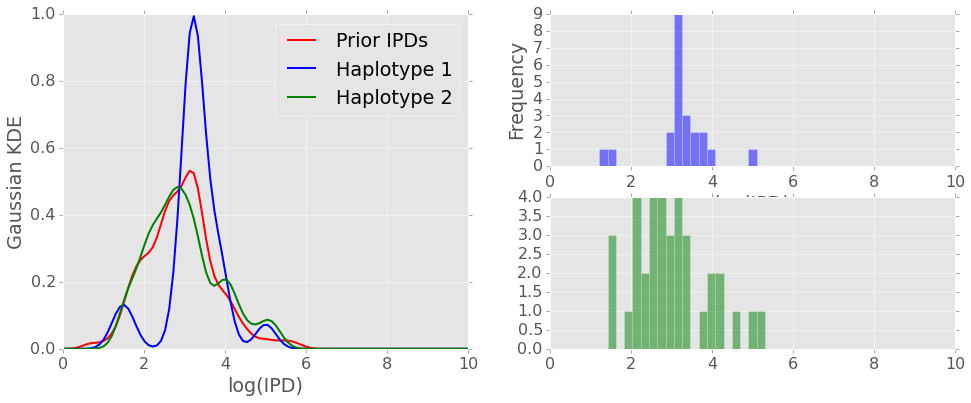

000000F 91835 motif: GGGAGCCTGTC n_prior: 271 n_hap1: 22 n_hap2: 36

======mixed======
two components:
	weight  : [ 0.580783  0.419217]
	means   : [[ 3.41268729  2.62578057]]
	AIC1:  154.076098612 	BIC1:  164.378313665
one component:
	weight  : [ 1.]
	means   : [[ 3.08280262]]
	AIC:  148.106339451 	BIC:  152.227225472
=====distribution comparisions======
ks test haps  : (0.44696969696969702, 0.0054388200463244551)
ks test hap1  : (0.39869171418986915, 0.0020366081695569328)
ks test hap2  : (0.085690856908569035, 0.96704411672034074)
[                  0%                  ]  79662 of 33000000 complete Elapsed: 6.4 minutes	 Remaining: 2643.3 minutes

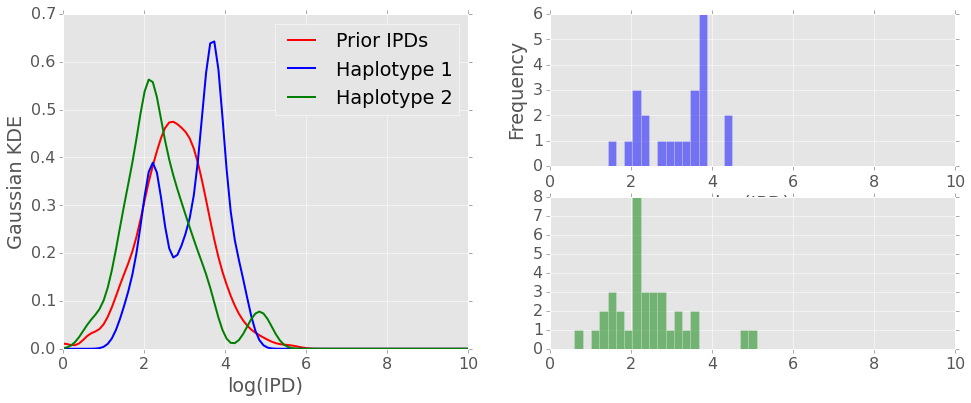

000000F 91928 motif: ACTAATGCAGA n_prior: 1092 n_hap1: 22 n_hap2: 35

======mixed======
two components:
	weight  : [ 0.55325955  0.44674045]
	means   : [[ 2.07753471  3.47876846]]
	AIC1:  159.032417666 	BIC1:  169.247674005
one component:
	weight  : [ 1.]
	means   : [[ 2.70352251]]
	AIC:  157.280413172 	BIC:  161.366515708
=====distribution comparisions======
ks test haps  : (0.43116883116883115, 0.0086713945747616088)
ks test hap1  : (0.35039960039960044, 0.0071886236843953025)
ks test hap2  : (0.25750915750915748, 0.017924990138555457)
[                  0%                  ]  79823 of 33000000 complete Elapsed: 6.4 minutes	 Remaining: 2655.2 minutes

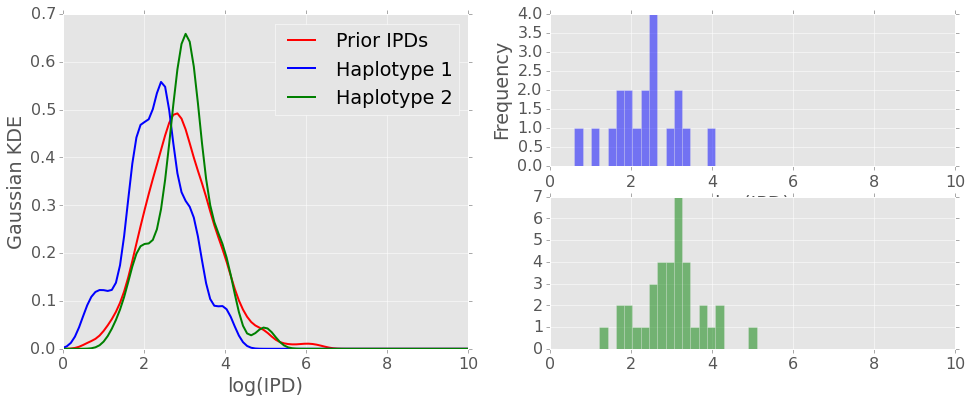

000000F 92494 motif: TACATTTACAG n_prior: 1175 n_hap1: 19 n_hap2: 36

======mixed======
two components:
	weight  : [ 0.46749567  0.53250433]
	means   : [[ 2.31517124  3.15413797]]
	AIC1:  142.413236531 	BIC1:  152.449902457
one component:
	weight  : [ 1.]
	means   : [[ 2.76192465]]
	AIC:  136.189631063 	BIC:  140.204297434
=====distribution comparisions======
ks test haps  : (0.48684210526315785, 0.0032849830993424093)
ks test hap1  : (0.36918253079507274, 0.0086318178037970792)
ks test hap2  : (0.13815602836879437, 0.48733892849972549)
[                  0%                  ]  80482 of 33000000 complete Elapsed: 6.5 minutes	 Remaining: 2670.3 minutes

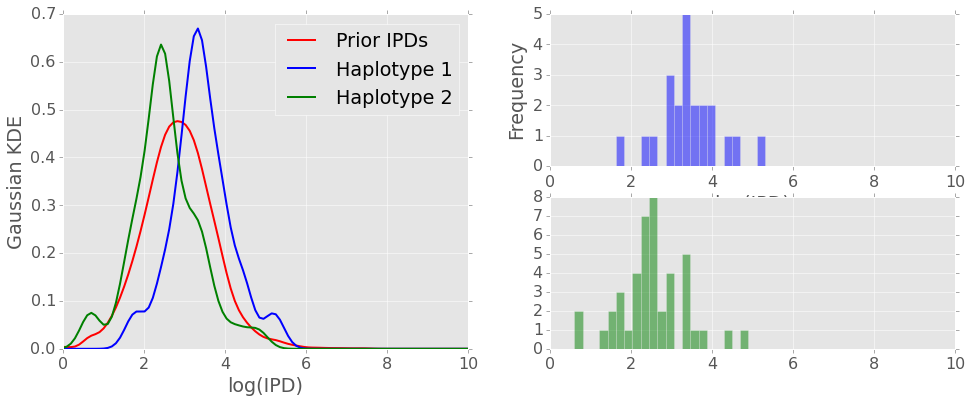

000000F 93442 motif: CCTCATTTTTC n_prior: 2000 n_hap1: 22 n_hap2: 43

======mixed======
two components:
	weight  : [ 0.50994161  0.49005839]
	means   : [[ 2.39050251  3.30313635]]
	AIC1:  178.73866758 	BIC1:  189.610603929
one component:
	weight  : [ 1.]
	means   : [[ 2.83774638]]
	AIC:  172.624372867 	BIC:  176.973147407
=====distribution comparisions======
ks test haps  : (0.56131078224101483, 0.00010029998477919594)
ks test hap1  : (0.36663636363636365, 0.0039948329359164236)
ks test hap2  : (0.23939534883720931, 0.013067409220322682)
[                  0%                  ]  81430 of 33000000 complete Elapsed: 6.6 minutes	 Remaining: 2669.1 minutes

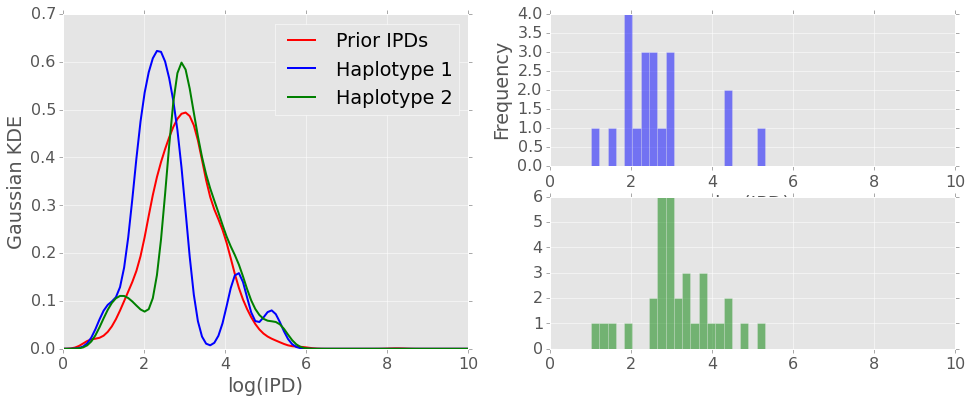

000000F 94280 motif: ACAGTAAAAAT n_prior: 2000 n_hap1: 20 n_hap2: 33

======mixed======
two components:
	weight  : [ 0.40412729  0.59587271]
	means   : [[ 3.60988557  2.5187116 ]]
	AIC1:  153.41518872 	BIC1:  163.266648288
one component:
	weight  : [ 1.]
	means   : [[ 2.95968478]]
	AIC:  149.274173088 	BIC:  153.214756915
=====distribution comparisions======
ks test haps  : (0.48636363636363633, 0.0032999439732050418)
ks test hap1  : (0.38199999999999995, 0.0042195379001559114)
ks test hap2  : (0.16568181818181815, 0.30695469362443545)
[                  0%                  ]  82024 of 33000000 complete Elapsed: 6.6 minutes	 Remaining: 2659.8 minutes

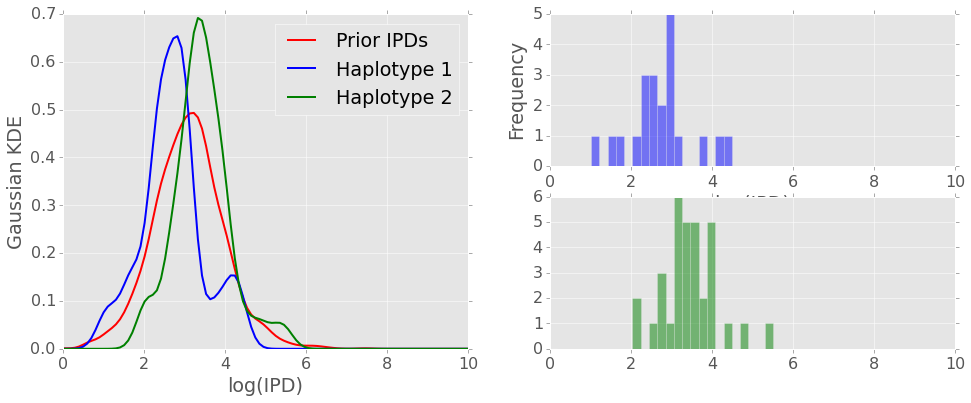

000000F 94682 motif: CTTCTTTTTAT n_prior: 2000 n_hap1: 21 n_hap2: 33

======mixed======
two components:
	weight  : [ 0.53617905  0.46382095]
	means   : [[ 2.8169656   3.55121075]]
	AIC1:  137.486628913 	BIC1:  147.431549146
one component:
	weight  : [ 1.]
	means   : [[ 3.15752388]]
	AIC:  131.225405074 	BIC:  135.203373167
=====distribution comparisions======
ks test haps  : (0.59740259740259738, 9.573241133296164e-05)
ks test hap1  : (0.32914285714285707, 0.016591418736428977)
ks test hap2  : (0.29387878787878785, 0.0055611277542666647)
[                  0%                  ]  82670 of 33000000 complete Elapsed: 6.7 minutes	 Remaining: 2677.2 minutes

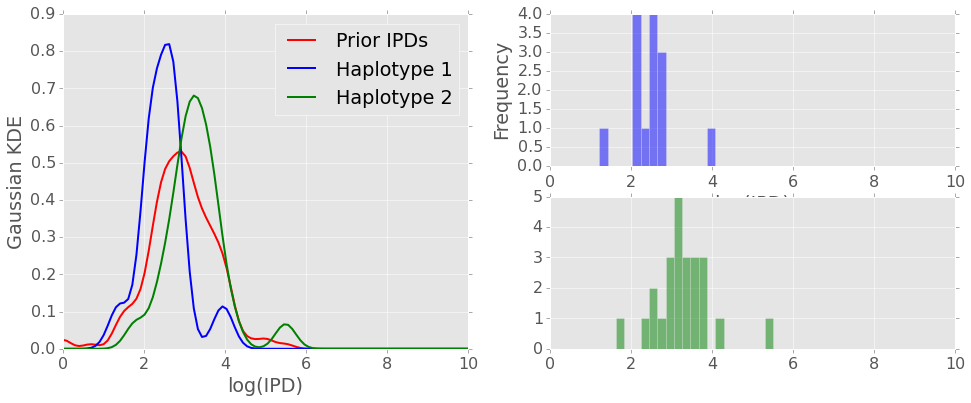

000000F 95432 motif: TATACGAAAAC n_prior: 164 n_hap1: 14 n_hap2: 24

======mixed======
two components:
	weight  : [ 0.40345066  0.59654934]
	means   : [[ 3.24741376  2.81518989]]
	AIC1:  93.5246920717 	BIC1:  101.71262287
one component:
	weight  : [ 1.]
	means   : [[ 2.9895709]]
	AIC:  89.739654294 	BIC:  93.0148266135
=====distribution comparisions======
ks test haps  : (0.72023809523809523, 7.6774543646140347e-05)
ks test hap1  : (0.47735191637630664, 0.0033840730013894099)
ks test hap2  : (0.25406504065040647, 0.11273671204958452)
[                  0%                  ]  83228 of 33000000 complete Elapsed: 6.7 minutes	 Remaining: 2669.1 minutes

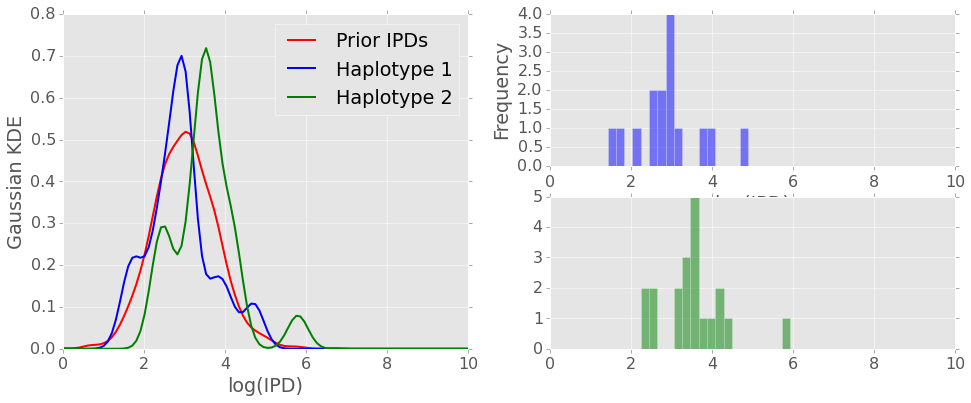

000000F 95455 motif: ATTTGGAACAT n_prior: 1552 n_hap1: 15 n_hap2: 20

======mixed======
two components:
	weight  : [ 0.4494525  0.5505475]
	means   : [[ 3.58377397  2.98443671]]
	AIC1:  94.7660455982 	BIC1:  102.542785906
one component:
	weight  : [ 1.]
	means   : [[ 3.25381034]]
	AIC:  90.0182081619 	BIC:  93.1289042848
=====distribution comparisions======
ks test haps  : (0.53333333333333321, 0.0088968985381202865)
ks test hap1  : (0.20979381443298972, 0.48095623936789528)
ks test hap2  : (0.3694587628865979, 0.0063818153878623367)
[                  0%                  ]  83420 of 33000000 complete Elapsed: 6.8 minutes	 Remaining: 2679.0 minutes

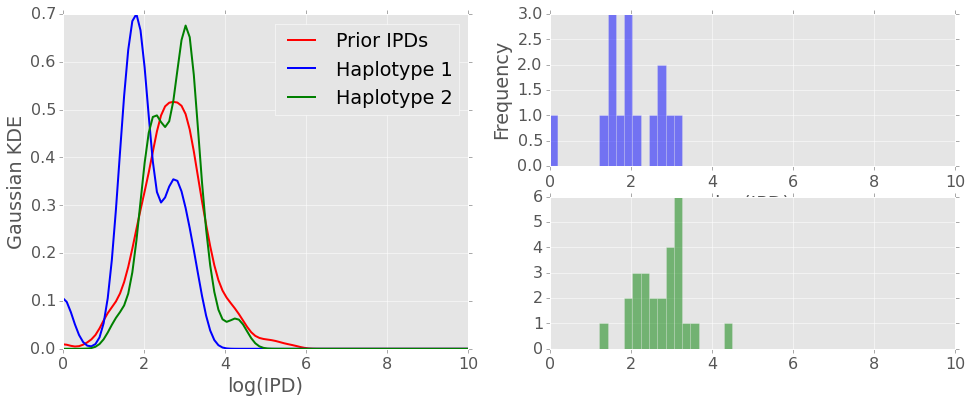

000000F 95463 motif: CATATCTGGAA n_prior: 844 n_hap1: 15 n_hap2: 26

======mixed======
two components:
	weight  : [ 0.55038291  0.44961709]
	means   : [[ 2.70200213  2.20146801]]
	AIC1:  102.49706687 	BIC1:  111.064927204
one component:
	weight  : [ 1.]
	means   : [[ 2.47695344]]
	AIC:  97.7881935366 	BIC:  101.21533767
=====distribution comparisions======
ks test haps  : (0.51282051282051277, 0.0080044031733092613)
ks test hap1  : (0.44984202211690361, 0.0032068970880432747)
ks test hap2  : (0.1168428727670433, 0.85975657173412046)
[                  0%                  ]  83443 of 33000000 complete Elapsed: 6.8 minutes	 Remaining: 2691.4 minutes

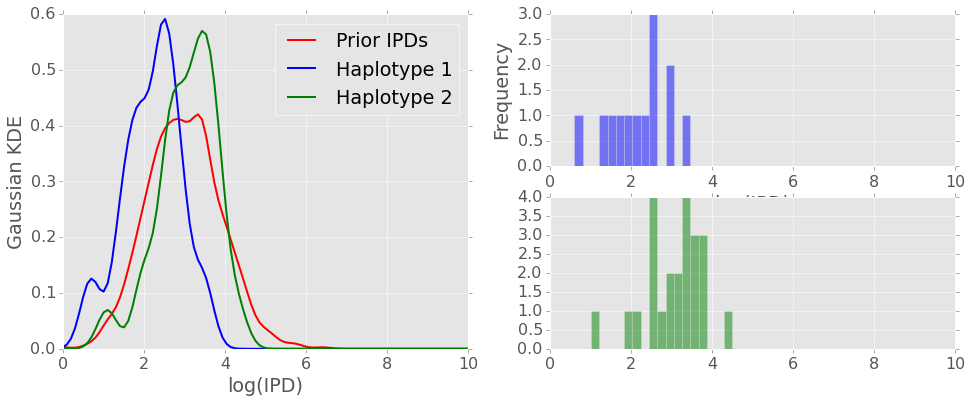

000000F 95702 motif: CCCAAACCATC n_prior: 761 n_hap1: 13 n_hap2: 23

======mixed======
two components:
	weight  : [ 0.46831662  0.53168338]
	means   : [[ 2.26147553  3.18299984]]
	AIC1:  96.0496006436 	BIC1:  103.967195336
one component:
	weight  : [ 1.]
	means   : [[ 2.75143469]]
	AIC:  91.8468936128 	BIC:  95.0139314897
=====distribution comparisions======
ks test haps  : (0.55183946488294322, 0.0071842019098054578)
ks test hap1  : (0.44607298089558278, 0.0079743023495351846)
ks test hap2  : (0.15471633434268414, 0.62178840337783114)
[                  0%                  ]  83451 of 33000000 complete Elapsed: 6.9 minutes	 Remaining: 2705.4 minutes

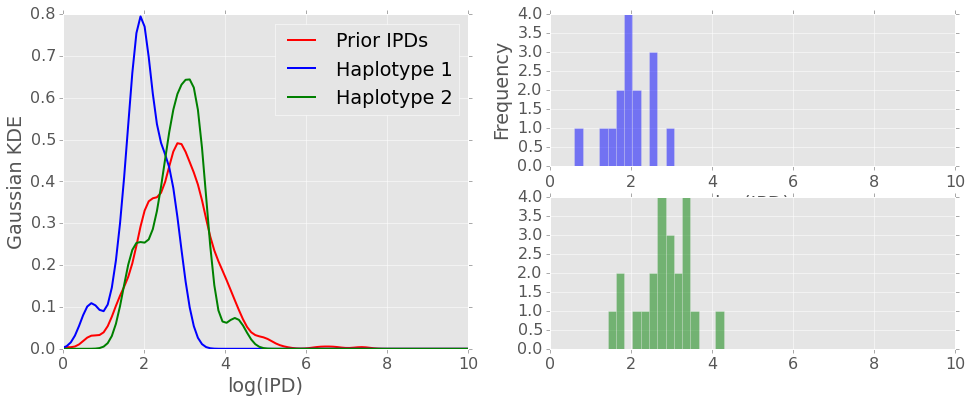

000000F 96294 motif: CATGCAAGACC n_prior: 495 n_hap1: 15 n_hap2: 22

======mixed======
two components:
	weight  : [ 0.46872669  0.53127331]
	means   : [[ 2.06425122  2.86310054]]
	AIC1:  89.7508322884 	BIC1:  97.8054218517
one component:
	weight  : [ 1.]
	means   : [[ 2.48865855]]
	AIC:  83.7957451847 	BIC:  87.0175810099
=====distribution comparisions======
ks test haps  : (0.61515151515151523, 0.0011312157815445455)
ks test hap1  : (0.51515151515151514, 0.00047666708316796742)
ks test hap2  : (0.14444444444444449, 0.73812492554383069)
[                  0%                  ]  83690 of 33000000 complete Elapsed: 6.9 minutes	 Remaining: 2714.3 minutes

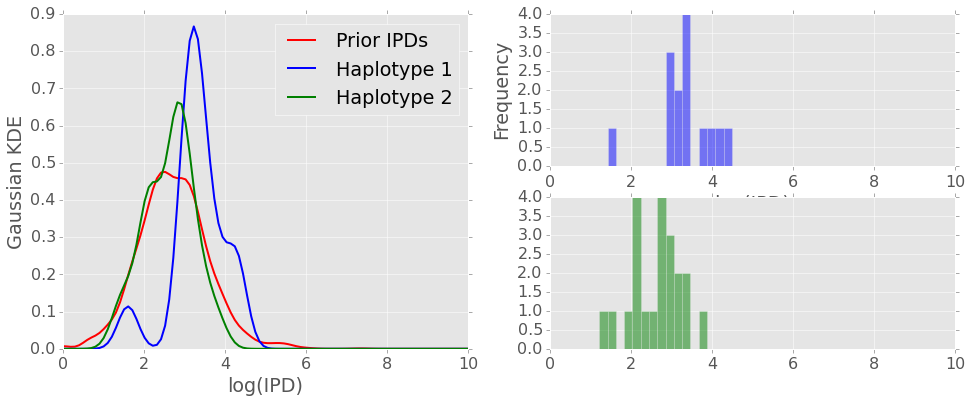

000000F 96534 motif: GGCTCACTGCA n_prior: 2000 n_hap1: 14 n_hap2: 21

======mixed======
two components:
	weight  : [ 0.37568159  0.62431841]
	means   : [[ 2.36719795  3.23457046]]
	AIC1:  83.7251863815 	BIC1:  91.501926689
one component:
	weight  : [ 1.]
	means   : [[ 2.90871457]]
	AIC:  78.6566202335 	BIC:  81.7673163564
=====distribution comparisions======
ks test haps  : (0.6428571428571429, 0.00088750954355516006)
ks test hap1  : (0.5485714285714286, 0.00023432832768794035)
ks test hap2  : (0.16764285714285709, 0.56313160174417731)
[                  0%                  ]  84282 of 33000000 complete Elapsed: 7.0 minutes	 Remaining: 2717.2 minutes

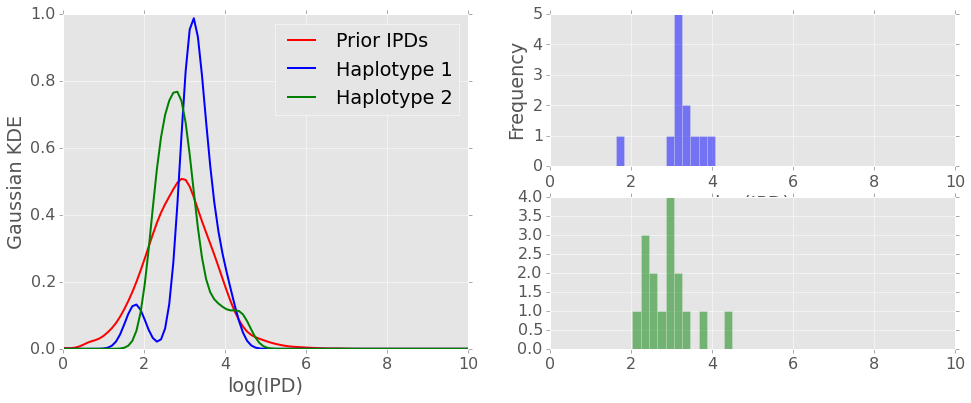

000000F 96907 motif: CTCTTATTTCA n_prior: 1995 n_hap1: 12 n_hap2: 16

======mixed======
two components:
	weight  : [ 0.49351706  0.50648294]
	means   : [[ 2.7837651  3.319712 ]]
	AIC1:  57.118225484 	BIC1:  63.7792480349
one component:
	weight  : [ 1.]
	means   : [[ 3.05521306]]
	AIC:  51.1478681383 	BIC:  53.8122771587
=====distribution comparisions======
ks test haps  : (0.60416666666666663, 0.0070736641112937558)
ks test hap1  : (0.45350877192982458, 0.0095199806366434523)
ks test hap2  : (0.18411654135338346, 0.6091728275351932)
[                  0%                  ]  84522 of 33000000 complete Elapsed: 7.0 minutes	 Remaining: 2728.0 minutes

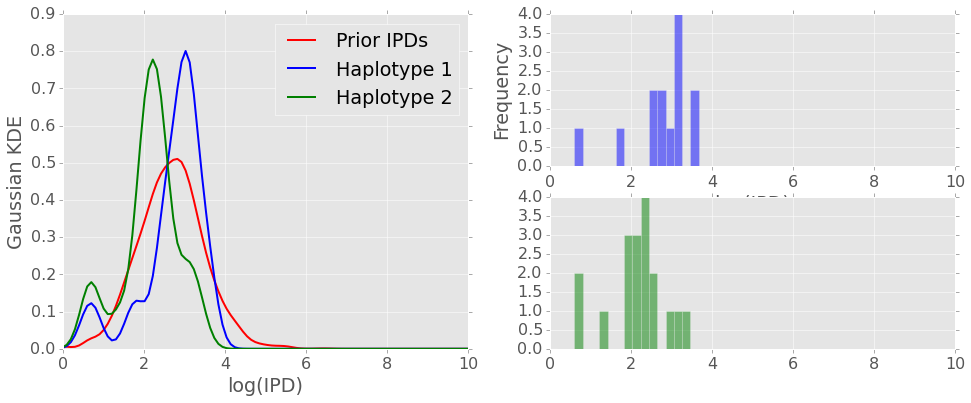

000000F 96975 motif: TATCTCTTCTT n_prior: 2000 n_hap1: 13 n_hap2: 18

======mixed======
two components:
	weight  : [ 0.62595949  0.37404051]
	means   : [[ 2.72146394  1.85218865]]
	AIC1:  76.8762314659 	BIC1:  84.0461674883
one component:
	weight  : [ 1.]
	means   : [[ 2.39631976]]
	AIC:  74.9873423534 	BIC:  77.8553167624
=====distribution comparisions======
ks test haps  : (0.56837606837606836, 0.0084922056313135336)
ks test hap1  : (0.22215384615384615, 0.49328869838179301)
ks test hap2  : (0.37383333333333335, 0.0096210160047547622)
[                  0%                  ]  84895 of 33000000 complete Elapsed: 7.1 minutes	 Remaining: 2734.8 minutes

KeyboardInterrupt: 

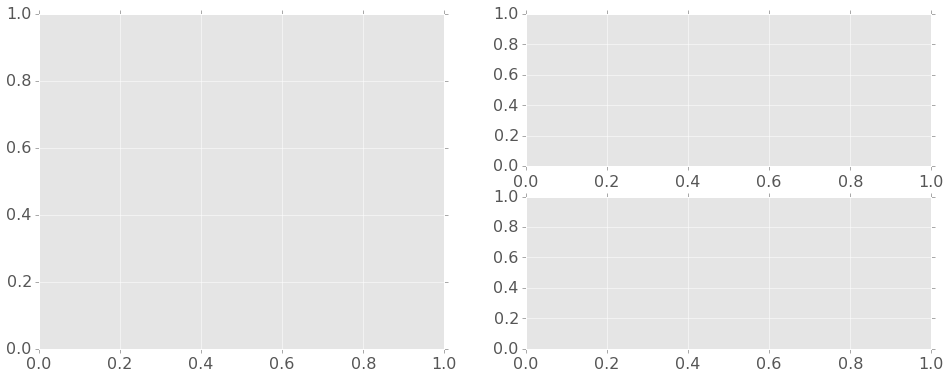

In [140]:
import itertools
'''
# Three subplots sharing both x/y axes
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing both axes')
ax2.scatter(x, y)
ax3.scatter(x, 2 * y ** 2 - 1, color='r')
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
'''
import matplotlib.gridspec as gridspec
pd.set_option('display.width', 900)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
rcParams['figure.figsize'] = (16, 6)
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 16
rcParams['font.family'] = 'Bitstream Vera Sans'
outprefix = "truth_test_optical_set"
pos_in = open('/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/', 'rb')
pbar = ProgressBar(33000000)
siteslist = [] # list of methyl potentials
for line in pos_in:
    pbar.animate()
    if (line[0] == "#") | (line[0] == "="):
        continue
    chrom, pos, ipdl_hap1, ipdl_hap2 = line.strip('\n').split('\t')
    pos = int(pos)
    #if pos < 2000: 
    #    continue
    if pos not in opticalset:
        continue 
    curr_motif = str(sequences['000000F'][pos-5:pos+6])
    if curr_motif in motif_dict:
        prior_ipds = [int(x) for x in motif_dict[curr_motif].split(',', 2001)[0:2000]]
    else:
        continue
    if (ipdl_hap1 == '')|(ipdl_hap2 == ''):
        continue
    ipd_hap1 = [int(x) for x in ipdl_hap1.split(',')]
    ipd_hap2 = [int(x) for x in ipdl_hap2.split(',')]
    if (len(ipd_hap1) < 8) | (len(ipd_hap2) < 8):
        continue
    kstest_haps = stats.ks_2samp(ipd_hap1, ipd_hap2)
    kstest_prior1 = stats.ks_2samp(prior_ipds, ipd_hap1)
    kstest_prior2 = stats.ks_2samp(prior_ipds, ipd_hap2)
    if kstest_haps[1] > 0.01:
        continue
    if min([kstest_prior1[1], kstest_prior2[1]]) > 0.01:
        continue
    logx = np.linspace(0,10,100)
    halflogx = np.linspace(0,10,50)
    kde_prior = kde_scipy(np.log(prior_ipds), logx)
    kde_hap1 = kde_scipy(np.log(ipd_hap1), logx, bandwidth=0.25)
    kde_hap2 = kde_scipy(np.log(ipd_hap2), logx, bandwidth=0.25)
    gs = gridspec.GridSpec(2, 2)
    ax1 = plt.subplot(gs[:,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[1,1])
    ax1.plot(logx, kde_prior, 'r-', label="Prior IPDs")
    ax1.plot(logx, kde_hap1, 'b-', label="Haplotype 1")
    ax1.plot(logx, kde_hap2, 'g-', label="Haplotype 2")
    #plt.hist(prior_ipds, bins=np.logspace(0.1,3,50),normed=True, color='b', alpha=0.5)
    #plt.hist(ipds, bins=np.logspace(0.1,3,50),normed=True, color='r', alpha=0.5)
    #plt.xscale('log')
    ax1.legend()
    ax1.set_xlabel("log(IPD)")
    ax1.set_ylabel("Gaussian KDE")
    #plt.show()
    obs1 = np.array([[np.log(i)] for i in ipd_hap1])
    obs2 = np.array([[np.log(i)] for i in ipd_hap2])
    obs = np.concatenate((obs1, obs2))
    ax2.hist(obs1, bins=halflogx, color='b', alpha=0.5)
    ax3.hist(obs2, bins=halflogx, color='g', alpha=0.5)
    ax2.set_xlabel("log(IPD)")
    ax2.set_ylabel("Frequency")
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    outfileline = outprefix + str(pos) + "_"
    plt.savefig(outfileline + "figure.png")
    plt.show()
    outstats = open(outfileline + "stats.txt", 'w')
    print >>outstats, "000000F", pos, "motif:", curr_motif, "n_prior:", len(prior_ipds), "n_hap1:", len(ipd_hap1), "n_hap2:", len(ipd_hap2)
    print >>outstats, ""
    print >>outstats,"======mixed======"
    print >>outstats,"two components:"
    g = mixture.GMM(n_components=2)
    x = g.fit(obs)
    print >>outstats,"\tweight  :", x.weights_
    print >>outstats,"\tmeans   :", np.reshape(x.means_, (1,2))
    print >>outstats,'\tAIC1: ', x.aic(obs), '\tBIC1: ', x.bic(obs)
    print >>outstats,"one component:"
    g = mixture.GMM(n_components=1)
    #obs = np.array([[np.log(i)] for i in ipds])
    x = g.fit(obs)
    print >>outstats,"\tweight  :", x.weights_
    print >>outstats,"\tmeans   :", x.means_
    print >>outstats,'\tAIC: ', x.aic(obs), '\tBIC: ', x.bic(obs)
    
    print >>outstats,"=====distribution comparisions======"
    print >>outstats,"ks test haps  :", kstest_haps
    print >>outstats,"ks test hap1  :", kstest_prior1
    print >>outstats,"ks test hap2  :", kstest_prior2
    outstats.close()
    outstats = open(outfileline + "stats.txt", 'r')
    for i in outstats:
        sys.stdout.write(i)
    outstats.close()
    #wait = raw_input("PRESS ENTER TO CONTINUE.")
    #display.clear_output(wait=True)
    #display.display(plt.gcf())
    